# GAN

Networks from https://github.com/pytorch/examples/blob/master/dcgan/main.py

Based on paper: [Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks](http://arxiv.org/abs/1511.06434)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [38]:
import torch
import torchvision
import random
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torch.utils.data
import torchvision.transforms as transforms
from sklearn.datasets import fetch_olivetti_faces
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
image_size = 64
import torchvision.utils as vutils

X = dset.FashionMNIST(root='./data/fashion-mnist', download=True,
transform=transforms.Compose([
   transforms.Resize(image_size),
   transforms.ToTensor(),
   transforms.Normalize((0.5,), (0.5,)),
]))
print(X)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data/fashion-mnist
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=64, interpolation=PIL.Image.BILINEAR)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


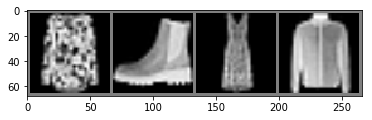

In [39]:
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()


dataloader = torch.utils.data.DataLoader(X, batch_size=4, shuffle=True, num_workers=2)
dataiter = iter(dataloader)
images,labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))

## Setup Networks

In [40]:
# use gpu if available
device = torch.device("cuda:0")

nz = 100 # size of latent vector
ngf = 64
ndf = 64
lr = 0.0002 # learning rate
nc = 1 # number of channels
batch_size = 64
beta1 = 0.5
outf = './fashion-samples'

# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Generator

In [41]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4 , 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    
    def forward(self, x):
        return self.main(x)
    
netG = Generator().to(device)
netG.apply(weights_init)
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


### Discriminator

In [42]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.main(x)
        return output.view(-1,1).squeeze(1)
            
netD = Discriminator().to(device)
netD.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

## Training

In [ ]:
criterion = nn.BCELoss()
fixed_noise = torch.randn(batch_size, nz, 1, 1, device=device)
real_label = 1
fake_label = 0

optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

n_epochs = 2

for epoch in range(n_epochs):
    for i,data in enumerate(dataloader, 0):
        
        # ---------------------
        # Discriminator Update
        # ---------------------
        
        # Train with real
        netD.zero_grad()
        real = data[0].to(device)
        batch_size = real.size(0)
        label = torch.full((batch_size,), real_label, device=device)
        
        output = netD(real)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()
        
        # Train with fake
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(fake_label)
        output = netD(fake.detach())
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        optimizerD.step()

        
        # ---------------------
        # Generator Update
        # ---------------------
        netG.zero_grad()
        label.fill_(real_label)
        output = netD(fake)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        optimizerG.step()
        
        print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
              % (epoch, n_epochs, i, len(dataloader),
                 errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        if i % 100 == 0:
            vutils.save_image(real,
                    '%s/real_samples.png' % outf,
                    normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.detach(),
                    '%s/fake_samples_epoch_%03d.png' % (outf, epoch),
                    normalize=True)

    # do checkpointing
    torch.save(netG.state_dict(), '%s/netG_epoch_%d.pth' % (outf, epoch))
    torch.save(netD.state_dict(), '%s/netD_epoch_%d.pth' % (outf, epoch))
        

[0/2][0/15000] Loss_D: 1.4653 Loss_G: 9.9327 D(x): 0.5612 D(G(z)): 0.5175 / 0.0002
[0/2][1/15000] Loss_D: 0.7363 Loss_G: 9.4182 D(x): 0.9024 D(G(z)): 0.4192 / 0.0006
[0/2][2/15000] Loss_D: 0.1466 Loss_G: 6.7502 D(x): 0.9425 D(G(z)): 0.0810 / 0.0013
[0/2][3/15000] Loss_D: 0.3953 Loss_G: 9.3915 D(x): 0.9920 D(G(z)): 0.2861 / 0.0005
[0/2][4/15000] Loss_D: 0.0430 Loss_G: 6.6680 D(x): 0.9955 D(G(z)): 0.0372 / 0.0014
[0/2][5/15000] Loss_D: 0.0633 Loss_G: 5.8641 D(x): 0.9719 D(G(z)): 0.0337 / 0.0031
[0/2][6/15000] Loss_D: 0.3954 Loss_G: 6.4765 D(x): 0.7995 D(G(z)): 0.1256 / 0.0030
[0/2][7/15000] Loss_D: 1.0538 Loss_G: 12.7062 D(x): 0.9085 D(G(z)): 0.5392 / 0.0000
[0/2][8/15000] Loss_D: 0.1589 Loss_G: 7.8305 D(x): 0.9041 D(G(z)): 0.0554 / 0.0006
[0/2][9/15000] Loss_D: 0.3176 Loss_G: 5.9740 D(x): 0.8192 D(G(z)): 0.0495 / 0.0026
[0/2][10/15000] Loss_D: 0.0583 Loss_G: 6.3582 D(x): 0.9994 D(G(z)): 0.0554 / 0.0018
[0/2][11/15000] Loss_D: 0.1555 Loss_G: 9.1756 D(x): 0.9995 D(G(z)): 0.1401 / 0.0002
[

[0/2][101/15000] Loss_D: 0.6450 Loss_G: 10.6349 D(x): 0.9054 D(G(z)): 0.2724 / 0.0000
[0/2][102/15000] Loss_D: 0.0120 Loss_G: 10.3521 D(x): 0.9911 D(G(z)): 0.0030 / 0.0001
[0/2][103/15000] Loss_D: 0.1031 Loss_G: 10.2632 D(x): 0.9143 D(G(z)): 0.0001 / 0.0001
[0/2][104/15000] Loss_D: 1.9424 Loss_G: 2.6634 D(x): 0.7016 D(G(z)): 0.0268 / 0.1207
[0/2][105/15000] Loss_D: 1.2770 Loss_G: 19.0565 D(x): 0.9902 D(G(z)): 0.6107 / 0.0000
[0/2][106/15000] Loss_D: 0.3432 Loss_G: 19.1090 D(x): 0.7496 D(G(z)): 0.0000 / 0.0000
[0/2][107/15000] Loss_D: 0.0360 Loss_G: 13.9664 D(x): 0.9654 D(G(z)): 0.0000 / 0.0000
[0/2][108/15000] Loss_D: 0.6867 Loss_G: 8.2140 D(x): 0.6781 D(G(z)): 0.0000 / 0.0008
[0/2][109/15000] Loss_D: 0.7878 Loss_G: 11.5574 D(x): 0.9093 D(G(z)): 0.4623 / 0.0000
[0/2][110/15000] Loss_D: 1.4076 Loss_G: 7.6488 D(x): 0.6504 D(G(z)): 0.0031 / 0.0022
[0/2][111/15000] Loss_D: 0.0184 Loss_G: 5.7226 D(x): 0.9977 D(G(z)): 0.0159 / 0.0088
[0/2][112/15000] Loss_D: 1.1812 Loss_G: 19.0720 D(x): 0.99

[0/2][208/15000] Loss_D: 0.2856 Loss_G: 3.7226 D(x): 0.8486 D(G(z)): 0.0981 / 0.0315
[0/2][209/15000] Loss_D: 0.4816 Loss_G: 5.8275 D(x): 0.9927 D(G(z)): 0.3240 / 0.0031
[0/2][210/15000] Loss_D: 0.4605 Loss_G: 4.0785 D(x): 0.7733 D(G(z)): 0.0741 / 0.0325
[0/2][211/15000] Loss_D: 0.2692 Loss_G: 4.9617 D(x): 0.8066 D(G(z)): 0.0020 / 0.0113
[0/2][212/15000] Loss_D: 0.1377 Loss_G: 4.5550 D(x): 0.9984 D(G(z)): 0.1195 / 0.0135
[0/2][213/15000] Loss_D: 0.4479 Loss_G: 5.5169 D(x): 0.9875 D(G(z)): 0.3406 / 0.0048
[0/2][214/15000] Loss_D: 1.6685 Loss_G: 2.5706 D(x): 0.4824 D(G(z)): 0.0529 / 0.1037
[0/2][215/15000] Loss_D: 0.5813 Loss_G: 3.8546 D(x): 0.8311 D(G(z)): 0.2110 / 0.0280
[0/2][216/15000] Loss_D: 1.0314 Loss_G: 6.9988 D(x): 0.9194 D(G(z)): 0.4382 / 0.0013
[0/2][217/15000] Loss_D: 2.0904 Loss_G: 2.4349 D(x): 0.2960 D(G(z)): 0.0201 / 0.2637
[0/2][218/15000] Loss_D: 2.4143 Loss_G: 10.3034 D(x): 0.9990 D(G(z)): 0.7358 / 0.0008
[0/2][219/15000] Loss_D: 0.7274 Loss_G: 7.0118 D(x): 0.7087 D(G(

[0/2][317/15000] Loss_D: 0.5543 Loss_G: 7.2415 D(x): 0.9790 D(G(z)): 0.2928 / 0.0029
[0/2][318/15000] Loss_D: 0.5564 Loss_G: 2.9808 D(x): 0.6475 D(G(z)): 0.0688 / 0.1189
[0/2][319/15000] Loss_D: 0.7988 Loss_G: 9.3534 D(x): 0.9309 D(G(z)): 0.4693 / 0.0002
[0/2][320/15000] Loss_D: 0.6905 Loss_G: 7.4692 D(x): 0.5919 D(G(z)): 0.0004 / 0.0011
[0/2][321/15000] Loss_D: 0.0401 Loss_G: 6.1152 D(x): 0.9657 D(G(z)): 0.0044 / 0.0110
[0/2][322/15000] Loss_D: 0.5495 Loss_G: 7.2266 D(x): 0.9812 D(G(z)): 0.2212 / 0.0017
[0/2][323/15000] Loss_D: 0.0208 Loss_G: 6.6300 D(x): 0.9824 D(G(z)): 0.0028 / 0.0019
[0/2][324/15000] Loss_D: 0.3707 Loss_G: 4.7655 D(x): 0.8078 D(G(z)): 0.1208 / 0.0316
[0/2][325/15000] Loss_D: 0.2004 Loss_G: 5.2118 D(x): 0.9573 D(G(z)): 0.1277 / 0.0108
[0/2][326/15000] Loss_D: 0.3235 Loss_G: 6.7221 D(x): 0.9977 D(G(z)): 0.2343 / 0.0025
[0/2][327/15000] Loss_D: 1.7489 Loss_G: 1.9578 D(x): 0.4543 D(G(z)): 0.0298 / 0.2861
[0/2][328/15000] Loss_D: 0.6684 Loss_G: 8.3154 D(x): 0.9947 D(G(z

[0/2][424/15000] Loss_D: 0.1496 Loss_G: 5.9455 D(x): 0.9998 D(G(z)): 0.1212 / 0.0062
[0/2][425/15000] Loss_D: 0.2172 Loss_G: 5.7807 D(x): 0.9990 D(G(z)): 0.1779 / 0.0033
[0/2][426/15000] Loss_D: 0.4922 Loss_G: 5.1022 D(x): 0.7599 D(G(z)): 0.0478 / 0.0648
[0/2][427/15000] Loss_D: 0.0733 Loss_G: 5.1549 D(x): 0.9398 D(G(z)): 0.0069 / 0.0124
[0/2][428/15000] Loss_D: 0.1341 Loss_G: 4.4926 D(x): 0.9906 D(G(z)): 0.1123 / 0.0235
[0/2][429/15000] Loss_D: 0.0394 Loss_G: 5.2119 D(x): 0.9848 D(G(z)): 0.0233 / 0.0083
[0/2][430/15000] Loss_D: 0.0145 Loss_G: 6.9331 D(x): 0.9949 D(G(z)): 0.0093 / 0.0053
[0/2][431/15000] Loss_D: 0.3681 Loss_G: 5.2215 D(x): 0.8669 D(G(z)): 0.1512 / 0.0085
[0/2][432/15000] Loss_D: 0.1643 Loss_G: 4.1749 D(x): 0.8977 D(G(z)): 0.0472 / 0.0275
[0/2][433/15000] Loss_D: 0.0931 Loss_G: 4.3228 D(x): 0.9328 D(G(z)): 0.0188 / 0.0233
[0/2][434/15000] Loss_D: 0.5845 Loss_G: 2.5590 D(x): 0.7542 D(G(z)): 0.1182 / 0.1100
[0/2][435/15000] Loss_D: 0.9853 Loss_G: 8.0397 D(x): 0.9972 D(G(z

[0/2][533/15000] Loss_D: 0.1776 Loss_G: 4.2344 D(x): 0.8580 D(G(z)): 0.0174 / 0.0369
[0/2][534/15000] Loss_D: 0.0254 Loss_G: 3.9176 D(x): 0.9959 D(G(z)): 0.0210 / 0.0282
[0/2][535/15000] Loss_D: 1.9445 Loss_G: 7.6472 D(x): 0.9688 D(G(z)): 0.5937 / 0.0005
[0/2][536/15000] Loss_D: 0.5912 Loss_G: 7.7522 D(x): 0.5752 D(G(z)): 0.0005 / 0.0018
[0/2][537/15000] Loss_D: 0.0220 Loss_G: 5.4460 D(x): 0.9810 D(G(z)): 0.0028 / 0.0092
[0/2][538/15000] Loss_D: 0.4011 Loss_G: 2.5794 D(x): 0.7682 D(G(z)): 0.0862 / 0.1314
[0/2][539/15000] Loss_D: 0.5375 Loss_G: 5.4159 D(x): 0.9906 D(G(z)): 0.3645 / 0.0058
[0/2][540/15000] Loss_D: 0.8009 Loss_G: 3.4179 D(x): 0.5578 D(G(z)): 0.0028 / 0.0361
[0/2][541/15000] Loss_D: 0.0467 Loss_G: 3.4036 D(x): 0.9989 D(G(z)): 0.0438 / 0.0703
[0/2][542/15000] Loss_D: 0.5304 Loss_G: 5.6146 D(x): 0.9981 D(G(z)): 0.3462 / 0.0040
[0/2][543/15000] Loss_D: 0.0580 Loss_G: 6.3630 D(x): 0.9544 D(G(z)): 0.0099 / 0.0022
[0/2][544/15000] Loss_D: 0.0646 Loss_G: 7.1710 D(x): 0.9449 D(G(z

[0/2][640/15000] Loss_D: 0.3937 Loss_G: 3.4581 D(x): 0.9759 D(G(z)): 0.2788 / 0.0494
[0/2][641/15000] Loss_D: 2.6443 Loss_G: 4.8800 D(x): 0.8012 D(G(z)): 0.6726 / 0.0116
[0/2][642/15000] Loss_D: 0.3122 Loss_G: 5.7040 D(x): 0.8265 D(G(z)): 0.0479 / 0.0036
[0/2][643/15000] Loss_D: 0.1686 Loss_G: 4.5321 D(x): 0.9160 D(G(z)): 0.0631 / 0.0161
[0/2][644/15000] Loss_D: 0.6988 Loss_G: 4.4286 D(x): 0.7357 D(G(z)): 0.0242 / 0.0219
[0/2][645/15000] Loss_D: 0.1895 Loss_G: 4.1388 D(x): 0.9981 D(G(z)): 0.1504 / 0.0218
[0/2][646/15000] Loss_D: 0.3012 Loss_G: 5.1793 D(x): 0.8128 D(G(z)): 0.0085 / 0.0106
[0/2][647/15000] Loss_D: 0.9013 Loss_G: 1.8024 D(x): 0.5061 D(G(z)): 0.0143 / 0.1783
[0/2][648/15000] Loss_D: 1.7779 Loss_G: 5.4618 D(x): 0.9957 D(G(z)): 0.7983 / 0.0047
[0/2][649/15000] Loss_D: 0.5317 Loss_G: 6.8142 D(x): 0.9233 D(G(z)): 0.2198 / 0.0050
[0/2][650/15000] Loss_D: 0.3861 Loss_G: 6.1661 D(x): 0.7758 D(G(z)): 0.0779 / 0.0098
[0/2][651/15000] Loss_D: 0.6777 Loss_G: 5.5468 D(x): 0.6975 D(G(z

[0/2][749/15000] Loss_D: 0.2382 Loss_G: 4.3021 D(x): 0.9755 D(G(z)): 0.1600 / 0.0215
[0/2][750/15000] Loss_D: 0.8118 Loss_G: 3.7098 D(x): 0.4862 D(G(z)): 0.0030 / 0.0324
[0/2][751/15000] Loss_D: 0.2945 Loss_G: 2.4089 D(x): 0.9038 D(G(z)): 0.1599 / 0.1131
[0/2][752/15000] Loss_D: 0.3962 Loss_G: 3.6489 D(x): 0.9957 D(G(z)): 0.2876 / 0.0310
[0/2][753/15000] Loss_D: 0.3186 Loss_G: 4.9479 D(x): 0.9104 D(G(z)): 0.1515 / 0.0174
[0/2][754/15000] Loss_D: 0.0747 Loss_G: 4.7796 D(x): 0.9810 D(G(z)): 0.0522 / 0.0110
[0/2][755/15000] Loss_D: 1.3734 Loss_G: 1.1143 D(x): 0.3968 D(G(z)): 0.2148 / 0.3400
[0/2][756/15000] Loss_D: 1.2913 Loss_G: 5.5283 D(x): 0.9096 D(G(z)): 0.5728 / 0.0056
[0/2][757/15000] Loss_D: 0.5932 Loss_G: 4.7037 D(x): 0.7451 D(G(z)): 0.1033 / 0.0130
[0/2][758/15000] Loss_D: 0.2026 Loss_G: 3.4036 D(x): 0.8815 D(G(z)): 0.0587 / 0.0401
[0/2][759/15000] Loss_D: 0.3227 Loss_G: 2.9694 D(x): 0.8164 D(G(z)): 0.0832 / 0.0715
[0/2][760/15000] Loss_D: 0.7251 Loss_G: 5.1403 D(x): 0.9265 D(G(z

[0/2][856/15000] Loss_D: 1.3859 Loss_G: 1.8809 D(x): 0.3987 D(G(z)): 0.0282 / 0.2291
[0/2][857/15000] Loss_D: 0.4863 Loss_G: 2.3776 D(x): 0.7544 D(G(z)): 0.1443 / 0.2339
[0/2][858/15000] Loss_D: 0.5308 Loss_G: 3.1268 D(x): 0.9157 D(G(z)): 0.2735 / 0.0892
[0/2][859/15000] Loss_D: 0.6027 Loss_G: 4.2543 D(x): 0.9219 D(G(z)): 0.3811 / 0.0158
[0/2][860/15000] Loss_D: 0.4129 Loss_G: 4.4288 D(x): 0.8340 D(G(z)): 0.1544 / 0.0282
[0/2][861/15000] Loss_D: 0.4114 Loss_G: 4.1890 D(x): 0.7535 D(G(z)): 0.0383 / 0.0319
[0/2][862/15000] Loss_D: 0.1709 Loss_G: 3.2013 D(x): 0.8930 D(G(z)): 0.0493 / 0.0653
[0/2][863/15000] Loss_D: 0.7800 Loss_G: 3.2049 D(x): 0.7947 D(G(z)): 0.3497 / 0.0456
[0/2][864/15000] Loss_D: 0.2453 Loss_G: 3.5923 D(x): 0.8048 D(G(z)): 0.0181 / 0.0474
[0/2][865/15000] Loss_D: 0.3384 Loss_G: 3.6045 D(x): 0.9223 D(G(z)): 0.1786 / 0.0346
[0/2][866/15000] Loss_D: 1.8307 Loss_G: 2.6865 D(x): 0.5552 D(G(z)): 0.3866 / 0.1086
[0/2][867/15000] Loss_D: 1.7825 Loss_G: 2.7788 D(x): 0.5822 D(G(z

[0/2][965/15000] Loss_D: 1.5402 Loss_G: 1.5056 D(x): 0.3778 D(G(z)): 0.0538 / 0.2531
[0/2][966/15000] Loss_D: 0.3443 Loss_G: 3.9089 D(x): 0.9907 D(G(z)): 0.2044 / 0.0481
[0/2][967/15000] Loss_D: 0.4256 Loss_G: 3.5240 D(x): 0.8082 D(G(z)): 0.1084 / 0.0513
[0/2][968/15000] Loss_D: 0.3276 Loss_G: 3.9150 D(x): 0.9973 D(G(z)): 0.2370 / 0.0292
[0/2][969/15000] Loss_D: 0.0959 Loss_G: 4.4898 D(x): 0.9873 D(G(z)): 0.0781 / 0.0172
[0/2][970/15000] Loss_D: 0.2329 Loss_G: 5.5643 D(x): 0.8322 D(G(z)): 0.0175 / 0.0155
[0/2][971/15000] Loss_D: 0.0951 Loss_G: 3.9903 D(x): 0.9941 D(G(z)): 0.0803 / 0.0284
[0/2][972/15000] Loss_D: 0.2786 Loss_G: 4.1595 D(x): 0.8180 D(G(z)): 0.0137 / 0.0251
[0/2][973/15000] Loss_D: 0.6908 Loss_G: 2.0404 D(x): 0.5649 D(G(z)): 0.0103 / 0.1430
[0/2][974/15000] Loss_D: 1.3512 Loss_G: 4.0965 D(x): 0.9983 D(G(z)): 0.6872 / 0.0192
[0/2][975/15000] Loss_D: 0.3170 Loss_G: 5.9605 D(x): 0.9647 D(G(z)): 0.1890 / 0.0057
[0/2][976/15000] Loss_D: 0.3694 Loss_G: 4.5002 D(x): 0.7760 D(G(z

[0/2][1072/15000] Loss_D: 0.8861 Loss_G: 4.9384 D(x): 0.9994 D(G(z)): 0.4726 / 0.0087
[0/2][1073/15000] Loss_D: 0.2775 Loss_G: 4.4665 D(x): 0.8764 D(G(z)): 0.1219 / 0.0230
[0/2][1074/15000] Loss_D: 0.3424 Loss_G: 4.0382 D(x): 0.7449 D(G(z)): 0.0066 / 0.0252
[0/2][1075/15000] Loss_D: 0.4805 Loss_G: 4.5628 D(x): 0.9444 D(G(z)): 0.3354 / 0.0107
[0/2][1076/15000] Loss_D: 0.1794 Loss_G: 4.8842 D(x): 0.9418 D(G(z)): 0.1060 / 0.0141
[0/2][1077/15000] Loss_D: 1.2045 Loss_G: 3.9062 D(x): 0.3607 D(G(z)): 0.0039 / 0.0285
[0/2][1078/15000] Loss_D: 0.3801 Loss_G: 1.8647 D(x): 0.8396 D(G(z)): 0.1625 / 0.1830
[0/2][1079/15000] Loss_D: 0.2594 Loss_G: 3.8582 D(x): 0.9964 D(G(z)): 0.1874 / 0.0302
[0/2][1080/15000] Loss_D: 1.0225 Loss_G: 4.0145 D(x): 0.8849 D(G(z)): 0.4741 / 0.0209
[0/2][1081/15000] Loss_D: 0.3958 Loss_G: 4.0675 D(x): 0.7297 D(G(z)): 0.0408 / 0.0300
[0/2][1082/15000] Loss_D: 0.1618 Loss_G: 3.6002 D(x): 0.9171 D(G(z)): 0.0646 / 0.0582
[0/2][1083/15000] Loss_D: 0.1887 Loss_G: 3.4913 D(x): 

[0/2][1181/15000] Loss_D: 0.9494 Loss_G: 2.7471 D(x): 0.5421 D(G(z)): 0.2075 / 0.0697
[0/2][1182/15000] Loss_D: 0.6556 Loss_G: 3.7979 D(x): 0.9862 D(G(z)): 0.4187 / 0.0381
[0/2][1183/15000] Loss_D: 0.2585 Loss_G: 3.9506 D(x): 0.9578 D(G(z)): 0.1839 / 0.0234
[0/2][1184/15000] Loss_D: 0.7977 Loss_G: 2.9052 D(x): 0.5892 D(G(z)): 0.0554 / 0.0679
[0/2][1185/15000] Loss_D: 0.1308 Loss_G: 2.9066 D(x): 0.9746 D(G(z)): 0.0954 / 0.0776
[0/2][1186/15000] Loss_D: 0.5659 Loss_G: 2.7242 D(x): 0.7560 D(G(z)): 0.0576 / 0.0845
[0/2][1187/15000] Loss_D: 0.4559 Loss_G: 2.8025 D(x): 0.8323 D(G(z)): 0.1788 / 0.0633
[0/2][1188/15000] Loss_D: 0.8626 Loss_G: 4.6035 D(x): 0.9688 D(G(z)): 0.4665 / 0.0102
[0/2][1189/15000] Loss_D: 0.0943 Loss_G: 5.2094 D(x): 0.9827 D(G(z)): 0.0720 / 0.0138
[0/2][1190/15000] Loss_D: 0.5367 Loss_G: 4.5049 D(x): 0.7540 D(G(z)): 0.0782 / 0.0319
[0/2][1191/15000] Loss_D: 0.0182 Loss_G: 5.8004 D(x): 0.9858 D(G(z)): 0.0038 / 0.0033
[0/2][1192/15000] Loss_D: 1.6451 Loss_G: 1.9341 D(x): 

[0/2][1288/15000] Loss_D: 0.4354 Loss_G: 6.1125 D(x): 0.9988 D(G(z)): 0.3260 / 0.0057
[0/2][1289/15000] Loss_D: 0.1054 Loss_G: 6.6186 D(x): 0.9188 D(G(z)): 0.0174 / 0.0040
[0/2][1290/15000] Loss_D: 1.3975 Loss_G: 1.4835 D(x): 0.3221 D(G(z)): 0.0397 / 0.2965
[0/2][1291/15000] Loss_D: 0.1274 Loss_G: 3.0590 D(x): 0.9897 D(G(z)): 0.0975 / 0.0795
[0/2][1292/15000] Loss_D: 0.4153 Loss_G: 4.6215 D(x): 0.9829 D(G(z)): 0.2568 / 0.0118
[0/2][1293/15000] Loss_D: 0.7222 Loss_G: 4.9159 D(x): 0.9141 D(G(z)): 0.3863 / 0.0086
[0/2][1294/15000] Loss_D: 1.5781 Loss_G: 1.1520 D(x): 0.2683 D(G(z)): 0.0110 / 0.3477
[0/2][1295/15000] Loss_D: 1.2401 Loss_G: 4.3334 D(x): 0.9896 D(G(z)): 0.5684 / 0.0143
[0/2][1296/15000] Loss_D: 0.3224 Loss_G: 4.4152 D(x): 0.9933 D(G(z)): 0.2584 / 0.0222
[0/2][1297/15000] Loss_D: 0.0531 Loss_G: 6.1684 D(x): 0.9577 D(G(z)): 0.0089 / 0.0031
[0/2][1298/15000] Loss_D: 0.0628 Loss_G: 7.1680 D(x): 0.9429 D(G(z)): 0.0018 / 0.0011
[0/2][1299/15000] Loss_D: 1.1559 Loss_G: 1.7667 D(x): 

[0/2][1397/15000] Loss_D: 1.0585 Loss_G: 2.5109 D(x): 0.9969 D(G(z)): 0.5652 / 0.1003
[0/2][1398/15000] Loss_D: 1.0214 Loss_G: 4.8795 D(x): 0.9758 D(G(z)): 0.5549 / 0.0117
[0/2][1399/15000] Loss_D: 0.4145 Loss_G: 3.9037 D(x): 0.8021 D(G(z)): 0.1179 / 0.0256
[0/2][1400/15000] Loss_D: 0.7308 Loss_G: 2.7920 D(x): 0.6155 D(G(z)): 0.0816 / 0.0868
[0/2][1401/15000] Loss_D: 1.0693 Loss_G: 1.0753 D(x): 0.5231 D(G(z)): 0.1873 / 0.4178
[0/2][1402/15000] Loss_D: 0.2561 Loss_G: 3.2106 D(x): 0.9743 D(G(z)): 0.1677 / 0.0925
[0/2][1403/15000] Loss_D: 1.9474 Loss_G: 6.4049 D(x): 0.9817 D(G(z)): 0.7241 / 0.0065
[0/2][1404/15000] Loss_D: 0.6645 Loss_G: 7.2085 D(x): 0.5780 D(G(z)): 0.0011 / 0.0015
[0/2][1405/15000] Loss_D: 1.0578 Loss_G: 3.1346 D(x): 0.5008 D(G(z)): 0.0061 / 0.0603
[0/2][1406/15000] Loss_D: 0.5062 Loss_G: 3.2386 D(x): 0.9364 D(G(z)): 0.3087 / 0.0445
[0/2][1407/15000] Loss_D: 0.2712 Loss_G: 3.8486 D(x): 0.9076 D(G(z)): 0.1391 / 0.0380
[0/2][1408/15000] Loss_D: 0.2265 Loss_G: 3.7254 D(x): 

[0/2][1501/15000] Loss_D: 0.0921 Loss_G: 6.1986 D(x): 0.9183 D(G(z)): 0.0032 / 0.0041
[0/2][1502/15000] Loss_D: 0.4853 Loss_G: 2.4179 D(x): 0.7816 D(G(z)): 0.1600 / 0.1030
[0/2][1503/15000] Loss_D: 0.2820 Loss_G: 3.8476 D(x): 0.9950 D(G(z)): 0.2220 / 0.0364
[0/2][1504/15000] Loss_D: 0.4640 Loss_G: 4.9860 D(x): 0.9566 D(G(z)): 0.3010 / 0.0071
[0/2][1505/15000] Loss_D: 0.1641 Loss_G: 6.0258 D(x): 0.8784 D(G(z)): 0.0176 / 0.0071
[0/2][1506/15000] Loss_D: 0.1050 Loss_G: 5.3501 D(x): 0.9097 D(G(z)): 0.0081 / 0.0079
[0/2][1507/15000] Loss_D: 0.0175 Loss_G: 4.7617 D(x): 0.9995 D(G(z)): 0.0168 / 0.0138
[0/2][1508/15000] Loss_D: 0.8269 Loss_G: 2.3028 D(x): 0.6933 D(G(z)): 0.0723 / 0.1419
[0/2][1509/15000] Loss_D: 0.3657 Loss_G: 2.8536 D(x): 0.8281 D(G(z)): 0.1278 / 0.0972
[0/2][1510/15000] Loss_D: 0.0591 Loss_G: 4.2050 D(x): 0.9753 D(G(z)): 0.0318 / 0.0344
[0/2][1511/15000] Loss_D: 0.0891 Loss_G: 3.7206 D(x): 0.9957 D(G(z)): 0.0792 / 0.0340
[0/2][1512/15000] Loss_D: 0.3758 Loss_G: 4.3206 D(x): 

[0/2][1597/15000] Loss_D: 0.2631 Loss_G: 2.7442 D(x): 0.7887 D(G(z)): 0.0196 / 0.0749
[0/2][1598/15000] Loss_D: 0.5247 Loss_G: 3.5738 D(x): 0.9357 D(G(z)): 0.3120 / 0.0488
[0/2][1599/15000] Loss_D: 0.1868 Loss_G: 3.4293 D(x): 0.9171 D(G(z)): 0.0930 / 0.0332
[0/2][1600/15000] Loss_D: 0.1125 Loss_G: 3.4290 D(x): 0.9755 D(G(z)): 0.0822 / 0.0379
[0/2][1601/15000] Loss_D: 2.8213 Loss_G: 2.8741 D(x): 0.2271 D(G(z)): 0.5199 / 0.0870
[0/2][1602/15000] Loss_D: 0.0571 Loss_G: 3.5941 D(x): 0.9776 D(G(z)): 0.0333 / 0.0371
[0/2][1603/15000] Loss_D: 0.0747 Loss_G: 4.1270 D(x): 0.9966 D(G(z)): 0.0673 / 0.0301
[0/2][1604/15000] Loss_D: 0.3333 Loss_G: 3.8743 D(x): 0.9491 D(G(z)): 0.2281 / 0.0219
[0/2][1605/15000] Loss_D: 0.1925 Loss_G: 3.7779 D(x): 0.9947 D(G(z)): 0.1652 / 0.0249
[0/2][1606/15000] Loss_D: 0.0792 Loss_G: 4.4842 D(x): 0.9602 D(G(z)): 0.0369 / 0.0130
[0/2][1607/15000] Loss_D: 0.4504 Loss_G: 4.1345 D(x): 0.8559 D(G(z)): 0.2229 / 0.0195
[0/2][1608/15000] Loss_D: 1.1123 Loss_G: 2.7942 D(x): 

[0/2][1701/15000] Loss_D: 0.8280 Loss_G: 2.7191 D(x): 0.7273 D(G(z)): 0.2345 / 0.0927
[0/2][1702/15000] Loss_D: 0.4450 Loss_G: 4.6500 D(x): 0.9348 D(G(z)): 0.2262 / 0.0107
[0/2][1703/15000] Loss_D: 0.1616 Loss_G: 4.1753 D(x): 0.9520 D(G(z)): 0.0987 / 0.0255
[0/2][1704/15000] Loss_D: 1.2279 Loss_G: 5.0770 D(x): 0.4001 D(G(z)): 0.0023 / 0.0100
[0/2][1705/15000] Loss_D: 0.8884 Loss_G: 4.2976 D(x): 0.9985 D(G(z)): 0.5117 / 0.0313
[0/2][1706/15000] Loss_D: 0.7238 Loss_G: 2.5875 D(x): 0.7299 D(G(z)): 0.0797 / 0.0820
[0/2][1707/15000] Loss_D: 0.4749 Loss_G: 1.8000 D(x): 0.7029 D(G(z)): 0.0817 / 0.2148
[0/2][1708/15000] Loss_D: 0.2924 Loss_G: 4.0489 D(x): 0.9640 D(G(z)): 0.1641 / 0.0454
[0/2][1709/15000] Loss_D: 0.4107 Loss_G: 3.2673 D(x): 0.9533 D(G(z)): 0.3019 / 0.0387
[0/2][1710/15000] Loss_D: 0.0894 Loss_G: 4.4906 D(x): 0.9408 D(G(z)): 0.0258 / 0.0117
[0/2][1711/15000] Loss_D: 0.0652 Loss_G: 4.6506 D(x): 0.9924 D(G(z)): 0.0543 / 0.0215
[0/2][1712/15000] Loss_D: 0.6914 Loss_G: 4.9792 D(x): 

[0/2][1797/15000] Loss_D: 0.9450 Loss_G: 2.2908 D(x): 0.5973 D(G(z)): 0.0639 / 0.1571
[0/2][1798/15000] Loss_D: 0.0299 Loss_G: 3.4668 D(x): 0.9985 D(G(z)): 0.0274 / 0.0455
[0/2][1799/15000] Loss_D: 0.0646 Loss_G: 3.5110 D(x): 0.9991 D(G(z)): 0.0607 / 0.0466
[0/2][1800/15000] Loss_D: 0.5609 Loss_G: 4.5708 D(x): 0.9990 D(G(z)): 0.3720 / 0.0136
[0/2][1801/15000] Loss_D: 1.2570 Loss_G: 8.0757 D(x): 0.9992 D(G(z)): 0.6294 / 0.0007
[0/2][1802/15000] Loss_D: 1.2958 Loss_G: 8.3444 D(x): 0.3833 D(G(z)): 0.0003 / 0.0007
[0/2][1803/15000] Loss_D: 0.5625 Loss_G: 3.0078 D(x): 0.6398 D(G(z)): 0.0069 / 0.0687
[0/2][1804/15000] Loss_D: 0.2479 Loss_G: 2.1927 D(x): 0.9622 D(G(z)): 0.1850 / 0.1122
[0/2][1805/15000] Loss_D: 0.1006 Loss_G: 3.9647 D(x): 0.9622 D(G(z)): 0.0580 / 0.0269
[0/2][1806/15000] Loss_D: 0.0246 Loss_G: 4.4009 D(x): 0.9998 D(G(z)): 0.0240 / 0.0151
[0/2][1807/15000] Loss_D: 1.0498 Loss_G: 2.2854 D(x): 0.6298 D(G(z)): 0.2905 / 0.1081
[0/2][1808/15000] Loss_D: 0.8440 Loss_G: 5.4862 D(x): 

[0/2][1901/15000] Loss_D: 0.5377 Loss_G: 6.6524 D(x): 0.6587 D(G(z)): 0.0026 / 0.0024
[0/2][1902/15000] Loss_D: 1.1187 Loss_G: 2.0526 D(x): 0.4794 D(G(z)): 0.0246 / 0.1660
[0/2][1903/15000] Loss_D: 0.2278 Loss_G: 3.1182 D(x): 0.9925 D(G(z)): 0.1860 / 0.0471
[0/2][1904/15000] Loss_D: 1.1427 Loss_G: 6.2515 D(x): 0.9952 D(G(z)): 0.5875 / 0.0028
[0/2][1905/15000] Loss_D: 0.6466 Loss_G: 6.6903 D(x): 0.7236 D(G(z)): 0.0021 / 0.0018
[0/2][1906/15000] Loss_D: 0.1070 Loss_G: 4.8633 D(x): 0.9145 D(G(z)): 0.0148 / 0.0196
[0/2][1907/15000] Loss_D: 0.8131 Loss_G: 3.9099 D(x): 0.9454 D(G(z)): 0.4465 / 0.0237
[0/2][1908/15000] Loss_D: 2.9023 Loss_G: 2.1560 D(x): 0.1302 D(G(z)): 0.0079 / 0.1372
[0/2][1909/15000] Loss_D: 0.4452 Loss_G: 1.9928 D(x): 0.9988 D(G(z)): 0.3342 / 0.1529
[0/2][1910/15000] Loss_D: 0.2465 Loss_G: 2.6957 D(x): 0.8974 D(G(z)): 0.1235 / 0.0726
[0/2][1911/15000] Loss_D: 1.5407 Loss_G: 4.2691 D(x): 0.9809 D(G(z)): 0.6233 / 0.0186
[0/2][1912/15000] Loss_D: 1.6809 Loss_G: 3.0774 D(x): 

[0/2][1997/15000] Loss_D: 0.0361 Loss_G: 5.4878 D(x): 0.9724 D(G(z)): 0.0078 / 0.0044
[0/2][1998/15000] Loss_D: 0.0391 Loss_G: 5.8827 D(x): 0.9651 D(G(z)): 0.0034 / 0.0031
[0/2][1999/15000] Loss_D: 0.9441 Loss_G: 2.0306 D(x): 0.5649 D(G(z)): 0.1326 / 0.1515
[0/2][2000/15000] Loss_D: 0.3223 Loss_G: 3.1014 D(x): 0.9940 D(G(z)): 0.2568 / 0.0579
[0/2][2001/15000] Loss_D: 0.2106 Loss_G: 3.6703 D(x): 0.9912 D(G(z)): 0.1800 / 0.0293
[0/2][2002/15000] Loss_D: 0.7101 Loss_G: 3.0178 D(x): 0.6204 D(G(z)): 0.0813 / 0.1121
[0/2][2003/15000] Loss_D: 0.3241 Loss_G: 3.5562 D(x): 0.9712 D(G(z)): 0.2147 / 0.0314
[0/2][2004/15000] Loss_D: 2.4188 Loss_G: 0.6197 D(x): 0.1903 D(G(z)): 0.1788 / 0.5570
[0/2][2005/15000] Loss_D: 0.4664 Loss_G: 2.6987 D(x): 0.9841 D(G(z)): 0.3076 / 0.0699
[0/2][2006/15000] Loss_D: 1.1080 Loss_G: 4.9617 D(x): 0.9867 D(G(z)): 0.5079 / 0.0077
[0/2][2007/15000] Loss_D: 0.2950 Loss_G: 6.0480 D(x): 0.7863 D(G(z)): 0.0164 / 0.0050
[0/2][2008/15000] Loss_D: 1.0883 Loss_G: 1.4513 D(x): 

[0/2][2101/15000] Loss_D: 1.8851 Loss_G: 3.9677 D(x): 0.3176 D(G(z)): 0.0062 / 0.0330
[0/2][2102/15000] Loss_D: 0.2342 Loss_G: 2.3739 D(x): 0.8457 D(G(z)): 0.0546 / 0.1619
[0/2][2103/15000] Loss_D: 1.1934 Loss_G: 4.8508 D(x): 0.9968 D(G(z)): 0.6770 / 0.0087
[0/2][2104/15000] Loss_D: 0.2165 Loss_G: 4.6565 D(x): 0.8409 D(G(z)): 0.0346 / 0.0158
[0/2][2105/15000] Loss_D: 0.6190 Loss_G: 3.4692 D(x): 0.7432 D(G(z)): 0.0348 / 0.0358
[0/2][2106/15000] Loss_D: 0.3192 Loss_G: 3.7291 D(x): 0.7927 D(G(z)): 0.0488 / 0.0747
[0/2][2107/15000] Loss_D: 0.5088 Loss_G: 2.4585 D(x): 0.7290 D(G(z)): 0.0948 / 0.1257
[0/2][2108/15000] Loss_D: 1.4199 Loss_G: 2.5173 D(x): 0.6865 D(G(z)): 0.4788 / 0.1451
[0/2][2109/15000] Loss_D: 0.3841 Loss_G: 3.6804 D(x): 0.8486 D(G(z)): 0.1492 / 0.0513
[0/2][2110/15000] Loss_D: 0.3369 Loss_G: 3.7769 D(x): 0.9820 D(G(z)): 0.2433 / 0.0339
[0/2][2111/15000] Loss_D: 0.0368 Loss_G: 4.7876 D(x): 0.9874 D(G(z)): 0.0237 / 0.0108
[0/2][2112/15000] Loss_D: 0.3244 Loss_G: 4.0134 D(x): 

[0/2][2197/15000] Loss_D: 1.5041 Loss_G: 3.1973 D(x): 0.6977 D(G(z)): 0.4616 / 0.0499
[0/2][2198/15000] Loss_D: 0.6594 Loss_G: 5.0429 D(x): 0.9556 D(G(z)): 0.4123 / 0.0122
[0/2][2199/15000] Loss_D: 0.0496 Loss_G: 5.8998 D(x): 0.9709 D(G(z)): 0.0190 / 0.0052
[0/2][2200/15000] Loss_D: 0.3580 Loss_G: 3.9286 D(x): 0.7718 D(G(z)): 0.0651 / 0.0352
[0/2][2201/15000] Loss_D: 0.5429 Loss_G: 4.1290 D(x): 0.7292 D(G(z)): 0.1032 / 0.0519
[0/2][2202/15000] Loss_D: 0.1351 Loss_G: 3.3553 D(x): 0.9189 D(G(z)): 0.0454 / 0.0468
[0/2][2203/15000] Loss_D: 0.3357 Loss_G: 2.1191 D(x): 0.7757 D(G(z)): 0.0553 / 0.1401
[0/2][2204/15000] Loss_D: 0.5175 Loss_G: 4.7460 D(x): 0.9339 D(G(z)): 0.3029 / 0.0088
[0/2][2205/15000] Loss_D: 0.2200 Loss_G: 4.4795 D(x): 0.8565 D(G(z)): 0.0244 / 0.0146
[0/2][2206/15000] Loss_D: 0.4764 Loss_G: 1.7659 D(x): 0.7324 D(G(z)): 0.0721 / 0.2130
[0/2][2207/15000] Loss_D: 0.4814 Loss_G: 3.9767 D(x): 0.9940 D(G(z)): 0.3540 / 0.0192
[0/2][2208/15000] Loss_D: 0.4696 Loss_G: 2.5506 D(x): 

[0/2][2301/15000] Loss_D: 0.5177 Loss_G: 5.3471 D(x): 0.7349 D(G(z)): 0.0162 / 0.0136
[0/2][2302/15000] Loss_D: 0.6613 Loss_G: 3.7693 D(x): 0.7487 D(G(z)): 0.1949 / 0.0319
[0/2][2303/15000] Loss_D: 0.1564 Loss_G: 3.2898 D(x): 0.9472 D(G(z)): 0.0933 / 0.0405
[0/2][2304/15000] Loss_D: 0.2723 Loss_G: 3.8536 D(x): 0.8754 D(G(z)): 0.1007 / 0.0393
[0/2][2305/15000] Loss_D: 0.2515 Loss_G: 3.5794 D(x): 0.8110 D(G(z)): 0.0223 / 0.0316
[0/2][2306/15000] Loss_D: 0.6656 Loss_G: 2.5583 D(x): 0.6262 D(G(z)): 0.0844 / 0.1487
[0/2][2307/15000] Loss_D: 0.6387 Loss_G: 4.3671 D(x): 0.9992 D(G(z)): 0.3375 / 0.0222
[0/2][2308/15000] Loss_D: 0.3388 Loss_G: 5.4897 D(x): 0.9931 D(G(z)): 0.2542 / 0.0044
[0/2][2309/15000] Loss_D: 0.3510 Loss_G: 4.4916 D(x): 0.7909 D(G(z)): 0.0478 / 0.0197
[0/2][2310/15000] Loss_D: 0.9713 Loss_G: 5.8790 D(x): 0.9969 D(G(z)): 0.4447 / 0.0045
[0/2][2311/15000] Loss_D: 0.2514 Loss_G: 5.9515 D(x): 0.8016 D(G(z)): 0.0106 / 0.0066
[0/2][2312/15000] Loss_D: 1.4668 Loss_G: 3.8279 D(x): 

[0/2][2397/15000] Loss_D: 0.3721 Loss_G: 3.9411 D(x): 0.7796 D(G(z)): 0.0664 / 0.0284
[0/2][2398/15000] Loss_D: 0.0892 Loss_G: 4.1468 D(x): 0.9329 D(G(z)): 0.0182 / 0.0197
[0/2][2399/15000] Loss_D: 0.2453 Loss_G: 3.8262 D(x): 0.8000 D(G(z)): 0.0102 / 0.0308
[0/2][2400/15000] Loss_D: 0.3029 Loss_G: 3.1722 D(x): 0.9820 D(G(z)): 0.2267 / 0.0488
[0/2][2401/15000] Loss_D: 0.2964 Loss_G: 4.3929 D(x): 0.9903 D(G(z)): 0.2401 / 0.0154
[0/2][2402/15000] Loss_D: 0.2239 Loss_G: 4.0774 D(x): 0.8663 D(G(z)): 0.0534 / 0.0249
[0/2][2403/15000] Loss_D: 0.1375 Loss_G: 4.8885 D(x): 0.9553 D(G(z)): 0.0817 / 0.0202
[0/2][2404/15000] Loss_D: 0.2149 Loss_G: 3.2512 D(x): 0.8881 D(G(z)): 0.0851 / 0.0469
[0/2][2405/15000] Loss_D: 0.2654 Loss_G: 3.5078 D(x): 0.9201 D(G(z)): 0.1552 / 0.0401
[0/2][2406/15000] Loss_D: 0.1680 Loss_G: 4.9276 D(x): 0.8694 D(G(z)): 0.0143 / 0.0134
[0/2][2407/15000] Loss_D: 0.6772 Loss_G: 2.3507 D(x): 0.6759 D(G(z)): 0.0930 / 0.1667
[0/2][2408/15000] Loss_D: 1.9231 Loss_G: 0.8103 D(x): 

[0/2][2501/15000] Loss_D: 0.0389 Loss_G: 6.5763 D(x): 0.9909 D(G(z)): 0.0284 / 0.0104
[0/2][2502/15000] Loss_D: 0.8816 Loss_G: 3.5566 D(x): 0.5177 D(G(z)): 0.0082 / 0.1225
[0/2][2503/15000] Loss_D: 0.9159 Loss_G: 2.8193 D(x): 0.7439 D(G(z)): 0.3461 / 0.0696
[0/2][2504/15000] Loss_D: 0.7789 Loss_G: 4.7676 D(x): 0.9688 D(G(z)): 0.4598 / 0.0134
[0/2][2505/15000] Loss_D: 0.0545 Loss_G: 6.4335 D(x): 0.9565 D(G(z)): 0.0095 / 0.0032
[0/2][2506/15000] Loss_D: 2.8131 Loss_G: 2.9304 D(x): 0.1489 D(G(z)): 0.0037 / 0.0807
[0/2][2507/15000] Loss_D: 0.6026 Loss_G: 3.5633 D(x): 0.9163 D(G(z)): 0.3010 / 0.0576
[0/2][2508/15000] Loss_D: 0.6266 Loss_G: 5.0114 D(x): 0.9944 D(G(z)): 0.3850 / 0.0074
[0/2][2509/15000] Loss_D: 0.5756 Loss_G: 5.7511 D(x): 0.8197 D(G(z)): 0.2130 / 0.0041
[0/2][2510/15000] Loss_D: 2.5027 Loss_G: 0.4834 D(x): 0.1192 D(G(z)): 0.0620 / 0.7218
[0/2][2511/15000] Loss_D: 0.5798 Loss_G: 3.1959 D(x): 0.9944 D(G(z)): 0.3335 / 0.0593
[0/2][2512/15000] Loss_D: 1.6399 Loss_G: 5.1078 D(x): 

[0/2][2597/15000] Loss_D: 0.4821 Loss_G: 4.2180 D(x): 0.9772 D(G(z)): 0.3127 / 0.0252
[0/2][2598/15000] Loss_D: 1.1356 Loss_G: 4.4104 D(x): 0.8737 D(G(z)): 0.3064 / 0.0142
[0/2][2599/15000] Loss_D: 1.7094 Loss_G: 2.2717 D(x): 0.3455 D(G(z)): 0.0337 / 0.1349
[0/2][2600/15000] Loss_D: 0.1433 Loss_G: 2.2508 D(x): 0.9445 D(G(z)): 0.0797 / 0.1251
[0/2][2601/15000] Loss_D: 0.2469 Loss_G: 2.3655 D(x): 0.8375 D(G(z)): 0.0633 / 0.1052
[0/2][2602/15000] Loss_D: 0.0928 Loss_G: 3.2671 D(x): 0.9995 D(G(z)): 0.0862 / 0.0444
[0/2][2603/15000] Loss_D: 1.3283 Loss_G: 4.5473 D(x): 0.7026 D(G(z)): 0.5597 / 0.0144
[0/2][2604/15000] Loss_D: 0.8058 Loss_G: 3.1344 D(x): 0.6189 D(G(z)): 0.2121 / 0.0520
[0/2][2605/15000] Loss_D: 1.0792 Loss_G: 4.7525 D(x): 0.7797 D(G(z)): 0.4050 / 0.0129
[0/2][2606/15000] Loss_D: 0.9332 Loss_G: 3.2604 D(x): 0.5854 D(G(z)): 0.0879 / 0.1065
[0/2][2607/15000] Loss_D: 0.0962 Loss_G: 3.3494 D(x): 0.9948 D(G(z)): 0.0838 / 0.0454
[0/2][2608/15000] Loss_D: 0.5741 Loss_G: 4.9222 D(x): 

[0/2][2701/15000] Loss_D: 0.3699 Loss_G: 3.1337 D(x): 0.9262 D(G(z)): 0.2195 / 0.0464
[0/2][2702/15000] Loss_D: 0.8942 Loss_G: 5.3823 D(x): 0.9518 D(G(z)): 0.5354 / 0.0053
[0/2][2703/15000] Loss_D: 0.8982 Loss_G: 3.8250 D(x): 0.5972 D(G(z)): 0.0524 / 0.0256
[0/2][2704/15000] Loss_D: 1.4109 Loss_G: 1.4825 D(x): 0.3364 D(G(z)): 0.0970 / 0.2807
[0/2][2705/15000] Loss_D: 0.1311 Loss_G: 2.1160 D(x): 0.9867 D(G(z)): 0.1092 / 0.1312
[0/2][2706/15000] Loss_D: 0.2690 Loss_G: 3.7422 D(x): 0.9819 D(G(z)): 0.2156 / 0.0264
[0/2][2707/15000] Loss_D: 0.4274 Loss_G: 4.5043 D(x): 0.9278 D(G(z)): 0.2902 / 0.0133
[0/2][2708/15000] Loss_D: 0.4455 Loss_G: 6.8186 D(x): 0.9631 D(G(z)): 0.2533 / 0.0020
[0/2][2709/15000] Loss_D: 0.0273 Loss_G: 5.8474 D(x): 0.9872 D(G(z)): 0.0142 / 0.0044
[0/2][2710/15000] Loss_D: 0.1515 Loss_G: 5.8147 D(x): 0.9246 D(G(z)): 0.0648 / 0.0188
[0/2][2711/15000] Loss_D: 0.4268 Loss_G: 4.2558 D(x): 0.7987 D(G(z)): 0.1451 / 0.0217
[0/2][2712/15000] Loss_D: 0.1175 Loss_G: 4.7225 D(x): 

[0/2][2797/15000] Loss_D: 0.1616 Loss_G: 3.2805 D(x): 0.9910 D(G(z)): 0.1382 / 0.0647
[0/2][2798/15000] Loss_D: 0.9681 Loss_G: 4.9883 D(x): 0.9019 D(G(z)): 0.4394 / 0.0088
[0/2][2799/15000] Loss_D: 0.4035 Loss_G: 4.8988 D(x): 0.9128 D(G(z)): 0.2243 / 0.0106
[0/2][2800/15000] Loss_D: 0.2756 Loss_G: 3.8702 D(x): 0.8442 D(G(z)): 0.0955 / 0.0233
[0/2][2801/15000] Loss_D: 0.4599 Loss_G: 5.0594 D(x): 0.7373 D(G(z)): 0.0067 / 0.0098
[0/2][2802/15000] Loss_D: 0.1588 Loss_G: 3.4997 D(x): 0.9611 D(G(z)): 0.1069 / 0.0660
[0/2][2803/15000] Loss_D: 0.4102 Loss_G: 3.8113 D(x): 0.8868 D(G(z)): 0.2265 / 0.0236
[0/2][2804/15000] Loss_D: 0.0839 Loss_G: 5.0122 D(x): 0.9447 D(G(z)): 0.0250 / 0.0151
[0/2][2805/15000] Loss_D: 0.2333 Loss_G: 4.8081 D(x): 0.8079 D(G(z)): 0.0115 / 0.0217
[0/2][2806/15000] Loss_D: 0.0832 Loss_G: 3.1502 D(x): 0.9952 D(G(z)): 0.0749 / 0.0454
[0/2][2807/15000] Loss_D: 0.2007 Loss_G: 4.8251 D(x): 0.9992 D(G(z)): 0.1532 / 0.0102
[0/2][2808/15000] Loss_D: 0.6655 Loss_G: 4.0290 D(x): 

[0/2][2901/15000] Loss_D: 0.2517 Loss_G: 3.5242 D(x): 0.9962 D(G(z)): 0.2162 / 0.0295
[0/2][2902/15000] Loss_D: 0.0793 Loss_G: 4.3360 D(x): 0.9471 D(G(z)): 0.0241 / 0.0162
[0/2][2903/15000] Loss_D: 0.6832 Loss_G: 6.2675 D(x): 0.9889 D(G(z)): 0.4187 / 0.0029
[0/2][2904/15000] Loss_D: 0.2873 Loss_G: 5.1665 D(x): 0.7724 D(G(z)): 0.0117 / 0.0074
[0/2][2905/15000] Loss_D: 0.0729 Loss_G: 3.9737 D(x): 0.9605 D(G(z)): 0.0309 / 0.0249
[0/2][2906/15000] Loss_D: 0.6010 Loss_G: 2.2148 D(x): 0.5998 D(G(z)): 0.0163 / 0.1504
[0/2][2907/15000] Loss_D: 1.8254 Loss_G: 6.2128 D(x): 0.9873 D(G(z)): 0.7220 / 0.0049
[0/2][2908/15000] Loss_D: 0.0098 Loss_G: 7.3666 D(x): 0.9989 D(G(z)): 0.0087 / 0.0016
[0/2][2909/15000] Loss_D: 0.0957 Loss_G: 7.9661 D(x): 0.9107 D(G(z)): 0.0019 / 0.0014
[0/2][2910/15000] Loss_D: 0.0930 Loss_G: 5.1477 D(x): 0.9238 D(G(z)): 0.0062 / 0.0069
[0/2][2911/15000] Loss_D: 1.6579 Loss_G: 2.6034 D(x): 0.3500 D(G(z)): 0.0546 / 0.2178
[0/2][2912/15000] Loss_D: 0.4849 Loss_G: 3.3420 D(x): 

[0/2][2997/15000] Loss_D: 0.6624 Loss_G: 3.5050 D(x): 0.9704 D(G(z)): 0.3852 / 0.0318
[0/2][2998/15000] Loss_D: 0.0782 Loss_G: 5.0924 D(x): 0.9927 D(G(z)): 0.0654 / 0.0077
[0/2][2999/15000] Loss_D: 0.6227 Loss_G: 4.1490 D(x): 0.7730 D(G(z)): 0.2502 / 0.0190
[0/2][3000/15000] Loss_D: 2.8172 Loss_G: 0.7872 D(x): 0.1309 D(G(z)): 0.0352 / 0.4824
[0/2][3001/15000] Loss_D: 0.5331 Loss_G: 2.9531 D(x): 0.9956 D(G(z)): 0.3882 / 0.0568
[0/2][3002/15000] Loss_D: 0.8393 Loss_G: 5.8761 D(x): 0.9923 D(G(z)): 0.3784 / 0.0048
[0/2][3003/15000] Loss_D: 0.6676 Loss_G: 2.5622 D(x): 0.5628 D(G(z)): 0.0275 / 0.0799
[0/2][3004/15000] Loss_D: 1.1228 Loss_G: 2.7795 D(x): 0.7767 D(G(z)): 0.2974 / 0.0679
[0/2][3005/15000] Loss_D: 0.6000 Loss_G: 4.9810 D(x): 0.9939 D(G(z)): 0.3651 / 0.0076
[0/2][3006/15000] Loss_D: 0.0982 Loss_G: 4.3955 D(x): 0.9804 D(G(z)): 0.0748 / 0.0137
[0/2][3007/15000] Loss_D: 0.7838 Loss_G: 5.3848 D(x): 0.6636 D(G(z)): 0.0038 / 0.0073
[0/2][3008/15000] Loss_D: 0.1699 Loss_G: 2.8314 D(x): 

[0/2][3101/15000] Loss_D: 0.2769 Loss_G: 3.3009 D(x): 0.8146 D(G(z)): 0.0640 / 0.0427
[0/2][3102/15000] Loss_D: 0.5415 Loss_G: 1.9845 D(x): 0.6176 D(G(z)): 0.0404 / 0.1548
[0/2][3103/15000] Loss_D: 0.2548 Loss_G: 2.7284 D(x): 0.9909 D(G(z)): 0.2138 / 0.0658
[0/2][3104/15000] Loss_D: 0.1732 Loss_G: 3.5295 D(x): 0.8959 D(G(z)): 0.0545 / 0.0532
[0/2][3105/15000] Loss_D: 0.1160 Loss_G: 3.3721 D(x): 0.9747 D(G(z)): 0.0846 / 0.0376
[0/2][3106/15000] Loss_D: 0.9901 Loss_G: 3.6073 D(x): 0.6924 D(G(z)): 0.4066 / 0.0300
[0/2][3107/15000] Loss_D: 0.3364 Loss_G: 5.0376 D(x): 0.9858 D(G(z)): 0.2674 / 0.0068
[0/2][3108/15000] Loss_D: 0.1305 Loss_G: 4.8707 D(x): 0.9023 D(G(z)): 0.0265 / 0.0097
[0/2][3109/15000] Loss_D: 0.1721 Loss_G: 4.8778 D(x): 0.8611 D(G(z)): 0.0182 / 0.0212
[0/2][3110/15000] Loss_D: 0.1930 Loss_G: 3.8816 D(x): 0.8472 D(G(z)): 0.0115 / 0.0269
[0/2][3111/15000] Loss_D: 0.4692 Loss_G: 5.5008 D(x): 0.9978 D(G(z)): 0.3287 / 0.0097
[0/2][3112/15000] Loss_D: 0.0845 Loss_G: 5.6024 D(x): 

[0/2][3197/15000] Loss_D: 0.5441 Loss_G: 3.6655 D(x): 0.9953 D(G(z)): 0.3896 / 0.0284
[0/2][3198/15000] Loss_D: 0.4640 Loss_G: 4.6663 D(x): 0.9446 D(G(z)): 0.2471 / 0.0148
[0/2][3199/15000] Loss_D: 0.0963 Loss_G: 4.9515 D(x): 0.9703 D(G(z)): 0.0608 / 0.0106
[0/2][3200/15000] Loss_D: 1.9234 Loss_G: 1.3960 D(x): 0.1958 D(G(z)): 0.1534 / 0.4152
[0/2][3201/15000] Loss_D: 0.6143 Loss_G: 3.8111 D(x): 0.9689 D(G(z)): 0.3618 / 0.0298
[0/2][3202/15000] Loss_D: 0.0850 Loss_G: 4.4425 D(x): 0.9793 D(G(z)): 0.0609 / 0.0169
[0/2][3203/15000] Loss_D: 0.1378 Loss_G: 3.9674 D(x): 0.9844 D(G(z)): 0.1106 / 0.0236
[0/2][3204/15000] Loss_D: 1.0290 Loss_G: 2.8393 D(x): 0.5373 D(G(z)): 0.1928 / 0.0588
[0/2][3205/15000] Loss_D: 0.3603 Loss_G: 2.7560 D(x): 0.8678 D(G(z)): 0.1798 / 0.0643
[0/2][3206/15000] Loss_D: 0.2330 Loss_G: 4.7498 D(x): 0.9728 D(G(z)): 0.1707 / 0.0099
[0/2][3207/15000] Loss_D: 1.2503 Loss_G: 4.5720 D(x): 0.7033 D(G(z)): 0.5379 / 0.0120
[0/2][3208/15000] Loss_D: 0.3509 Loss_G: 4.2058 D(x): 

[0/2][3301/15000] Loss_D: 0.7167 Loss_G: 7.3683 D(x): 0.9983 D(G(z)): 0.4727 / 0.0009
[0/2][3302/15000] Loss_D: 0.8888 Loss_G: 4.3927 D(x): 0.5034 D(G(z)): 0.0268 / 0.0144
[0/2][3303/15000] Loss_D: 1.2631 Loss_G: 2.7855 D(x): 0.4019 D(G(z)): 0.0038 / 0.1825
[0/2][3304/15000] Loss_D: 0.8345 Loss_G: 2.1588 D(x): 0.8922 D(G(z)): 0.3136 / 0.1394
[0/2][3305/15000] Loss_D: 0.6887 Loss_G: 5.0252 D(x): 0.9805 D(G(z)): 0.4148 / 0.0080
[0/2][3306/15000] Loss_D: 0.2132 Loss_G: 5.3703 D(x): 0.9392 D(G(z)): 0.1312 / 0.0080
[0/2][3307/15000] Loss_D: 0.1981 Loss_G: 4.9733 D(x): 0.9571 D(G(z)): 0.1277 / 0.0122
[0/2][3308/15000] Loss_D: 0.8166 Loss_G: 2.7762 D(x): 0.6706 D(G(z)): 0.1844 / 0.0796
[0/2][3309/15000] Loss_D: 0.3890 Loss_G: 3.1711 D(x): 0.9035 D(G(z)): 0.2215 / 0.0554
[0/2][3310/15000] Loss_D: 1.7937 Loss_G: 2.7973 D(x): 0.4581 D(G(z)): 0.0320 / 0.1031
[0/2][3311/15000] Loss_D: 0.5328 Loss_G: 2.7460 D(x): 0.8739 D(G(z)): 0.3101 / 0.0726
[0/2][3312/15000] Loss_D: 0.9111 Loss_G: 6.3866 D(x): 

[0/2][3397/15000] Loss_D: 0.4971 Loss_G: 4.3650 D(x): 0.7289 D(G(z)): 0.1299 / 0.0466
[0/2][3398/15000] Loss_D: 1.5825 Loss_G: 2.5554 D(x): 0.4989 D(G(z)): 0.0621 / 0.1511
[0/2][3399/15000] Loss_D: 0.8295 Loss_G: 4.6672 D(x): 0.9937 D(G(z)): 0.4063 / 0.0143
[0/2][3400/15000] Loss_D: 1.4141 Loss_G: 5.9079 D(x): 0.9743 D(G(z)): 0.5432 / 0.0037
[0/2][3401/15000] Loss_D: 0.3278 Loss_G: 6.1009 D(x): 0.7656 D(G(z)): 0.0141 / 0.0050
[0/2][3402/15000] Loss_D: 1.7133 Loss_G: 3.0658 D(x): 0.3273 D(G(z)): 0.0043 / 0.0836
[0/2][3403/15000] Loss_D: 0.9651 Loss_G: 4.2046 D(x): 0.9692 D(G(z)): 0.4740 / 0.0180
[0/2][3404/15000] Loss_D: 0.1069 Loss_G: 4.7527 D(x): 0.9702 D(G(z)): 0.0714 / 0.0114
[0/2][3405/15000] Loss_D: 2.2262 Loss_G: 0.9460 D(x): 0.1402 D(G(z)): 0.0618 / 0.4196
[0/2][3406/15000] Loss_D: 1.8583 Loss_G: 5.3814 D(x): 0.9700 D(G(z)): 0.6789 / 0.0070
[0/2][3407/15000] Loss_D: 0.2009 Loss_G: 6.6395 D(x): 0.8457 D(G(z)): 0.0052 / 0.0018
[0/2][3408/15000] Loss_D: 0.0160 Loss_G: 4.8814 D(x): 

[0/2][3501/15000] Loss_D: 0.3301 Loss_G: 5.4657 D(x): 0.7822 D(G(z)): 0.0657 / 0.0156
[0/2][3502/15000] Loss_D: 0.0171 Loss_G: 6.4100 D(x): 0.9867 D(G(z)): 0.0036 / 0.0019
[0/2][3503/15000] Loss_D: 0.7383 Loss_G: 3.6112 D(x): 0.6703 D(G(z)): 0.0653 / 0.0572
[0/2][3504/15000] Loss_D: 0.6130 Loss_G: 2.6687 D(x): 0.6847 D(G(z)): 0.1511 / 0.0924
[0/2][3505/15000] Loss_D: 0.4868 Loss_G: 4.2572 D(x): 0.9756 D(G(z)): 0.2928 / 0.0200
[0/2][3506/15000] Loss_D: 0.4904 Loss_G: 4.7277 D(x): 0.9658 D(G(z)): 0.3560 / 0.0103
[0/2][3507/15000] Loss_D: 0.2099 Loss_G: 5.7478 D(x): 0.8447 D(G(z)): 0.0271 / 0.0073
[0/2][3508/15000] Loss_D: 0.7803 Loss_G: 2.9706 D(x): 0.6073 D(G(z)): 0.0128 / 0.0610
[0/2][3509/15000] Loss_D: 0.8626 Loss_G: 5.4470 D(x): 0.9671 D(G(z)): 0.4742 / 0.0048
[0/2][3510/15000] Loss_D: 1.7836 Loss_G: 1.5499 D(x): 0.2576 D(G(z)): 0.2297 / 0.2525
[0/2][3511/15000] Loss_D: 0.5002 Loss_G: 5.3236 D(x): 0.9983 D(G(z)): 0.3485 / 0.0082
[0/2][3512/15000] Loss_D: 0.5944 Loss_G: 3.0045 D(x): 

[0/2][3597/15000] Loss_D: 0.4483 Loss_G: 2.9510 D(x): 0.8143 D(G(z)): 0.1372 / 0.0915
[0/2][3598/15000] Loss_D: 0.2955 Loss_G: 3.1007 D(x): 0.9938 D(G(z)): 0.2304 / 0.0543
[0/2][3599/15000] Loss_D: 0.2598 Loss_G: 4.0506 D(x): 0.9389 D(G(z)): 0.1608 / 0.0248
[0/2][3600/15000] Loss_D: 0.0352 Loss_G: 4.6553 D(x): 0.9830 D(G(z)): 0.0179 / 0.0099
[0/2][3601/15000] Loss_D: 0.5211 Loss_G: 3.6286 D(x): 0.7508 D(G(z)): 0.1004 / 0.0331
[0/2][3602/15000] Loss_D: 0.8692 Loss_G: 2.1458 D(x): 0.6641 D(G(z)): 0.3331 / 0.1303
[0/2][3603/15000] Loss_D: 1.9558 Loss_G: 1.7703 D(x): 0.3177 D(G(z)): 0.3763 / 0.1773
[0/2][3604/15000] Loss_D: 0.5624 Loss_G: 5.4383 D(x): 0.9966 D(G(z)): 0.3465 / 0.0073
[0/2][3605/15000] Loss_D: 0.6089 Loss_G: 6.6028 D(x): 0.9936 D(G(z)): 0.4346 / 0.0017
[0/2][3606/15000] Loss_D: 0.2362 Loss_G: 8.4858 D(x): 0.8191 D(G(z)): 0.0030 / 0.0007
[0/2][3607/15000] Loss_D: 0.3878 Loss_G: 5.3948 D(x): 0.7353 D(G(z)): 0.0034 / 0.0065
[0/2][3608/15000] Loss_D: 0.0227 Loss_G: 5.2208 D(x): 

[0/2][3701/15000] Loss_D: 0.6142 Loss_G: 4.3152 D(x): 0.6354 D(G(z)): 0.1323 / 0.0219
[0/2][3702/15000] Loss_D: 0.4070 Loss_G: 3.9953 D(x): 0.7229 D(G(z)): 0.0386 / 0.0310
[0/2][3703/15000] Loss_D: 0.2490 Loss_G: 4.6599 D(x): 0.8518 D(G(z)): 0.0311 / 0.0645
[0/2][3704/15000] Loss_D: 0.4312 Loss_G: 4.2708 D(x): 0.9942 D(G(z)): 0.2745 / 0.0173
[0/2][3705/15000] Loss_D: 0.0819 Loss_G: 6.1172 D(x): 0.9880 D(G(z)): 0.0615 / 0.0095
[0/2][3706/15000] Loss_D: 0.2226 Loss_G: 4.7152 D(x): 0.8504 D(G(z)): 0.0357 / 0.0207
[0/2][3707/15000] Loss_D: 0.1136 Loss_G: 4.0227 D(x): 0.9125 D(G(z)): 0.0175 / 0.0211
[0/2][3708/15000] Loss_D: 0.2282 Loss_G: 4.7549 D(x): 0.9959 D(G(z)): 0.1861 / 0.0106
[0/2][3709/15000] Loss_D: 0.1379 Loss_G: 4.4416 D(x): 0.9313 D(G(z)): 0.0571 / 0.0155
[0/2][3710/15000] Loss_D: 0.1535 Loss_G: 5.0483 D(x): 0.8753 D(G(z)): 0.0086 / 0.0086
[0/2][3711/15000] Loss_D: 0.0757 Loss_G: 4.5364 D(x): 0.9381 D(G(z)): 0.0103 / 0.0123
[0/2][3712/15000] Loss_D: 0.7786 Loss_G: 5.0741 D(x): 

[0/2][3797/15000] Loss_D: 0.0731 Loss_G: 4.1374 D(x): 0.9650 D(G(z)): 0.0360 / 0.0182
[0/2][3798/15000] Loss_D: 0.0978 Loss_G: 4.2908 D(x): 0.9706 D(G(z)): 0.0620 / 0.0229
[0/2][3799/15000] Loss_D: 0.5122 Loss_G: 3.9493 D(x): 0.6692 D(G(z)): 0.0046 / 0.0232
[0/2][3800/15000] Loss_D: 0.4306 Loss_G: 3.8689 D(x): 0.9946 D(G(z)): 0.2958 / 0.0303
[0/2][3801/15000] Loss_D: 1.2192 Loss_G: 6.1167 D(x): 0.9887 D(G(z)): 0.4906 / 0.0026
[0/2][3802/15000] Loss_D: 0.2801 Loss_G: 6.4895 D(x): 0.7685 D(G(z)): 0.0032 / 0.0019
[0/2][3803/15000] Loss_D: 2.0248 Loss_G: 1.9141 D(x): 0.2415 D(G(z)): 0.0196 / 0.2916
[0/2][3804/15000] Loss_D: 0.5099 Loss_G: 2.4046 D(x): 0.8542 D(G(z)): 0.2524 / 0.1542
[0/2][3805/15000] Loss_D: 1.2569 Loss_G: 5.5271 D(x): 0.9545 D(G(z)): 0.5092 / 0.0044
[0/2][3806/15000] Loss_D: 0.0906 Loss_G: 5.6053 D(x): 0.9653 D(G(z)): 0.0511 / 0.0079
[0/2][3807/15000] Loss_D: 2.4198 Loss_G: 1.6754 D(x): 0.1642 D(G(z)): 0.1755 / 0.1972
[0/2][3808/15000] Loss_D: 0.3930 Loss_G: 3.2294 D(x): 

[0/2][3901/15000] Loss_D: 0.7569 Loss_G: 2.6911 D(x): 0.5205 D(G(z)): 0.0714 / 0.1407
[0/2][3902/15000] Loss_D: 0.0428 Loss_G: 3.8019 D(x): 0.9995 D(G(z)): 0.0406 / 0.0406
[0/2][3903/15000] Loss_D: 0.1247 Loss_G: 3.2763 D(x): 0.9876 D(G(z)): 0.1045 / 0.0433
[0/2][3904/15000] Loss_D: 0.4502 Loss_G: 4.2839 D(x): 0.9881 D(G(z)): 0.3210 / 0.0176
[0/2][3905/15000] Loss_D: 0.8448 Loss_G: 5.7185 D(x): 0.4336 D(G(z)): 0.0004 / 0.0038
[0/2][3906/15000] Loss_D: 0.0900 Loss_G: 2.4985 D(x): 0.9884 D(G(z)): 0.0743 / 0.0970
[0/2][3907/15000] Loss_D: 0.8354 Loss_G: 4.1256 D(x): 0.9902 D(G(z)): 0.4570 / 0.0196
[0/2][3908/15000] Loss_D: 0.1464 Loss_G: 5.5968 D(x): 0.9864 D(G(z)): 0.1105 / 0.0056
[0/2][3909/15000] Loss_D: 0.6937 Loss_G: 3.0437 D(x): 0.6628 D(G(z)): 0.1760 / 0.0545
[0/2][3910/15000] Loss_D: 0.8758 Loss_G: 3.3108 D(x): 0.5527 D(G(z)): 0.0229 / 0.0606
[0/2][3911/15000] Loss_D: 0.0601 Loss_G: 2.6641 D(x): 0.9977 D(G(z)): 0.0553 / 0.0901
[0/2][3912/15000] Loss_D: 0.3158 Loss_G: 3.7986 D(x): 

[0/2][3997/15000] Loss_D: 0.3720 Loss_G: 3.3100 D(x): 0.9896 D(G(z)): 0.2691 / 0.0502
[0/2][3998/15000] Loss_D: 0.3687 Loss_G: 3.8420 D(x): 0.7586 D(G(z)): 0.0488 / 0.0353
[0/2][3999/15000] Loss_D: 0.4783 Loss_G: 3.0079 D(x): 0.9055 D(G(z)): 0.2619 / 0.0531
[0/2][4000/15000] Loss_D: 0.7919 Loss_G: 2.6976 D(x): 0.6980 D(G(z)): 0.2552 / 0.0823
[0/2][4001/15000] Loss_D: 0.4360 Loss_G: 4.5319 D(x): 0.9391 D(G(z)): 0.2127 / 0.0207
[0/2][4002/15000] Loss_D: 1.1041 Loss_G: 1.0014 D(x): 0.4483 D(G(z)): 0.0617 / 0.3699
[0/2][4003/15000] Loss_D: 0.8968 Loss_G: 3.9896 D(x): 0.9705 D(G(z)): 0.4916 / 0.0216
[0/2][4004/15000] Loss_D: 1.3599 Loss_G: 5.8785 D(x): 0.8733 D(G(z)): 0.5919 / 0.0036
[0/2][4005/15000] Loss_D: 2.1041 Loss_G: 2.7458 D(x): 0.3840 D(G(z)): 0.1428 / 0.1266
[0/2][4006/15000] Loss_D: 1.4138 Loss_G: 0.8196 D(x): 0.2896 D(G(z)): 0.0555 / 0.5120
[0/2][4007/15000] Loss_D: 0.4994 Loss_G: 1.7447 D(x): 0.8346 D(G(z)): 0.1913 / 0.2097
[0/2][4008/15000] Loss_D: 2.8514 Loss_G: 5.1844 D(x): 

[0/2][4101/15000] Loss_D: 0.3907 Loss_G: 2.9032 D(x): 0.7469 D(G(z)): 0.0183 / 0.0770
[0/2][4102/15000] Loss_D: 0.3978 Loss_G: 3.0660 D(x): 0.9713 D(G(z)): 0.3074 / 0.0474
[0/2][4103/15000] Loss_D: 0.2488 Loss_G: 3.6440 D(x): 0.8933 D(G(z)): 0.1097 / 0.0357
[0/2][4104/15000] Loss_D: 0.2024 Loss_G: 3.4641 D(x): 0.9802 D(G(z)): 0.1643 / 0.0332
[0/2][4105/15000] Loss_D: 0.0503 Loss_G: 4.4828 D(x): 0.9961 D(G(z)): 0.0447 / 0.0160
[0/2][4106/15000] Loss_D: 0.5864 Loss_G: 2.4408 D(x): 0.6786 D(G(z)): 0.0750 / 0.1013
[0/2][4107/15000] Loss_D: 0.1504 Loss_G: 3.0826 D(x): 0.9069 D(G(z)): 0.0502 / 0.0590
[0/2][4108/15000] Loss_D: 0.5557 Loss_G: 5.8888 D(x): 0.9919 D(G(z)): 0.3799 / 0.0028
[0/2][4109/15000] Loss_D: 0.4996 Loss_G: 3.6822 D(x): 0.7349 D(G(z)): 0.1567 / 0.0359
[0/2][4110/15000] Loss_D: 0.5124 Loss_G: 4.6543 D(x): 0.9898 D(G(z)): 0.2828 / 0.0130
[0/2][4111/15000] Loss_D: 0.5008 Loss_G: 6.2770 D(x): 0.6136 D(G(z)): 0.0029 / 0.0031
[0/2][4112/15000] Loss_D: 0.4349 Loss_G: 2.6232 D(x): 

[0/2][4197/15000] Loss_D: 0.4627 Loss_G: 3.4063 D(x): 0.6644 D(G(z)): 0.0075 / 0.0409
[0/2][4198/15000] Loss_D: 0.0946 Loss_G: 2.8633 D(x): 0.9964 D(G(z)): 0.0851 / 0.0671
[0/2][4199/15000] Loss_D: 1.2756 Loss_G: 5.9828 D(x): 0.9988 D(G(z)): 0.6171 / 0.0040
[0/2][4200/15000] Loss_D: 1.1664 Loss_G: 5.3606 D(x): 0.4371 D(G(z)): 0.0029 / 0.0073
[0/2][4201/15000] Loss_D: 0.1614 Loss_G: 3.2386 D(x): 0.9466 D(G(z)): 0.0927 / 0.0854
[0/2][4202/15000] Loss_D: 0.4970 Loss_G: 2.5392 D(x): 0.7210 D(G(z)): 0.1327 / 0.1197
[0/2][4203/15000] Loss_D: 0.1930 Loss_G: 4.1039 D(x): 0.9968 D(G(z)): 0.1604 / 0.0324
[0/2][4204/15000] Loss_D: 0.2881 Loss_G: 3.5559 D(x): 0.8492 D(G(z)): 0.0848 / 0.0397
[0/2][4205/15000] Loss_D: 0.4515 Loss_G: 4.4541 D(x): 0.9311 D(G(z)): 0.2877 / 0.0121
[0/2][4206/15000] Loss_D: 0.2043 Loss_G: 4.0870 D(x): 0.9522 D(G(z)): 0.1362 / 0.0255
[0/2][4207/15000] Loss_D: 0.2635 Loss_G: 4.3994 D(x): 0.9255 D(G(z)): 0.1500 / 0.0223
[0/2][4208/15000] Loss_D: 0.2983 Loss_G: 4.2948 D(x): 

[0/2][4301/15000] Loss_D: 0.1511 Loss_G: 3.3721 D(x): 0.9887 D(G(z)): 0.1270 / 0.0377
[0/2][4302/15000] Loss_D: 0.4384 Loss_G: 5.3132 D(x): 0.9852 D(G(z)): 0.2989 / 0.0065
[0/2][4303/15000] Loss_D: 0.3523 Loss_G: 4.5187 D(x): 0.7808 D(G(z)): 0.0118 / 0.0111
[0/2][4304/15000] Loss_D: 0.1571 Loss_G: 3.5985 D(x): 0.9074 D(G(z)): 0.0532 / 0.0380
[0/2][4305/15000] Loss_D: 1.5476 Loss_G: 5.9181 D(x): 0.7620 D(G(z)): 0.6603 / 0.0037
[0/2][4306/15000] Loss_D: 1.4420 Loss_G: 3.0408 D(x): 0.3404 D(G(z)): 0.0044 / 0.0569
[0/2][4307/15000] Loss_D: 0.8421 Loss_G: 2.5913 D(x): 0.7755 D(G(z)): 0.3864 / 0.0891
[0/2][4308/15000] Loss_D: 0.1652 Loss_G: 3.0838 D(x): 0.8941 D(G(z)): 0.0508 / 0.0634
[0/2][4309/15000] Loss_D: 0.9816 Loss_G: 5.8425 D(x): 0.9994 D(G(z)): 0.4954 / 0.0048
[0/2][4310/15000] Loss_D: 0.0517 Loss_G: 6.2390 D(x): 0.9657 D(G(z)): 0.0160 / 0.0027
[0/2][4311/15000] Loss_D: 1.8462 Loss_G: 5.3152 D(x): 0.2587 D(G(z)): 0.0003 / 0.0065
[0/2][4312/15000] Loss_D: 0.0326 Loss_G: 2.6791 D(x): 

[0/2][4397/15000] Loss_D: 0.3278 Loss_G: 3.3843 D(x): 0.9490 D(G(z)): 0.2355 / 0.0363
[0/2][4398/15000] Loss_D: 0.2936 Loss_G: 3.5281 D(x): 0.8925 D(G(z)): 0.1575 / 0.0310
[0/2][4399/15000] Loss_D: 0.1933 Loss_G: 4.0716 D(x): 0.8908 D(G(z)): 0.0674 / 0.0380
[0/2][4400/15000] Loss_D: 0.2031 Loss_G: 3.4328 D(x): 0.9021 D(G(z)): 0.0877 / 0.0396
[0/2][4401/15000] Loss_D: 1.0895 Loss_G: 2.9852 D(x): 0.5599 D(G(z)): 0.3487 / 0.0526
[0/2][4402/15000] Loss_D: 0.2483 Loss_G: 2.8147 D(x): 0.8988 D(G(z)): 0.1224 / 0.0740
[0/2][4403/15000] Loss_D: 0.3206 Loss_G: 3.6982 D(x): 0.9362 D(G(z)): 0.2160 / 0.0263
[0/2][4404/15000] Loss_D: 0.3077 Loss_G: 4.5105 D(x): 0.9842 D(G(z)): 0.2292 / 0.0147
[0/2][4405/15000] Loss_D: 0.8609 Loss_G: 2.3965 D(x): 0.4892 D(G(z)): 0.0257 / 0.0930
[0/2][4406/15000] Loss_D: 0.2992 Loss_G: 2.9466 D(x): 0.9819 D(G(z)): 0.2411 / 0.0547
[0/2][4407/15000] Loss_D: 0.7951 Loss_G: 5.8716 D(x): 0.9726 D(G(z)): 0.5096 / 0.0029
[0/2][4408/15000] Loss_D: 0.0717 Loss_G: 8.5467 D(x): 

[0/2][4501/15000] Loss_D: 0.2029 Loss_G: 3.6398 D(x): 0.9810 D(G(z)): 0.1599 / 0.0278
[0/2][4502/15000] Loss_D: 0.0558 Loss_G: 5.1582 D(x): 0.9674 D(G(z)): 0.0216 / 0.0108
[0/2][4503/15000] Loss_D: 0.5883 Loss_G: 4.2881 D(x): 0.8494 D(G(z)): 0.3135 / 0.0142
[0/2][4504/15000] Loss_D: 1.3442 Loss_G: 2.3512 D(x): 0.3506 D(G(z)): 0.0299 / 0.1244
[0/2][4505/15000] Loss_D: 0.2993 Loss_G: 2.5561 D(x): 0.9196 D(G(z)): 0.1831 / 0.1131
[0/2][4506/15000] Loss_D: 1.0345 Loss_G: 4.8105 D(x): 0.8324 D(G(z)): 0.5418 / 0.0102
[0/2][4507/15000] Loss_D: 0.0585 Loss_G: 4.7920 D(x): 0.9712 D(G(z)): 0.0276 / 0.0125
[0/2][4508/15000] Loss_D: 0.2221 Loss_G: 4.2326 D(x): 0.8612 D(G(z)): 0.0444 / 0.0219
[0/2][4509/15000] Loss_D: 0.5904 Loss_G: 3.1153 D(x): 0.7833 D(G(z)): 0.2326 / 0.0611
[0/2][4510/15000] Loss_D: 0.3505 Loss_G: 3.6456 D(x): 0.9319 D(G(z)): 0.2276 / 0.0277
[0/2][4511/15000] Loss_D: 0.1836 Loss_G: 4.2286 D(x): 0.9828 D(G(z)): 0.1454 / 0.0166
[0/2][4512/15000] Loss_D: 1.0520 Loss_G: 5.6813 D(x): 

[0/2][4597/15000] Loss_D: 0.3131 Loss_G: 3.4378 D(x): 0.9321 D(G(z)): 0.2090 / 0.0340
[0/2][4598/15000] Loss_D: 0.8529 Loss_G: 1.2528 D(x): 0.4925 D(G(z)): 0.0217 / 0.2928
[0/2][4599/15000] Loss_D: 0.0790 Loss_G: 2.4726 D(x): 0.9913 D(G(z)): 0.0673 / 0.1077
[0/2][4600/15000] Loss_D: 2.0970 Loss_G: 6.5442 D(x): 0.9709 D(G(z)): 0.8315 / 0.0018
[0/2][4601/15000] Loss_D: 0.0669 Loss_G: 6.8883 D(x): 0.9412 D(G(z)): 0.0048 / 0.0011
[0/2][4602/15000] Loss_D: 0.2894 Loss_G: 4.4164 D(x): 0.7869 D(G(z)): 0.0171 / 0.0231
[0/2][4603/15000] Loss_D: 0.3798 Loss_G: 4.4745 D(x): 0.7033 D(G(z)): 0.0025 / 0.0220
[0/2][4604/15000] Loss_D: 0.9064 Loss_G: 0.8153 D(x): 0.6463 D(G(z)): 0.1592 / 0.4721
[0/2][4605/15000] Loss_D: 1.2267 Loss_G: 7.3395 D(x): 0.9906 D(G(z)): 0.6815 / 0.0008
[0/2][4606/15000] Loss_D: 0.3033 Loss_G: 5.3447 D(x): 0.9071 D(G(z)): 0.1730 / 0.0052
[0/2][4607/15000] Loss_D: 1.2375 Loss_G: 6.6447 D(x): 0.4880 D(G(z)): 0.0006 / 0.0020
[0/2][4608/15000] Loss_D: 0.8139 Loss_G: 1.7143 D(x): 

[0/2][4701/15000] Loss_D: 0.2865 Loss_G: 4.1490 D(x): 0.9641 D(G(z)): 0.2091 / 0.0174
[0/2][4702/15000] Loss_D: 1.9536 Loss_G: 1.8327 D(x): 0.3008 D(G(z)): 0.0584 / 0.1654
[0/2][4703/15000] Loss_D: 0.4415 Loss_G: 2.9884 D(x): 0.9945 D(G(z)): 0.3123 / 0.0520
[0/2][4704/15000] Loss_D: 0.3942 Loss_G: 4.1540 D(x): 0.9825 D(G(z)): 0.3028 / 0.0172
[0/2][4705/15000] Loss_D: 0.2188 Loss_G: 5.7236 D(x): 0.8180 D(G(z)): 0.0058 / 0.0038
[0/2][4706/15000] Loss_D: 0.5129 Loss_G: 4.1381 D(x): 0.8867 D(G(z)): 0.2908 / 0.0243
[0/2][4707/15000] Loss_D: 0.2844 Loss_G: 7.0336 D(x): 0.7897 D(G(z)): 0.0010 / 0.0013
[0/2][4708/15000] Loss_D: 0.6682 Loss_G: 2.5297 D(x): 0.6836 D(G(z)): 0.1677 / 0.0986
[0/2][4709/15000] Loss_D: 0.5341 Loss_G: 1.4921 D(x): 0.6733 D(G(z)): 0.0771 / 0.2331
[0/2][4710/15000] Loss_D: 0.4009 Loss_G: 4.0077 D(x): 0.9937 D(G(z)): 0.3016 / 0.0225
[0/2][4711/15000] Loss_D: 0.1451 Loss_G: 4.0281 D(x): 0.9869 D(G(z)): 0.1207 / 0.0202
[0/2][4712/15000] Loss_D: 0.1114 Loss_G: 4.0676 D(x): 

[0/2][4797/15000] Loss_D: 0.0454 Loss_G: 4.3627 D(x): 0.9929 D(G(z)): 0.0371 / 0.0246
[0/2][4798/15000] Loss_D: 0.3568 Loss_G: 4.9473 D(x): 0.9970 D(G(z)): 0.2375 / 0.0107
[0/2][4799/15000] Loss_D: 0.4063 Loss_G: 4.0338 D(x): 0.7882 D(G(z)): 0.0963 / 0.0504
[0/2][4800/15000] Loss_D: 0.1881 Loss_G: 4.0067 D(x): 0.9200 D(G(z)): 0.0861 / 0.0303
[0/2][4801/15000] Loss_D: 0.4090 Loss_G: 5.2299 D(x): 0.9999 D(G(z)): 0.3182 / 0.0054
[0/2][4802/15000] Loss_D: 0.6607 Loss_G: 4.9510 D(x): 0.6515 D(G(z)): 0.1200 / 0.0122
[0/2][4803/15000] Loss_D: 0.3015 Loss_G: 5.3249 D(x): 0.7486 D(G(z)): 0.0037 / 0.0120
[0/2][4804/15000] Loss_D: 0.9638 Loss_G: 2.6977 D(x): 0.6110 D(G(z)): 0.2111 / 0.0789
[0/2][4805/15000] Loss_D: 0.3117 Loss_G: 4.2599 D(x): 0.9996 D(G(z)): 0.2521 / 0.0206
[0/2][4806/15000] Loss_D: 0.4150 Loss_G: 5.7203 D(x): 0.9631 D(G(z)): 0.2881 / 0.0052
[0/2][4807/15000] Loss_D: 0.0254 Loss_G: 6.5173 D(x): 0.9807 D(G(z)): 0.0058 / 0.0023
[0/2][4808/15000] Loss_D: 0.6525 Loss_G: 3.6707 D(x): 

[0/2][4901/15000] Loss_D: 0.1343 Loss_G: 3.6507 D(x): 0.9780 D(G(z)): 0.1029 / 0.0370
[0/2][4902/15000] Loss_D: 0.3573 Loss_G: 4.7792 D(x): 0.9611 D(G(z)): 0.2402 / 0.0090
[0/2][4903/15000] Loss_D: 1.6810 Loss_G: 7.9297 D(x): 0.6786 D(G(z)): 0.6097 / 0.0005
[0/2][4904/15000] Loss_D: 0.3450 Loss_G: 4.1551 D(x): 0.7498 D(G(z)): 0.0508 / 0.0338
[0/2][4905/15000] Loss_D: 0.3019 Loss_G: 3.8979 D(x): 0.8211 D(G(z)): 0.0887 / 0.0389
[0/2][4906/15000] Loss_D: 0.6566 Loss_G: 3.2254 D(x): 0.6527 D(G(z)): 0.1012 / 0.0844
[0/2][4907/15000] Loss_D: 0.1394 Loss_G: 3.1935 D(x): 0.9593 D(G(z)): 0.0883 / 0.0533
[0/2][4908/15000] Loss_D: 0.9095 Loss_G: 6.7067 D(x): 0.9851 D(G(z)): 0.5005 / 0.0015
[0/2][4909/15000] Loss_D: 0.1096 Loss_G: 5.5697 D(x): 0.9761 D(G(z)): 0.0803 / 0.0044
[0/2][4910/15000] Loss_D: 0.5448 Loss_G: 4.4667 D(x): 0.7065 D(G(z)): 0.0127 / 0.0141
[0/2][4911/15000] Loss_D: 0.8815 Loss_G: 2.5246 D(x): 0.5407 D(G(z)): 0.0094 / 0.1425
[0/2][4912/15000] Loss_D: 1.0094 Loss_G: 3.4622 D(x): 

[0/2][4997/15000] Loss_D: 0.0128 Loss_G: 6.3107 D(x): 0.9911 D(G(z)): 0.0039 / 0.0019
[0/2][4998/15000] Loss_D: 0.0135 Loss_G: 5.1527 D(x): 0.9975 D(G(z)): 0.0110 / 0.0068
[0/2][4999/15000] Loss_D: 1.3513 Loss_G: 1.5147 D(x): 0.4090 D(G(z)): 0.0077 / 0.2524
[0/2][5000/15000] Loss_D: 1.0854 Loss_G: 4.7946 D(x): 0.9999 D(G(z)): 0.5681 / 0.0117
[0/2][5001/15000] Loss_D: 0.3059 Loss_G: 4.8352 D(x): 0.8695 D(G(z)): 0.1360 / 0.0166
[0/2][5002/15000] Loss_D: 0.2480 Loss_G: 4.0288 D(x): 0.8114 D(G(z)): 0.0197 / 0.0189
[0/2][5003/15000] Loss_D: 0.0275 Loss_G: 5.2502 D(x): 0.9867 D(G(z)): 0.0137 / 0.0131
[0/2][5004/15000] Loss_D: 0.1871 Loss_G: 3.7722 D(x): 0.9982 D(G(z)): 0.1639 / 0.0262
[0/2][5005/15000] Loss_D: 0.1269 Loss_G: 4.6484 D(x): 0.9082 D(G(z)): 0.0236 / 0.0177
[0/2][5006/15000] Loss_D: 0.2798 Loss_G: 4.6071 D(x): 0.8062 D(G(z)): 0.0053 / 0.0113
[0/2][5007/15000] Loss_D: 0.2056 Loss_G: 3.4904 D(x): 0.9788 D(G(z)): 0.1627 / 0.0441
[0/2][5008/15000] Loss_D: 0.1184 Loss_G: 4.4544 D(x): 

[0/2][5101/15000] Loss_D: 0.6048 Loss_G: 3.5117 D(x): 0.5631 D(G(z)): 0.0098 / 0.0622
[0/2][5102/15000] Loss_D: 0.0211 Loss_G: 5.9755 D(x): 0.9879 D(G(z)): 0.0087 / 0.0146
[0/2][5103/15000] Loss_D: 0.5700 Loss_G: 2.6016 D(x): 0.7691 D(G(z)): 0.2457 / 0.0793
[0/2][5104/15000] Loss_D: 0.7154 Loss_G: 3.5951 D(x): 0.8317 D(G(z)): 0.3185 / 0.0294
[0/2][5105/15000] Loss_D: 0.1660 Loss_G: 4.7778 D(x): 0.9677 D(G(z)): 0.1117 / 0.0113
[0/2][5106/15000] Loss_D: 0.3790 Loss_G: 5.3627 D(x): 0.7402 D(G(z)): 0.0061 / 0.0082
[0/2][5107/15000] Loss_D: 0.3130 Loss_G: 3.0629 D(x): 0.7861 D(G(z)): 0.0190 / 0.0729
[0/2][5108/15000] Loss_D: 0.0421 Loss_G: 3.1259 D(x): 0.9988 D(G(z)): 0.0399 / 0.0448
[0/2][5109/15000] Loss_D: 1.9650 Loss_G: 6.6839 D(x): 0.9369 D(G(z)): 0.8289 / 0.0016
[0/2][5110/15000] Loss_D: 0.1479 Loss_G: 4.7355 D(x): 0.9434 D(G(z)): 0.0784 / 0.0134
[0/2][5111/15000] Loss_D: 0.1013 Loss_G: 5.0993 D(x): 0.9255 D(G(z)): 0.0180 / 0.0090
[0/2][5112/15000] Loss_D: 0.1515 Loss_G: 5.1825 D(x): 

[0/2][5197/15000] Loss_D: 0.2184 Loss_G: 4.4225 D(x): 0.8651 D(G(z)): 0.0483 / 0.0368
[0/2][5198/15000] Loss_D: 0.0836 Loss_G: 4.2900 D(x): 0.9823 D(G(z)): 0.0602 / 0.0258
[0/2][5199/15000] Loss_D: 0.1255 Loss_G: 4.3061 D(x): 0.9449 D(G(z)): 0.0634 / 0.0291
[0/2][5200/15000] Loss_D: 0.1674 Loss_G: 3.7632 D(x): 0.8897 D(G(z)): 0.0359 / 0.0339
[0/2][5201/15000] Loss_D: 0.5989 Loss_G: 2.5814 D(x): 0.7048 D(G(z)): 0.1401 / 0.0789
[0/2][5202/15000] Loss_D: 0.5613 Loss_G: 2.9419 D(x): 0.7823 D(G(z)): 0.1788 / 0.0622
[0/2][5203/15000] Loss_D: 0.7721 Loss_G: 8.4170 D(x): 0.9997 D(G(z)): 0.5268 / 0.0003
[0/2][5204/15000] Loss_D: 0.0874 Loss_G: 9.0470 D(x): 0.9212 D(G(z)): 0.0011 / 0.0002
[0/2][5205/15000] Loss_D: 0.1242 Loss_G: 6.7732 D(x): 0.8894 D(G(z)): 0.0019 / 0.0020
[0/2][5206/15000] Loss_D: 0.0644 Loss_G: 8.4603 D(x): 0.9406 D(G(z)): 0.0002 / 0.0002
[0/2][5207/15000] Loss_D: 0.0719 Loss_G: 4.3680 D(x): 0.9400 D(G(z)): 0.0080 / 0.0145
[0/2][5208/15000] Loss_D: 0.4966 Loss_G: 4.6149 D(x): 

[0/2][5301/15000] Loss_D: 0.0933 Loss_G: 5.1621 D(x): 0.9559 D(G(z)): 0.0435 / 0.0106
[0/2][5302/15000] Loss_D: 0.4427 Loss_G: 5.2265 D(x): 0.8465 D(G(z)): 0.1701 / 0.0081
[0/2][5303/15000] Loss_D: 0.4582 Loss_G: 3.4800 D(x): 0.8082 D(G(z)): 0.1539 / 0.0392
[0/2][5304/15000] Loss_D: 0.7109 Loss_G: 2.5599 D(x): 0.5407 D(G(z)): 0.0698 / 0.1325
[0/2][5305/15000] Loss_D: 0.1925 Loss_G: 2.6639 D(x): 0.9947 D(G(z)): 0.1669 / 0.0727
[0/2][5306/15000] Loss_D: 0.3674 Loss_G: 4.1279 D(x): 0.9366 D(G(z)): 0.2402 / 0.0193
[0/2][5307/15000] Loss_D: 1.8378 Loss_G: 7.8094 D(x): 0.9996 D(G(z)): 0.8123 / 0.0005
[0/2][5308/15000] Loss_D: 1.3472 Loss_G: 6.2004 D(x): 0.3558 D(G(z)): 0.0184 / 0.0132
[0/2][5309/15000] Loss_D: 1.3218 Loss_G: 3.4950 D(x): 0.4187 D(G(z)): 0.0130 / 0.1058
[0/2][5310/15000] Loss_D: 0.6305 Loss_G: 2.9637 D(x): 0.7879 D(G(z)): 0.1709 / 0.1527
[0/2][5311/15000] Loss_D: 2.9119 Loss_G: 5.7123 D(x): 0.8850 D(G(z)): 0.8758 / 0.0053
[0/2][5312/15000] Loss_D: 0.0375 Loss_G: 5.3842 D(x): 

[0/2][5397/15000] Loss_D: 0.5955 Loss_G: 5.0436 D(x): 0.9541 D(G(z)): 0.3810 / 0.0071
[0/2][5398/15000] Loss_D: 0.0819 Loss_G: 6.4828 D(x): 0.9527 D(G(z)): 0.0292 / 0.0075
[0/2][5399/15000] Loss_D: 0.1518 Loss_G: 4.1037 D(x): 0.8881 D(G(z)): 0.0251 / 0.0229
[0/2][5400/15000] Loss_D: 0.0506 Loss_G: 5.4686 D(x): 0.9555 D(G(z)): 0.0048 / 0.0056
[0/2][5401/15000] Loss_D: 0.0711 Loss_G: 4.3127 D(x): 0.9852 D(G(z)): 0.0533 / 0.0298
[0/2][5402/15000] Loss_D: 0.0798 Loss_G: 4.9680 D(x): 0.9361 D(G(z)): 0.0125 / 0.0123
[0/2][5403/15000] Loss_D: 0.2611 Loss_G: 4.1817 D(x): 0.9470 D(G(z)): 0.1744 / 0.0225
[0/2][5404/15000] Loss_D: 0.3995 Loss_G: 3.2631 D(x): 0.7288 D(G(z)): 0.0494 / 0.0498
[0/2][5405/15000] Loss_D: 0.5312 Loss_G: 3.0457 D(x): 0.8097 D(G(z)): 0.2335 / 0.0569
[0/2][5406/15000] Loss_D: 0.2616 Loss_G: 5.1315 D(x): 0.9877 D(G(z)): 0.2071 / 0.0076
[0/2][5407/15000] Loss_D: 0.1029 Loss_G: 5.2875 D(x): 0.9166 D(G(z)): 0.0120 / 0.0063
[0/2][5408/15000] Loss_D: 0.0663 Loss_G: 5.1897 D(x): 

[0/2][5501/15000] Loss_D: 0.3690 Loss_G: 2.7325 D(x): 0.8472 D(G(z)): 0.1602 / 0.0689
[0/2][5502/15000] Loss_D: 0.2626 Loss_G: 4.1287 D(x): 0.8988 D(G(z)): 0.1350 / 0.0304
[0/2][5503/15000] Loss_D: 0.7777 Loss_G: 7.0367 D(x): 0.9837 D(G(z)): 0.4636 / 0.0009
[0/2][5504/15000] Loss_D: 0.8932 Loss_G: 3.8934 D(x): 0.4471 D(G(z)): 0.0132 / 0.0404
[0/2][5505/15000] Loss_D: 0.0476 Loss_G: 4.1148 D(x): 0.9902 D(G(z)): 0.0358 / 0.0386
[0/2][5506/15000] Loss_D: 1.7381 Loss_G: 6.6855 D(x): 0.9758 D(G(z)): 0.7845 / 0.0013
[0/2][5507/15000] Loss_D: 1.2293 Loss_G: 5.2430 D(x): 0.3597 D(G(z)): 0.0025 / 0.0082
[0/2][5508/15000] Loss_D: 0.1055 Loss_G: 3.9897 D(x): 0.9133 D(G(z)): 0.0124 / 0.0280
[0/2][5509/15000] Loss_D: 0.0832 Loss_G: 3.7080 D(x): 0.9948 D(G(z)): 0.0724 / 0.0415
[0/2][5510/15000] Loss_D: 0.5547 Loss_G: 6.0363 D(x): 0.9824 D(G(z)): 0.3861 / 0.0027
[0/2][5511/15000] Loss_D: 0.1140 Loss_G: 7.0607 D(x): 0.9109 D(G(z)): 0.0112 / 0.0027
[0/2][5512/15000] Loss_D: 0.5100 Loss_G: 4.5049 D(x): 

[0/2][5597/15000] Loss_D: 0.7410 Loss_G: 4.2799 D(x): 0.5108 D(G(z)): 0.0145 / 0.0138
[0/2][5598/15000] Loss_D: 0.0958 Loss_G: 3.5480 D(x): 0.9923 D(G(z)): 0.0830 / 0.0365
[0/2][5599/15000] Loss_D: 0.2499 Loss_G: 3.7797 D(x): 0.8376 D(G(z)): 0.0280 / 0.0396
[0/2][5600/15000] Loss_D: 0.3565 Loss_G: 3.5924 D(x): 0.7918 D(G(z)): 0.0938 / 0.0661
[0/2][5601/15000] Loss_D: 0.1678 Loss_G: 3.3143 D(x): 0.9925 D(G(z)): 0.1417 / 0.0472
[0/2][5602/15000] Loss_D: 0.1764 Loss_G: 3.7295 D(x): 0.9476 D(G(z)): 0.1117 / 0.0245
[0/2][5603/15000] Loss_D: 1.2132 Loss_G: 4.2576 D(x): 0.7900 D(G(z)): 0.3424 / 0.0249
[0/2][5604/15000] Loss_D: 0.0147 Loss_G: 5.7650 D(x): 0.9979 D(G(z)): 0.0125 / 0.0035
[0/2][5605/15000] Loss_D: 0.2191 Loss_G: 3.1815 D(x): 0.8740 D(G(z)): 0.0767 / 0.0451
[0/2][5606/15000] Loss_D: 0.0368 Loss_G: 4.3331 D(x): 0.9967 D(G(z)): 0.0327 / 0.0168
[0/2][5607/15000] Loss_D: 0.2458 Loss_G: 3.0953 D(x): 0.8563 D(G(z)): 0.0789 / 0.0467
[0/2][5608/15000] Loss_D: 0.0499 Loss_G: 4.9683 D(x): 

[0/2][5701/15000] Loss_D: 0.8172 Loss_G: 6.4948 D(x): 0.5972 D(G(z)): 0.0008 / 0.0034
[0/2][5702/15000] Loss_D: 0.2596 Loss_G: 3.3186 D(x): 0.8207 D(G(z)): 0.0416 / 0.1359
[0/2][5703/15000] Loss_D: 0.0849 Loss_G: 3.8896 D(x): 0.9808 D(G(z)): 0.0598 / 0.0247
[0/2][5704/15000] Loss_D: 0.3336 Loss_G: 4.9461 D(x): 0.9792 D(G(z)): 0.2344 / 0.0093
[0/2][5705/15000] Loss_D: 0.0208 Loss_G: 6.0179 D(x): 0.9881 D(G(z)): 0.0086 / 0.0034
[0/2][5706/15000] Loss_D: 1.4342 Loss_G: 9.7913 D(x): 0.9979 D(G(z)): 0.5524 / 0.0001
[0/2][5707/15000] Loss_D: 0.4367 Loss_G: 7.9646 D(x): 0.6803 D(G(z)): 0.0007 / 0.0015
[0/2][5708/15000] Loss_D: 0.2659 Loss_G: 6.5281 D(x): 0.8129 D(G(z)): 0.0008 / 0.0016
[0/2][5709/15000] Loss_D: 0.2796 Loss_G: 4.1657 D(x): 0.8323 D(G(z)): 0.0083 / 0.0347
[0/2][5710/15000] Loss_D: 0.3094 Loss_G: 4.7163 D(x): 0.9999 D(G(z)): 0.2226 / 0.0105
[0/2][5711/15000] Loss_D: 0.2668 Loss_G: 4.3236 D(x): 0.9102 D(G(z)): 0.1533 / 0.0181
[0/2][5712/15000] Loss_D: 0.4173 Loss_G: 4.7721 D(x): 

[0/2][5797/15000] Loss_D: 0.3649 Loss_G: 4.9067 D(x): 0.9151 D(G(z)): 0.2301 / 0.0085
[0/2][5798/15000] Loss_D: 0.1492 Loss_G: 7.3660 D(x): 0.8807 D(G(z)): 0.0011 / 0.0008
[0/2][5799/15000] Loss_D: 0.2202 Loss_G: 5.3746 D(x): 0.8159 D(G(z)): 0.0077 / 0.0124
[0/2][5800/15000] Loss_D: 0.9727 Loss_G: 1.0406 D(x): 0.4477 D(G(z)): 0.0078 / 0.3765
[0/2][5801/15000] Loss_D: 0.7956 Loss_G: 4.7596 D(x): 0.9950 D(G(z)): 0.5134 / 0.0108
[0/2][5802/15000] Loss_D: 0.0808 Loss_G: 5.3091 D(x): 0.9974 D(G(z)): 0.0732 / 0.0052
[0/2][5803/15000] Loss_D: 1.1020 Loss_G: 8.0593 D(x): 0.9823 D(G(z)): 0.6055 / 0.0003
[0/2][5804/15000] Loss_D: 3.8957 Loss_G: 4.7118 D(x): 0.0715 D(G(z)): 0.0007 / 0.0203
[0/2][5805/15000] Loss_D: 0.8822 Loss_G: 4.9007 D(x): 0.9906 D(G(z)): 0.5250 / 0.0088
[0/2][5806/15000] Loss_D: 1.2761 Loss_G: 2.3166 D(x): 0.2867 D(G(z)): 0.0150 / 0.1017
[0/2][5807/15000] Loss_D: 0.1270 Loss_G: 2.5078 D(x): 0.9997 D(G(z)): 0.1164 / 0.1065
[0/2][5808/15000] Loss_D: 1.6006 Loss_G: 6.1980 D(x): 

[0/2][5901/15000] Loss_D: 0.1736 Loss_G: 4.4523 D(x): 0.9869 D(G(z)): 0.1347 / 0.0122
[0/2][5902/15000] Loss_D: 0.0227 Loss_G: 5.4789 D(x): 0.9959 D(G(z)): 0.0184 / 0.0076
[0/2][5903/15000] Loss_D: 0.1708 Loss_G: 3.8434 D(x): 0.9588 D(G(z)): 0.1121 / 0.0237
[0/2][5904/15000] Loss_D: 0.5426 Loss_G: 2.7086 D(x): 0.6528 D(G(z)): 0.0831 / 0.0752
[0/2][5905/15000] Loss_D: 0.2226 Loss_G: 2.6714 D(x): 0.9506 D(G(z)): 0.1563 / 0.0700
[0/2][5906/15000] Loss_D: 0.1773 Loss_G: 5.4250 D(x): 0.8536 D(G(z)): 0.0070 / 0.0106
[0/2][5907/15000] Loss_D: 0.4009 Loss_G: 3.9088 D(x): 0.9528 D(G(z)): 0.2905 / 0.0237
[0/2][5908/15000] Loss_D: 0.0199 Loss_G: 6.4136 D(x): 0.9873 D(G(z)): 0.0070 / 0.0031
[0/2][5909/15000] Loss_D: 0.2832 Loss_G: 6.2817 D(x): 0.7879 D(G(z)): 0.0021 / 0.0060
[0/2][5910/15000] Loss_D: 0.0582 Loss_G: 4.6864 D(x): 0.9548 D(G(z)): 0.0090 / 0.0122
[0/2][5911/15000] Loss_D: 0.5918 Loss_G: 3.7920 D(x): 0.8819 D(G(z)): 0.3235 / 0.0227
[0/2][5912/15000] Loss_D: 0.0075 Loss_G: 7.2440 D(x): 

[0/2][5997/15000] Loss_D: 0.2108 Loss_G: 4.9532 D(x): 0.8436 D(G(z)): 0.0113 / 0.0093
[0/2][5998/15000] Loss_D: 0.2050 Loss_G: 5.2690 D(x): 0.8254 D(G(z)): 0.0112 / 0.0145
[0/2][5999/15000] Loss_D: 0.4224 Loss_G: 4.1644 D(x): 0.9699 D(G(z)): 0.2263 / 0.0205
[0/2][6000/15000] Loss_D: 0.1112 Loss_G: 4.5176 D(x): 0.9874 D(G(z)): 0.0918 / 0.0127
[0/2][6001/15000] Loss_D: 0.1025 Loss_G: 4.4783 D(x): 0.9998 D(G(z)): 0.0947 / 0.0137
[0/2][6002/15000] Loss_D: 0.3614 Loss_G: 4.0007 D(x): 0.8040 D(G(z)): 0.1110 / 0.0254
[0/2][6003/15000] Loss_D: 0.2442 Loss_G: 4.1383 D(x): 0.8925 D(G(z)): 0.1066 / 0.0274
[0/2][6004/15000] Loss_D: 0.0870 Loss_G: 3.8382 D(x): 0.9578 D(G(z)): 0.0417 / 0.0304
[0/2][6005/15000] Loss_D: 1.4579 Loss_G: 7.5643 D(x): 0.9721 D(G(z)): 0.6972 / 0.0007
[0/2][6006/15000] Loss_D: 0.0626 Loss_G: 7.0895 D(x): 0.9565 D(G(z)): 0.0173 / 0.0011
[0/2][6007/15000] Loss_D: 1.3137 Loss_G: 2.9941 D(x): 0.3801 D(G(z)): 0.0028 / 0.0539
[0/2][6008/15000] Loss_D: 0.7677 Loss_G: 2.0997 D(x): 

[0/2][6101/15000] Loss_D: 0.0209 Loss_G: 5.6065 D(x): 0.9983 D(G(z)): 0.0188 / 0.0049
[0/2][6102/15000] Loss_D: 1.5918 Loss_G: 2.3541 D(x): 0.2662 D(G(z)): 0.0114 / 0.1242
[0/2][6103/15000] Loss_D: 0.3797 Loss_G: 2.3754 D(x): 0.8928 D(G(z)): 0.2154 / 0.1087
[0/2][6104/15000] Loss_D: 0.2864 Loss_G: 3.8434 D(x): 0.9948 D(G(z)): 0.2318 / 0.0267
[0/2][6105/15000] Loss_D: 0.0236 Loss_G: 5.7643 D(x): 0.9864 D(G(z)): 0.0098 / 0.0042
[0/2][6106/15000] Loss_D: 0.2318 Loss_G: 4.1021 D(x): 0.9120 D(G(z)): 0.1173 / 0.0217
[0/2][6107/15000] Loss_D: 0.1993 Loss_G: 4.4673 D(x): 0.9620 D(G(z)): 0.1316 / 0.0166
[0/2][6108/15000] Loss_D: 0.5769 Loss_G: 2.1390 D(x): 0.6622 D(G(z)): 0.0677 / 0.1398
[0/2][6109/15000] Loss_D: 0.1060 Loss_G: 3.3235 D(x): 0.9979 D(G(z)): 0.0905 / 0.0479
[0/2][6110/15000] Loss_D: 1.1605 Loss_G: 6.4432 D(x): 0.9984 D(G(z)): 0.5767 / 0.0017
[0/2][6111/15000] Loss_D: 0.1251 Loss_G: 5.7927 D(x): 0.8996 D(G(z)): 0.0158 / 0.0041
[0/2][6112/15000] Loss_D: 0.3347 Loss_G: 6.4537 D(x): 

[0/2][6197/15000] Loss_D: 1.1449 Loss_G: 5.6830 D(x): 0.9999 D(G(z)): 0.5731 / 0.0049
[0/2][6198/15000] Loss_D: 1.0491 Loss_G: 7.9850 D(x): 0.9869 D(G(z)): 0.5855 / 0.0004
[0/2][6199/15000] Loss_D: 2.9680 Loss_G: 3.7422 D(x): 0.0644 D(G(z)): 0.0074 / 0.0455
[0/2][6200/15000] Loss_D: 0.0739 Loss_G: 2.6305 D(x): 0.9813 D(G(z)): 0.0528 / 0.1063
[0/2][6201/15000] Loss_D: 0.7747 Loss_G: 3.5911 D(x): 0.9999 D(G(z)): 0.3231 / 0.0315
[0/2][6202/15000] Loss_D: 0.3755 Loss_G: 3.8111 D(x): 0.9048 D(G(z)): 0.2189 / 0.0349
[0/2][6203/15000] Loss_D: 0.2265 Loss_G: 4.3490 D(x): 0.9681 D(G(z)): 0.1657 / 0.0198
[0/2][6204/15000] Loss_D: 0.2839 Loss_G: 4.5357 D(x): 0.8005 D(G(z)): 0.0086 / 0.0128
[0/2][6205/15000] Loss_D: 0.1303 Loss_G: 3.3864 D(x): 0.9056 D(G(z)): 0.0281 / 0.0356
[0/2][6206/15000] Loss_D: 0.0706 Loss_G: 3.5724 D(x): 0.9787 D(G(z)): 0.0471 / 0.0341
[0/2][6207/15000] Loss_D: 0.3729 Loss_G: 3.6721 D(x): 0.9998 D(G(z)): 0.2743 / 0.0283
[0/2][6208/15000] Loss_D: 0.2132 Loss_G: 4.1117 D(x): 

[0/2][6301/15000] Loss_D: 0.7975 Loss_G: 3.5662 D(x): 0.4675 D(G(z)): 0.0084 / 0.0636
[0/2][6302/15000] Loss_D: 1.0557 Loss_G: 4.2253 D(x): 0.9144 D(G(z)): 0.4721 / 0.0187
[0/2][6303/15000] Loss_D: 0.1314 Loss_G: 4.5790 D(x): 0.9829 D(G(z)): 0.1063 / 0.0107
[0/2][6304/15000] Loss_D: 0.0132 Loss_G: 5.5192 D(x): 0.9994 D(G(z)): 0.0124 / 0.0053
[0/2][6305/15000] Loss_D: 0.8291 Loss_G: 3.7821 D(x): 0.5085 D(G(z)): 0.0089 / 0.0273
[0/2][6306/15000] Loss_D: 0.4153 Loss_G: 3.4193 D(x): 0.9229 D(G(z)): 0.2329 / 0.0420
[0/2][6307/15000] Loss_D: 0.4143 Loss_G: 4.6128 D(x): 0.9885 D(G(z)): 0.2531 / 0.0134
[0/2][6308/15000] Loss_D: 1.8581 Loss_G: 2.9096 D(x): 0.2557 D(G(z)): 0.0277 / 0.0940
[0/2][6309/15000] Loss_D: 1.6210 Loss_G: 6.4375 D(x): 0.9379 D(G(z)): 0.7019 / 0.0023
[0/2][6310/15000] Loss_D: 0.0885 Loss_G: 5.7375 D(x): 0.9916 D(G(z)): 0.0706 / 0.0091
[0/2][6311/15000] Loss_D: 0.2885 Loss_G: 5.1592 D(x): 0.7951 D(G(z)): 0.0203 / 0.0147
[0/2][6312/15000] Loss_D: 0.2031 Loss_G: 3.1596 D(x): 

[0/2][6397/15000] Loss_D: 0.1651 Loss_G: 4.3855 D(x): 0.9988 D(G(z)): 0.1389 / 0.0161
[0/2][6398/15000] Loss_D: 0.0488 Loss_G: 5.8700 D(x): 0.9580 D(G(z)): 0.0053 / 0.0032
[0/2][6399/15000] Loss_D: 0.4983 Loss_G: 3.9397 D(x): 0.8383 D(G(z)): 0.2411 / 0.0312
[0/2][6400/15000] Loss_D: 0.7196 Loss_G: 2.8210 D(x): 0.5354 D(G(z)): 0.0054 / 0.0828
[0/2][6401/15000] Loss_D: 0.0449 Loss_G: 3.3262 D(x): 0.9900 D(G(z)): 0.0337 / 0.0468
[0/2][6402/15000] Loss_D: 0.6284 Loss_G: 2.0828 D(x): 0.7627 D(G(z)): 0.2669 / 0.1376
[0/2][6403/15000] Loss_D: 1.1525 Loss_G: 7.4406 D(x): 0.9999 D(G(z)): 0.6077 / 0.0007
[0/2][6404/15000] Loss_D: 0.5519 Loss_G: 4.5793 D(x): 0.6464 D(G(z)): 0.0233 / 0.0142
[0/2][6405/15000] Loss_D: 0.0556 Loss_G: 5.2995 D(x): 0.9519 D(G(z)): 0.0057 / 0.0068
[0/2][6406/15000] Loss_D: 0.0225 Loss_G: 4.9461 D(x): 0.9892 D(G(z)): 0.0115 / 0.0116
[0/2][6407/15000] Loss_D: 0.5180 Loss_G: 5.2176 D(x): 0.9987 D(G(z)): 0.2605 / 0.0136
[0/2][6408/15000] Loss_D: 0.2467 Loss_G: 6.2581 D(x): 

[0/2][6501/15000] Loss_D: 0.0362 Loss_G: 5.7878 D(x): 0.9717 D(G(z)): 0.0073 / 0.0061
[0/2][6502/15000] Loss_D: 0.6071 Loss_G: 5.5605 D(x): 0.9349 D(G(z)): 0.3945 / 0.0048
[0/2][6503/15000] Loss_D: 0.0870 Loss_G: 7.0527 D(x): 0.9241 D(G(z)): 0.0021 / 0.0011
[0/2][6504/15000] Loss_D: 0.0045 Loss_G: 7.2788 D(x): 0.9974 D(G(z)): 0.0019 / 0.0013
[0/2][6505/15000] Loss_D: 0.1727 Loss_G: 4.0084 D(x): 0.8550 D(G(z)): 0.0130 / 0.0250
[0/2][6506/15000] Loss_D: 0.4047 Loss_G: 4.6422 D(x): 0.9914 D(G(z)): 0.2606 / 0.0126
[0/2][6507/15000] Loss_D: 0.9656 Loss_G: 5.5094 D(x): 0.4447 D(G(z)): 0.0006 / 0.0056
[0/2][6508/15000] Loss_D: 0.2204 Loss_G: 3.1985 D(x): 0.9739 D(G(z)): 0.1643 / 0.0601
[0/2][6509/15000] Loss_D: 0.7042 Loss_G: 5.8422 D(x): 0.9985 D(G(z)): 0.3986 / 0.0030
[0/2][6510/15000] Loss_D: 0.0941 Loss_G: 5.3525 D(x): 0.9406 D(G(z)): 0.0309 / 0.0060
[0/2][6511/15000] Loss_D: 0.3362 Loss_G: 6.7970 D(x): 0.7515 D(G(z)): 0.0018 / 0.0023
[0/2][6512/15000] Loss_D: 2.0680 Loss_G: 1.7687 D(x): 

[0/2][6597/15000] Loss_D: 0.0764 Loss_G: 4.6849 D(x): 0.9949 D(G(z)): 0.0672 / 0.0122
[0/2][6598/15000] Loss_D: 0.8126 Loss_G: 8.5385 D(x): 0.9672 D(G(z)): 0.3942 / 0.0003
[0/2][6599/15000] Loss_D: 3.6019 Loss_G: 1.9270 D(x): 0.1366 D(G(z)): 0.0058 / 0.2222
[0/2][6600/15000] Loss_D: 0.1302 Loss_G: 2.4058 D(x): 0.9417 D(G(z)): 0.0634 / 0.1295
[0/2][6601/15000] Loss_D: 0.1680 Loss_G: 3.2228 D(x): 0.9763 D(G(z)): 0.1252 / 0.0508
[0/2][6602/15000] Loss_D: 0.5377 Loss_G: 5.5335 D(x): 0.9983 D(G(z)): 0.3764 / 0.0043
[0/2][6603/15000] Loss_D: 0.3851 Loss_G: 5.3715 D(x): 0.9892 D(G(z)): 0.2922 / 0.0047
[0/2][6604/15000] Loss_D: 0.4214 Loss_G: 4.1765 D(x): 0.7959 D(G(z)): 0.1577 / 0.0193
[0/2][6605/15000] Loss_D: 1.0854 Loss_G: 1.4719 D(x): 0.4459 D(G(z)): 0.0815 / 0.3379
[0/2][6606/15000] Loss_D: 0.2093 Loss_G: 2.7884 D(x): 0.9948 D(G(z)): 0.1833 / 0.0624
[0/2][6607/15000] Loss_D: 0.2920 Loss_G: 3.1542 D(x): 0.8668 D(G(z)): 0.1201 / 0.0458
[0/2][6608/15000] Loss_D: 0.0429 Loss_G: 4.6781 D(x): 

[0/2][6701/15000] Loss_D: 0.3727 Loss_G: 5.4025 D(x): 0.7997 D(G(z)): 0.1018 / 0.0097
[0/2][6702/15000] Loss_D: 0.2439 Loss_G: 3.7685 D(x): 0.9469 D(G(z)): 0.1580 / 0.0269
[0/2][6703/15000] Loss_D: 0.7152 Loss_G: 3.6786 D(x): 0.7944 D(G(z)): 0.3086 / 0.0271
[0/2][6704/15000] Loss_D: 0.0608 Loss_G: 5.6350 D(x): 0.9660 D(G(z)): 0.0249 / 0.0066
[0/2][6705/15000] Loss_D: 0.0309 Loss_G: 6.3296 D(x): 0.9852 D(G(z)): 0.0154 / 0.0079
[0/2][6706/15000] Loss_D: 0.7399 Loss_G: 2.0022 D(x): 0.6275 D(G(z)): 0.1303 / 0.1502
[0/2][6707/15000] Loss_D: 0.0905 Loss_G: 4.4517 D(x): 0.9552 D(G(z)): 0.0404 / 0.0254
[0/2][6708/15000] Loss_D: 0.5953 Loss_G: 4.9549 D(x): 0.9363 D(G(z)): 0.3270 / 0.0115
[0/2][6709/15000] Loss_D: 0.3496 Loss_G: 4.6362 D(x): 0.7139 D(G(z)): 0.0060 / 0.0110
[0/2][6710/15000] Loss_D: 0.1295 Loss_G: 4.0275 D(x): 0.9760 D(G(z)): 0.0951 / 0.0251
[0/2][6711/15000] Loss_D: 0.0637 Loss_G: 5.7800 D(x): 0.9693 D(G(z)): 0.0306 / 0.0120
[0/2][6712/15000] Loss_D: 0.2806 Loss_G: 3.4031 D(x): 

[0/2][6797/15000] Loss_D: 1.5744 Loss_G: 2.1326 D(x): 0.4282 D(G(z)): 0.3053 / 0.1220
[0/2][6798/15000] Loss_D: 0.0950 Loss_G: 3.9086 D(x): 0.9701 D(G(z)): 0.0603 / 0.0328
[0/2][6799/15000] Loss_D: 0.0375 Loss_G: 4.1191 D(x): 0.9935 D(G(z)): 0.0302 / 0.0202
[0/2][6800/15000] Loss_D: 1.0649 Loss_G: 5.5345 D(x): 0.9817 D(G(z)): 0.5470 / 0.0041
[0/2][6801/15000] Loss_D: 0.9617 Loss_G: 4.6298 D(x): 0.4920 D(G(z)): 0.0138 / 0.0214
[0/2][6802/15000] Loss_D: 0.0923 Loss_G: 3.8138 D(x): 0.9837 D(G(z)): 0.0687 / 0.0439
[0/2][6803/15000] Loss_D: 0.2199 Loss_G: 4.4864 D(x): 0.9949 D(G(z)): 0.1761 / 0.0238
[0/2][6804/15000] Loss_D: 0.4707 Loss_G: 2.8121 D(x): 0.7119 D(G(z)): 0.0978 / 0.0657
[0/2][6805/15000] Loss_D: 0.1915 Loss_G: 3.1551 D(x): 0.8747 D(G(z)): 0.0506 / 0.0578
[0/2][6806/15000] Loss_D: 0.2854 Loss_G: 2.9040 D(x): 0.8489 D(G(z)): 0.0980 / 0.0661
[0/2][6807/15000] Loss_D: 0.3385 Loss_G: 2.9186 D(x): 0.7680 D(G(z)): 0.0422 / 0.1141
[0/2][6808/15000] Loss_D: 0.8258 Loss_G: 4.4913 D(x): 

[0/2][6901/15000] Loss_D: 0.4336 Loss_G: 3.7848 D(x): 0.8012 D(G(z)): 0.1574 / 0.0245
[0/2][6902/15000] Loss_D: 0.1763 Loss_G: 4.1781 D(x): 0.9173 D(G(z)): 0.0798 / 0.0386
[0/2][6903/15000] Loss_D: 0.1317 Loss_G: 3.4212 D(x): 0.9351 D(G(z)): 0.0581 / 0.0397
[0/2][6904/15000] Loss_D: 0.2050 Loss_G: 4.2407 D(x): 0.9995 D(G(z)): 0.1576 / 0.0187
[0/2][6905/15000] Loss_D: 2.3901 Loss_G: 0.9268 D(x): 0.2015 D(G(z)): 0.0237 / 0.4929
[0/2][6906/15000] Loss_D: 3.9054 Loss_G: 6.2762 D(x): 0.9999 D(G(z)): 0.9790 / 0.0022
[0/2][6907/15000] Loss_D: 0.2063 Loss_G: 6.2662 D(x): 0.8777 D(G(z)): 0.0594 / 0.0023
[0/2][6908/15000] Loss_D: 0.3128 Loss_G: 4.9510 D(x): 0.7757 D(G(z)): 0.0095 / 0.0099
[0/2][6909/15000] Loss_D: 0.1108 Loss_G: 4.5394 D(x): 0.9096 D(G(z)): 0.0129 / 0.0215
[0/2][6910/15000] Loss_D: 0.3774 Loss_G: 2.7878 D(x): 0.7643 D(G(z)): 0.0130 / 0.0706
[0/2][6911/15000] Loss_D: 0.5221 Loss_G: 3.1113 D(x): 0.7888 D(G(z)): 0.1823 / 0.0666
[0/2][6912/15000] Loss_D: 0.2887 Loss_G: 3.8591 D(x): 

[0/2][6997/15000] Loss_D: 0.1916 Loss_G: 3.1234 D(x): 0.9977 D(G(z)): 0.1636 / 0.0527
[0/2][6998/15000] Loss_D: 1.5274 Loss_G: 5.3244 D(x): 0.9993 D(G(z)): 0.6494 / 0.0066
[0/2][6999/15000] Loss_D: 0.7469 Loss_G: 4.7030 D(x): 0.6663 D(G(z)): 0.1794 / 0.0155
[0/2][7000/15000] Loss_D: 0.0484 Loss_G: 7.9391 D(x): 0.9558 D(G(z)): 0.0011 / 0.0005
[0/2][7001/15000] Loss_D: 0.2567 Loss_G: 3.9643 D(x): 0.8911 D(G(z)): 0.1087 / 0.0339
[0/2][7002/15000] Loss_D: 0.0063 Loss_G: 6.6992 D(x): 0.9964 D(G(z)): 0.0027 / 0.0022
[0/2][7003/15000] Loss_D: 0.4727 Loss_G: 3.7630 D(x): 0.7217 D(G(z)): 0.0443 / 0.0851
[0/2][7004/15000] Loss_D: 0.1732 Loss_G: 4.2289 D(x): 0.8933 D(G(z)): 0.0477 / 0.0763
[0/2][7005/15000] Loss_D: 0.5084 Loss_G: 4.3906 D(x): 0.9655 D(G(z)): 0.3374 / 0.0128
[0/2][7006/15000] Loss_D: 0.2005 Loss_G: 4.6791 D(x): 0.9261 D(G(z)): 0.1055 / 0.0107
[0/2][7007/15000] Loss_D: 0.0181 Loss_G: 5.5481 D(x): 0.9931 D(G(z)): 0.0111 / 0.0055
[0/2][7008/15000] Loss_D: 0.1372 Loss_G: 4.5194 D(x): 

[0/2][7101/15000] Loss_D: 0.0337 Loss_G: 6.5033 D(x): 0.9844 D(G(z)): 0.0174 / 0.0028
[0/2][7102/15000] Loss_D: 3.6590 Loss_G: 2.0037 D(x): 0.0288 D(G(z)): 0.0064 / 0.2262
[0/2][7103/15000] Loss_D: 0.2593 Loss_G: 3.5407 D(x): 0.9912 D(G(z)): 0.2052 / 0.0345
[0/2][7104/15000] Loss_D: 0.3142 Loss_G: 6.6184 D(x): 0.9984 D(G(z)): 0.2119 / 0.0017
[0/2][7105/15000] Loss_D: 1.9594 Loss_G: 0.5382 D(x): 0.2255 D(G(z)): 0.1377 / 0.6483
[0/2][7106/15000] Loss_D: 2.4766 Loss_G: 5.5421 D(x): 0.9976 D(G(z)): 0.8329 / 0.0045
[0/2][7107/15000] Loss_D: 0.3166 Loss_G: 5.7174 D(x): 0.7660 D(G(z)): 0.0069 / 0.0036
[0/2][7108/15000] Loss_D: 0.8876 Loss_G: 3.4686 D(x): 0.5878 D(G(z)): 0.0180 / 0.0761
[0/2][7109/15000] Loss_D: 0.5138 Loss_G: 2.8977 D(x): 0.9340 D(G(z)): 0.3327 / 0.0596
[0/2][7110/15000] Loss_D: 0.3730 Loss_G: 4.4153 D(x): 0.9998 D(G(z)): 0.2968 / 0.0134
[0/2][7111/15000] Loss_D: 0.9078 Loss_G: 3.5655 D(x): 0.6421 D(G(z)): 0.3047 / 0.0353
[0/2][7112/15000] Loss_D: 0.4072 Loss_G: 4.1581 D(x): 

[0/2][7197/15000] Loss_D: 1.0236 Loss_G: 6.4225 D(x): 0.9646 D(G(z)): 0.5726 / 0.0017
[0/2][7198/15000] Loss_D: 0.0741 Loss_G: 8.4982 D(x): 0.9320 D(G(z)): 0.0026 / 0.0010
[0/2][7199/15000] Loss_D: 1.5746 Loss_G: 2.9221 D(x): 0.2243 D(G(z)): 0.0023 / 0.0838
[0/2][7200/15000] Loss_D: 0.4986 Loss_G: 3.4502 D(x): 1.0000 D(G(z)): 0.3460 / 0.0398
[0/2][7201/15000] Loss_D: 0.7431 Loss_G: 5.8175 D(x): 0.9976 D(G(z)): 0.4769 / 0.0037
[0/2][7202/15000] Loss_D: 1.5631 Loss_G: 6.1813 D(x): 0.5510 D(G(z)): 0.4300 / 0.0031
[0/2][7203/15000] Loss_D: 0.9928 Loss_G: 3.3030 D(x): 0.3838 D(G(z)): 0.0077 / 0.0723
[0/2][7204/15000] Loss_D: 0.8846 Loss_G: 4.8577 D(x): 0.9419 D(G(z)): 0.5053 / 0.0082
[0/2][7205/15000] Loss_D: 0.8871 Loss_G: 4.0439 D(x): 0.5296 D(G(z)): 0.0946 / 0.0990
[0/2][7206/15000] Loss_D: 0.1893 Loss_G: 3.5719 D(x): 0.9626 D(G(z)): 0.1308 / 0.0386
[0/2][7207/15000] Loss_D: 1.6691 Loss_G: 10.2031 D(x): 0.9955 D(G(z)): 0.6646 / 0.0001
[0/2][7208/15000] Loss_D: 0.1764 Loss_G: 11.1643 D(x)

[0/2][7301/15000] Loss_D: 0.2764 Loss_G: 2.7690 D(x): 0.8830 D(G(z)): 0.1350 / 0.0782
[0/2][7302/15000] Loss_D: 0.1670 Loss_G: 4.1967 D(x): 0.8652 D(G(z)): 0.0166 / 0.0209
[0/2][7303/15000] Loss_D: 0.2712 Loss_G: 3.8297 D(x): 0.9770 D(G(z)): 0.1949 / 0.0230
[0/2][7304/15000] Loss_D: 0.0163 Loss_G: 5.2360 D(x): 0.9999 D(G(z)): 0.0160 / 0.0062
[0/2][7305/15000] Loss_D: 0.4870 Loss_G: 3.5060 D(x): 0.8909 D(G(z)): 0.2466 / 0.0341
[0/2][7306/15000] Loss_D: 0.2670 Loss_G: 4.5251 D(x): 0.9750 D(G(z)): 0.2066 / 0.0121
[0/2][7307/15000] Loss_D: 0.0698 Loss_G: 6.8007 D(x): 0.9395 D(G(z)): 0.0039 / 0.0016
[0/2][7308/15000] Loss_D: 0.3810 Loss_G: 4.5640 D(x): 0.7191 D(G(z)): 0.0058 / 0.0146
[0/2][7309/15000] Loss_D: 0.1658 Loss_G: 3.9944 D(x): 0.8835 D(G(z)): 0.0364 / 0.0454
[0/2][7310/15000] Loss_D: 0.0795 Loss_G: 3.6260 D(x): 0.9701 D(G(z)): 0.0461 / 0.0468
[0/2][7311/15000] Loss_D: 0.7543 Loss_G: 7.7470 D(x): 0.9942 D(G(z)): 0.4177 / 0.0005
[0/2][7312/15000] Loss_D: 0.4355 Loss_G: 6.2744 D(x): 

[0/2][7397/15000] Loss_D: 0.0365 Loss_G: 3.6085 D(x): 0.9737 D(G(z)): 0.0097 / 0.0367
[0/2][7398/15000] Loss_D: 0.0112 Loss_G: 4.3788 D(x): 0.9994 D(G(z)): 0.0105 / 0.0158
[0/2][7399/15000] Loss_D: 1.4539 Loss_G: 6.7541 D(x): 0.9995 D(G(z)): 0.6272 / 0.0017
[0/2][7400/15000] Loss_D: 0.0587 Loss_G: 6.5220 D(x): 0.9740 D(G(z)): 0.0308 / 0.0030
[0/2][7401/15000] Loss_D: 0.7474 Loss_G: 5.5552 D(x): 0.6100 D(G(z)): 0.0027 / 0.0118
[0/2][7402/15000] Loss_D: 0.6399 Loss_G: 1.1561 D(x): 0.5956 D(G(z)): 0.0345 / 0.3249
[0/2][7403/15000] Loss_D: 0.7063 Loss_G: 3.5504 D(x): 0.9872 D(G(z)): 0.4199 / 0.0317
[0/2][7404/15000] Loss_D: 0.0143 Loss_G: 5.8747 D(x): 0.9954 D(G(z)): 0.0096 / 0.0041
[0/2][7405/15000] Loss_D: 0.1308 Loss_G: 3.7728 D(x): 0.9932 D(G(z)): 0.1135 / 0.0253
[0/2][7406/15000] Loss_D: 0.2361 Loss_G: 4.8524 D(x): 0.9968 D(G(z)): 0.1770 / 0.0085
[0/2][7407/15000] Loss_D: 0.0312 Loss_G: 5.4181 D(x): 0.9856 D(G(z)): 0.0163 / 0.0072
[0/2][7408/15000] Loss_D: 1.1050 Loss_G: 3.4018 D(x): 

[0/2][7501/15000] Loss_D: 0.2717 Loss_G: 5.0534 D(x): 0.7930 D(G(z)): 0.0063 / 0.0074
[0/2][7502/15000] Loss_D: 0.3564 Loss_G: 2.9898 D(x): 0.8298 D(G(z)): 0.1331 / 0.0582
[0/2][7503/15000] Loss_D: 0.5774 Loss_G: 1.2656 D(x): 0.6403 D(G(z)): 0.0992 / 0.3290
[0/2][7504/15000] Loss_D: 0.1953 Loss_G: 3.1428 D(x): 0.9985 D(G(z)): 0.1666 / 0.0444
[0/2][7505/15000] Loss_D: 0.0368 Loss_G: 4.4028 D(x): 0.9977 D(G(z)): 0.0335 / 0.0153
[0/2][7506/15000] Loss_D: 1.9246 Loss_G: 12.1450 D(x): 0.9980 D(G(z)): 0.6739 / 0.0000
[0/2][7507/15000] Loss_D: 0.3456 Loss_G: 5.9458 D(x): 0.7666 D(G(z)): 0.0161 / 0.0055
[0/2][7508/15000] Loss_D: 1.0952 Loss_G: 1.2372 D(x): 0.4608 D(G(z)): 0.0459 / 0.4261
[0/2][7509/15000] Loss_D: 0.2846 Loss_G: 2.7474 D(x): 0.8278 D(G(z)): 0.0357 / 0.1763
[0/2][7510/15000] Loss_D: 0.2487 Loss_G: 4.9870 D(x): 0.7881 D(G(z)): 0.0038 / 0.0250
[0/2][7511/15000] Loss_D: 0.5881 Loss_G: 4.4569 D(x): 0.9998 D(G(z)): 0.3768 / 0.0152
[0/2][7512/15000] Loss_D: 0.3914 Loss_G: 5.3927 D(x):

[0/2][7597/15000] Loss_D: 0.0614 Loss_G: 3.2136 D(x): 0.9998 D(G(z)): 0.0587 / 0.0528
[0/2][7598/15000] Loss_D: 0.4216 Loss_G: 4.6893 D(x): 1.0000 D(G(z)): 0.2989 / 0.0128
[0/2][7599/15000] Loss_D: 0.5142 Loss_G: 4.9100 D(x): 0.7560 D(G(z)): 0.0086 / 0.0110
[0/2][7600/15000] Loss_D: 0.1406 Loss_G: 4.2427 D(x): 0.9981 D(G(z)): 0.1207 / 0.0192
[0/2][7601/15000] Loss_D: 0.1058 Loss_G: 3.8785 D(x): 0.9991 D(G(z)): 0.0991 / 0.0210
[0/2][7602/15000] Loss_D: 0.4140 Loss_G: 4.6943 D(x): 0.9081 D(G(z)): 0.2458 / 0.0094
[0/2][7603/15000] Loss_D: 0.0281 Loss_G: 7.5075 D(x): 0.9744 D(G(z)): 0.0021 / 0.0007
[0/2][7604/15000] Loss_D: 0.2076 Loss_G: 4.9685 D(x): 0.8337 D(G(z)): 0.0098 / 0.0105
[0/2][7605/15000] Loss_D: 0.6931 Loss_G: 1.5806 D(x): 0.5898 D(G(z)): 0.1326 / 0.2237
[0/2][7606/15000] Loss_D: 0.1363 Loss_G: 3.4701 D(x): 0.9994 D(G(z)): 0.1240 / 0.0419
[0/2][7607/15000] Loss_D: 0.0929 Loss_G: 4.3139 D(x): 0.9929 D(G(z)): 0.0794 / 0.0185
[0/2][7608/15000] Loss_D: 0.1067 Loss_G: 4.0598 D(x): 

[0/2][7701/15000] Loss_D: 0.3799 Loss_G: 3.6205 D(x): 0.7385 D(G(z)): 0.0122 / 0.0439
[0/2][7702/15000] Loss_D: 0.3274 Loss_G: 3.3692 D(x): 0.9810 D(G(z)): 0.2567 / 0.0354
[0/2][7703/15000] Loss_D: 0.3027 Loss_G: 5.1201 D(x): 0.9962 D(G(z)): 0.2106 / 0.0077
[0/2][7704/15000] Loss_D: 0.1797 Loss_G: 5.0949 D(x): 0.9121 D(G(z)): 0.0768 / 0.0103
[0/2][7705/15000] Loss_D: 0.0131 Loss_G: 6.4237 D(x): 0.9914 D(G(z)): 0.0044 / 0.0022
[0/2][7706/15000] Loss_D: 0.1575 Loss_G: 5.7916 D(x): 0.9998 D(G(z)): 0.1348 / 0.0054
[0/2][7707/15000] Loss_D: 0.0049 Loss_G: 7.4175 D(x): 0.9982 D(G(z)): 0.0030 / 0.0016
[0/2][7708/15000] Loss_D: 0.0318 Loss_G: 5.2850 D(x): 0.9883 D(G(z)): 0.0196 / 0.0101
[0/2][7709/15000] Loss_D: 1.0126 Loss_G: 3.6217 D(x): 0.5263 D(G(z)): 0.0041 / 0.0427
[0/2][7710/15000] Loss_D: 0.0911 Loss_G: 5.1722 D(x): 0.9193 D(G(z)): 0.0027 / 0.0094
[0/2][7711/15000] Loss_D: 0.4479 Loss_G: 5.3324 D(x): 0.9934 D(G(z)): 0.2894 / 0.0119
[0/2][7712/15000] Loss_D: 0.0346 Loss_G: 4.9031 D(x): 

[0/2][7797/15000] Loss_D: 0.2526 Loss_G: 4.6832 D(x): 0.9978 D(G(z)): 0.1811 / 0.0171
[0/2][7798/15000] Loss_D: 0.2401 Loss_G: 3.9542 D(x): 0.8083 D(G(z)): 0.0172 / 0.0202
[0/2][7799/15000] Loss_D: 0.0402 Loss_G: 5.1285 D(x): 0.9701 D(G(z)): 0.0094 / 0.0088
[0/2][7800/15000] Loss_D: 0.1955 Loss_G: 3.7157 D(x): 0.8833 D(G(z)): 0.0605 / 0.0407
[0/2][7801/15000] Loss_D: 0.2416 Loss_G: 2.8696 D(x): 0.8762 D(G(z)): 0.0962 / 0.0656
[0/2][7802/15000] Loss_D: 0.0426 Loss_G: 4.7718 D(x): 0.9722 D(G(z)): 0.0139 / 0.0135
[0/2][7803/15000] Loss_D: 0.2873 Loss_G: 3.6676 D(x): 0.8871 D(G(z)): 0.1290 / 0.0359
[0/2][7804/15000] Loss_D: 0.2502 Loss_G: 3.0510 D(x): 0.8236 D(G(z)): 0.0483 / 0.0586
[0/2][7805/15000] Loss_D: 0.1184 Loss_G: 3.4728 D(x): 0.9081 D(G(z)): 0.0176 / 0.0315
[0/2][7806/15000] Loss_D: 0.0668 Loss_G: 3.6862 D(x): 0.9981 D(G(z)): 0.0618 / 0.0368
[0/2][7807/15000] Loss_D: 0.4915 Loss_G: 4.1083 D(x): 0.9429 D(G(z)): 0.2811 / 0.0185
[0/2][7808/15000] Loss_D: 0.7259 Loss_G: 5.7167 D(x): 

[0/2][7901/15000] Loss_D: 0.4459 Loss_G: 4.0539 D(x): 0.9924 D(G(z)): 0.3086 / 0.0223
[0/2][7902/15000] Loss_D: 0.1303 Loss_G: 4.9880 D(x): 0.9921 D(G(z)): 0.1030 / 0.0107
[0/2][7903/15000] Loss_D: 0.1402 Loss_G: 4.2295 D(x): 0.9428 D(G(z)): 0.0742 / 0.0198
[0/2][7904/15000] Loss_D: 1.9805 Loss_G: 1.7601 D(x): 0.2555 D(G(z)): 0.0255 / 0.2058
[0/2][7905/15000] Loss_D: 0.1540 Loss_G: 2.3433 D(x): 0.9733 D(G(z)): 0.1155 / 0.1849
[0/2][7906/15000] Loss_D: 1.1448 Loss_G: 5.3506 D(x): 0.9997 D(G(z)): 0.6732 / 0.0054
[0/2][7907/15000] Loss_D: 0.6629 Loss_G: 5.8926 D(x): 0.8564 D(G(z)): 0.3380 / 0.0037
[0/2][7908/15000] Loss_D: 2.4876 Loss_G: 3.6287 D(x): 0.1472 D(G(z)): 0.0069 / 0.0519
[0/2][7909/15000] Loss_D: 0.2317 Loss_G: 2.1045 D(x): 0.9096 D(G(z)): 0.1120 / 0.1334
[0/2][7910/15000] Loss_D: 0.1651 Loss_G: 4.2884 D(x): 1.0000 D(G(z)): 0.1437 / 0.0172
[0/2][7911/15000] Loss_D: 0.4584 Loss_G: 3.6202 D(x): 0.9259 D(G(z)): 0.2954 / 0.0269
[0/2][7912/15000] Loss_D: 0.4976 Loss_G: 3.0500 D(x): 

[0/2][7997/15000] Loss_D: 0.2498 Loss_G: 2.2923 D(x): 0.8350 D(G(z)): 0.0483 / 0.1439
[0/2][7998/15000] Loss_D: 0.2625 Loss_G: 3.3546 D(x): 0.9945 D(G(z)): 0.2149 / 0.0406
[0/2][7999/15000] Loss_D: 0.3305 Loss_G: 4.7851 D(x): 0.9961 D(G(z)): 0.2200 / 0.0107
[0/2][8000/15000] Loss_D: 0.1248 Loss_G: 4.7581 D(x): 0.9930 D(G(z)): 0.1054 / 0.0130
[0/2][8001/15000] Loss_D: 0.3783 Loss_G: 4.0916 D(x): 0.7834 D(G(z)): 0.0257 / 0.0223
[0/2][8002/15000] Loss_D: 0.1569 Loss_G: 3.8112 D(x): 0.9407 D(G(z)): 0.0857 / 0.0296
[0/2][8003/15000] Loss_D: 0.1057 Loss_G: 4.7760 D(x): 0.9751 D(G(z)): 0.0715 / 0.0202
[0/2][8004/15000] Loss_D: 0.6207 Loss_G: 2.6259 D(x): 0.6939 D(G(z)): 0.1849 / 0.0824
[0/2][8005/15000] Loss_D: 0.0218 Loss_G: 4.4349 D(x): 0.9953 D(G(z)): 0.0169 / 0.0148
[0/2][8006/15000] Loss_D: 0.0172 Loss_G: 5.7712 D(x): 0.9975 D(G(z)): 0.0145 / 0.0120
[0/2][8007/15000] Loss_D: 0.5185 Loss_G: 3.0440 D(x): 0.7337 D(G(z)): 0.1206 / 0.0844
[0/2][8008/15000] Loss_D: 0.1525 Loss_G: 3.5862 D(x): 

[0/2][8101/15000] Loss_D: 0.1522 Loss_G: 4.3442 D(x): 0.9852 D(G(z)): 0.1172 / 0.0269
[0/2][8102/15000] Loss_D: 0.1294 Loss_G: 4.9701 D(x): 0.9084 D(G(z)): 0.0243 / 0.0226
[0/2][8103/15000] Loss_D: 0.1881 Loss_G: 4.4349 D(x): 0.9836 D(G(z)): 0.1475 / 0.0145
[0/2][8104/15000] Loss_D: 0.0514 Loss_G: 4.4394 D(x): 0.9999 D(G(z)): 0.0493 / 0.0144
[0/2][8105/15000] Loss_D: 0.0344 Loss_G: 4.5474 D(x): 0.9950 D(G(z)): 0.0288 / 0.0122
[0/2][8106/15000] Loss_D: 0.0582 Loss_G: 4.4292 D(x): 0.9824 D(G(z)): 0.0386 / 0.0152
[0/2][8107/15000] Loss_D: 0.1079 Loss_G: 4.1930 D(x): 0.9946 D(G(z)): 0.0946 / 0.0182
[0/2][8108/15000] Loss_D: 0.2030 Loss_G: 3.6643 D(x): 0.8470 D(G(z)): 0.0313 / 0.0357
[0/2][8109/15000] Loss_D: 0.2895 Loss_G: 3.3087 D(x): 0.8539 D(G(z)): 0.1101 / 0.0397
[0/2][8110/15000] Loss_D: 0.0363 Loss_G: 4.0599 D(x): 0.9997 D(G(z)): 0.0351 / 0.0220
[0/2][8111/15000] Loss_D: 0.0147 Loss_G: 5.4152 D(x): 0.9982 D(G(z)): 0.0127 / 0.0093
[0/2][8112/15000] Loss_D: 0.0371 Loss_G: 5.3489 D(x): 

[0/2][8197/15000] Loss_D: 0.7284 Loss_G: 2.9059 D(x): 0.5307 D(G(z)): 0.0091 / 0.1180
[0/2][8198/15000] Loss_D: 1.4235 Loss_G: 5.4229 D(x): 0.9760 D(G(z)): 0.6533 / 0.0051
[0/2][8199/15000] Loss_D: 0.1320 Loss_G: 6.0946 D(x): 0.8865 D(G(z)): 0.0091 / 0.0033
[0/2][8200/15000] Loss_D: 0.5849 Loss_G: 3.3884 D(x): 0.7689 D(G(z)): 0.2303 / 0.0424
[0/2][8201/15000] Loss_D: 0.9314 Loss_G: 2.5386 D(x): 0.5148 D(G(z)): 0.0247 / 0.0847
[0/2][8202/15000] Loss_D: 0.6578 Loss_G: 4.3673 D(x): 0.8895 D(G(z)): 0.3713 / 0.0236
[0/2][8203/15000] Loss_D: 0.1965 Loss_G: 4.2621 D(x): 0.8821 D(G(z)): 0.0562 / 0.0202
[0/2][8204/15000] Loss_D: 1.0147 Loss_G: 5.4099 D(x): 0.9045 D(G(z)): 0.5298 / 0.0062
[0/2][8205/15000] Loss_D: 0.4049 Loss_G: 5.2423 D(x): 0.6743 D(G(z)): 0.0061 / 0.0056
[0/2][8206/15000] Loss_D: 0.2763 Loss_G: 4.5044 D(x): 0.9651 D(G(z)): 0.1958 / 0.0158
[0/2][8207/15000] Loss_D: 0.0260 Loss_G: 8.1190 D(x): 0.9763 D(G(z)): 0.0018 / 0.0011
[0/2][8208/15000] Loss_D: 0.1067 Loss_G: 4.5013 D(x): 

[0/2][8301/15000] Loss_D: 0.1303 Loss_G: 4.5447 D(x): 0.9249 D(G(z)): 0.0455 / 0.0232
[0/2][8302/15000] Loss_D: 0.0795 Loss_G: 4.8205 D(x): 0.9385 D(G(z)): 0.0135 / 0.0127
[0/2][8303/15000] Loss_D: 0.4420 Loss_G: 5.1481 D(x): 0.9940 D(G(z)): 0.3136 / 0.0079
[0/2][8304/15000] Loss_D: 0.2018 Loss_G: 5.1159 D(x): 0.8425 D(G(z)): 0.0138 / 0.0072
[0/2][8305/15000] Loss_D: 0.1549 Loss_G: 4.2560 D(x): 0.9308 D(G(z)): 0.0751 / 0.0177
[0/2][8306/15000] Loss_D: 0.6824 Loss_G: 2.8343 D(x): 0.5815 D(G(z)): 0.0433 / 0.1134
[0/2][8307/15000] Loss_D: 0.0438 Loss_G: 3.1743 D(x): 0.9997 D(G(z)): 0.0424 / 0.0450
[0/2][8308/15000] Loss_D: 0.3559 Loss_G: 2.6588 D(x): 0.7930 D(G(z)): 0.1036 / 0.0816
[0/2][8309/15000] Loss_D: 1.8938 Loss_G: 6.9577 D(x): 0.9510 D(G(z)): 0.8236 / 0.0010
[0/2][8310/15000] Loss_D: 0.0685 Loss_G: 7.4983 D(x): 0.9418 D(G(z)): 0.0075 / 0.0011
[0/2][8311/15000] Loss_D: 4.8566 Loss_G: 3.9747 D(x): 0.0093 D(G(z)): 0.0004 / 0.0298
[0/2][8312/15000] Loss_D: 0.0391 Loss_G: 1.8096 D(x): 

[0/2][8397/15000] Loss_D: 1.1574 Loss_G: 4.0245 D(x): 0.8184 D(G(z)): 0.5543 / 0.0192
[0/2][8398/15000] Loss_D: 1.4437 Loss_G: 2.4511 D(x): 0.4304 D(G(z)): 0.2414 / 0.0913
[0/2][8399/15000] Loss_D: 0.9189 Loss_G: 2.9171 D(x): 0.7198 D(G(z)): 0.2774 / 0.1093
[0/2][8400/15000] Loss_D: 0.6811 Loss_G: 5.0666 D(x): 0.9514 D(G(z)): 0.4155 / 0.0086
[0/2][8401/15000] Loss_D: 0.0353 Loss_G: 6.4894 D(x): 0.9738 D(G(z)): 0.0085 / 0.0033
[0/2][8402/15000] Loss_D: 0.0770 Loss_G: 6.0318 D(x): 0.9413 D(G(z)): 0.0111 / 0.0069
[0/2][8403/15000] Loss_D: 0.1293 Loss_G: 3.9261 D(x): 0.9995 D(G(z)): 0.1182 / 0.0222
[0/2][8404/15000] Loss_D: 0.2244 Loss_G: 7.0460 D(x): 0.8336 D(G(z)): 0.0018 / 0.0023
[0/2][8405/15000] Loss_D: 0.1150 Loss_G: 4.1750 D(x): 0.9508 D(G(z)): 0.0572 / 0.0388
[0/2][8406/15000] Loss_D: 0.1173 Loss_G: 4.2697 D(x): 0.9351 D(G(z)): 0.0433 / 0.0331
[0/2][8407/15000] Loss_D: 0.4286 Loss_G: 2.6319 D(x): 0.7707 D(G(z)): 0.1095 / 0.0832
[0/2][8408/15000] Loss_D: 0.4631 Loss_G: 3.8543 D(x): 

[0/2][8501/15000] Loss_D: 0.5064 Loss_G: 3.9360 D(x): 0.9897 D(G(z)): 0.2701 / 0.0271
[0/2][8502/15000] Loss_D: 0.1258 Loss_G: 3.7649 D(x): 0.9974 D(G(z)): 0.1154 / 0.0241
[0/2][8503/15000] Loss_D: 0.1245 Loss_G: 5.0871 D(x): 0.9093 D(G(z)): 0.0229 / 0.0150
[0/2][8504/15000] Loss_D: 0.0196 Loss_G: 5.1057 D(x): 0.9910 D(G(z)): 0.0104 / 0.0076
[0/2][8505/15000] Loss_D: 0.1671 Loss_G: 3.8950 D(x): 0.9265 D(G(z)): 0.0790 / 0.0285
[0/2][8506/15000] Loss_D: 0.5621 Loss_G: 3.7021 D(x): 0.8320 D(G(z)): 0.2705 / 0.0315
[0/2][8507/15000] Loss_D: 0.3362 Loss_G: 4.6568 D(x): 0.7373 D(G(z)): 0.0042 / 0.0111
[0/2][8508/15000] Loss_D: 0.1874 Loss_G: 3.7125 D(x): 0.9984 D(G(z)): 0.1606 / 0.0290
[0/2][8509/15000] Loss_D: 0.1813 Loss_G: 4.8601 D(x): 0.8592 D(G(z)): 0.0123 / 0.0137
[0/2][8510/15000] Loss_D: 0.3253 Loss_G: 3.6426 D(x): 0.8806 D(G(z)): 0.1656 / 0.0336
[0/2][8511/15000] Loss_D: 0.3389 Loss_G: 5.2237 D(x): 0.9993 D(G(z)): 0.2653 / 0.0058
[0/2][8512/15000] Loss_D: 0.3188 Loss_G: 3.7628 D(x): 

[0/2][8597/15000] Loss_D: 0.0832 Loss_G: 7.5777 D(x): 0.9272 D(G(z)): 0.0017 / 0.0007
[0/2][8598/15000] Loss_D: 0.2613 Loss_G: 5.5125 D(x): 0.7882 D(G(z)): 0.0028 / 0.0046
[0/2][8599/15000] Loss_D: 0.0606 Loss_G: 5.7123 D(x): 0.9444 D(G(z)): 0.0027 / 0.0045
[0/2][8600/15000] Loss_D: 0.1009 Loss_G: 3.7188 D(x): 0.9210 D(G(z)): 0.0167 / 0.0274
[0/2][8601/15000] Loss_D: 0.2752 Loss_G: 4.0124 D(x): 0.9996 D(G(z)): 0.2202 / 0.0257
[0/2][8602/15000] Loss_D: 0.1349 Loss_G: 5.4324 D(x): 0.9034 D(G(z)): 0.0149 / 0.0107
[0/2][8603/15000] Loss_D: 1.0429 Loss_G: 1.9660 D(x): 0.4231 D(G(z)): 0.0897 / 0.2676
[0/2][8604/15000] Loss_D: 0.2383 Loss_G: 2.6496 D(x): 0.9999 D(G(z)): 0.2072 / 0.0738
[0/2][8605/15000] Loss_D: 0.9404 Loss_G: 5.5425 D(x): 0.9513 D(G(z)): 0.5026 / 0.0049
[0/2][8606/15000] Loss_D: 0.0583 Loss_G: 5.9910 D(x): 0.9979 D(G(z)): 0.0531 / 0.0047
[0/2][8607/15000] Loss_D: 0.3329 Loss_G: 5.8822 D(x): 1.0000 D(G(z)): 0.2557 / 0.0033
[0/2][8608/15000] Loss_D: 0.3405 Loss_G: 6.9791 D(x): 

[0/2][8701/15000] Loss_D: 0.1327 Loss_G: 3.4967 D(x): 0.9065 D(G(z)): 0.0283 / 0.0367
[0/2][8702/15000] Loss_D: 0.9076 Loss_G: 6.7472 D(x): 0.7805 D(G(z)): 0.4358 / 0.0015
[0/2][8703/15000] Loss_D: 0.0681 Loss_G: 7.4584 D(x): 0.9369 D(G(z)): 0.0024 / 0.0008
[0/2][8704/15000] Loss_D: 0.0409 Loss_G: 6.0428 D(x): 0.9675 D(G(z)): 0.0072 / 0.0041
[0/2][8705/15000] Loss_D: 0.1276 Loss_G: 4.5358 D(x): 0.9914 D(G(z)): 0.1022 / 0.0166
[0/2][8706/15000] Loss_D: 0.1658 Loss_G: 4.6630 D(x): 0.9363 D(G(z)): 0.0890 / 0.0163
[0/2][8707/15000] Loss_D: 0.5103 Loss_G: 3.9880 D(x): 0.6374 D(G(z)): 0.0159 / 0.0313
[0/2][8708/15000] Loss_D: 0.1369 Loss_G: 3.0033 D(x): 0.9750 D(G(z)): 0.1010 / 0.0678
[0/2][8709/15000] Loss_D: 0.0320 Loss_G: 4.1606 D(x): 0.9975 D(G(z)): 0.0289 / 0.0195
[0/2][8710/15000] Loss_D: 0.0100 Loss_G: 6.4277 D(x): 0.9931 D(G(z)): 0.0030 / 0.0026
[0/2][8711/15000] Loss_D: 0.0779 Loss_G: 4.4351 D(x): 0.9583 D(G(z)): 0.0327 / 0.0182
[0/2][8712/15000] Loss_D: 0.7412 Loss_G: 5.4786 D(x): 

[0/2][8797/15000] Loss_D: 0.1046 Loss_G: 4.4982 D(x): 0.9643 D(G(z)): 0.0645 / 0.0264
[0/2][8798/15000] Loss_D: 0.0806 Loss_G: 4.3994 D(x): 0.9992 D(G(z)): 0.0745 / 0.0185
[0/2][8799/15000] Loss_D: 0.0735 Loss_G: 5.1834 D(x): 0.9456 D(G(z)): 0.0138 / 0.0088
[0/2][8800/15000] Loss_D: 0.1359 Loss_G: 4.4302 D(x): 0.8970 D(G(z)): 0.0154 / 0.0166
[0/2][8801/15000] Loss_D: 0.5451 Loss_G: 2.3124 D(x): 0.7515 D(G(z)): 0.1721 / 0.1065
[0/2][8802/15000] Loss_D: 0.0511 Loss_G: 3.5471 D(x): 0.9851 D(G(z)): 0.0353 / 0.0330
[0/2][8803/15000] Loss_D: 0.3299 Loss_G: 4.8384 D(x): 0.9985 D(G(z)): 0.2512 / 0.0101
[0/2][8804/15000] Loss_D: 0.0446 Loss_G: 5.1862 D(x): 0.9846 D(G(z)): 0.0284 / 0.0076
[0/2][8805/15000] Loss_D: 0.2345 Loss_G: 5.4880 D(x): 0.8492 D(G(z)): 0.0498 / 0.0213
[0/2][8806/15000] Loss_D: 0.3053 Loss_G: 3.0904 D(x): 0.8351 D(G(z)): 0.0990 / 0.0573
[0/2][8807/15000] Loss_D: 0.2765 Loss_G: 4.9784 D(x): 0.9955 D(G(z)): 0.2137 / 0.0092
[0/2][8808/15000] Loss_D: 0.0270 Loss_G: 5.1504 D(x): 

[0/2][8901/15000] Loss_D: 0.3086 Loss_G: 3.5857 D(x): 0.7528 D(G(z)): 0.0188 / 0.0431
[0/2][8902/15000] Loss_D: 0.2957 Loss_G: 4.1618 D(x): 0.7804 D(G(z)): 0.0081 / 0.0326
[0/2][8903/15000] Loss_D: 1.3299 Loss_G: 7.5367 D(x): 0.9179 D(G(z)): 0.6414 / 0.0008
[0/2][8904/15000] Loss_D: 0.1736 Loss_G: 5.7805 D(x): 0.8610 D(G(z)): 0.0183 / 0.0056
[0/2][8905/15000] Loss_D: 1.6213 Loss_G: 0.8291 D(x): 0.3084 D(G(z)): 0.1020 / 0.5541
[0/2][8906/15000] Loss_D: 0.2310 Loss_G: 3.8166 D(x): 0.9969 D(G(z)): 0.1811 / 0.0287
[0/2][8907/15000] Loss_D: 0.0599 Loss_G: 4.5609 D(x): 0.9999 D(G(z)): 0.0578 / 0.0109
[0/2][8908/15000] Loss_D: 0.5400 Loss_G: 8.6587 D(x): 0.9969 D(G(z)): 0.3427 / 0.0003
[0/2][8909/15000] Loss_D: 0.4567 Loss_G: 4.9109 D(x): 0.6984 D(G(z)): 0.0144 / 0.0133
[0/2][8910/15000] Loss_D: 1.3351 Loss_G: 0.7735 D(x): 0.4479 D(G(z)): 0.0730 / 0.4903
[0/2][8911/15000] Loss_D: 0.4259 Loss_G: 4.0106 D(x): 1.0000 D(G(z)): 0.2501 / 0.0198
[0/2][8912/15000] Loss_D: 2.1891 Loss_G: 11.8395 D(x):

[0/2][8997/15000] Loss_D: 0.5854 Loss_G: 3.7727 D(x): 0.8540 D(G(z)): 0.2516 / 0.0336
[0/2][8998/15000] Loss_D: 0.2055 Loss_G: 5.0303 D(x): 0.9256 D(G(z)): 0.1091 / 0.0286
[0/2][8999/15000] Loss_D: 0.0259 Loss_G: 5.4038 D(x): 0.9853 D(G(z)): 0.0110 / 0.0070
[0/2][9000/15000] Loss_D: 0.2822 Loss_G: 5.4317 D(x): 0.7618 D(G(z)): 0.0073 / 0.0173
[0/2][9001/15000] Loss_D: 0.0313 Loss_G: 3.5414 D(x): 0.9960 D(G(z)): 0.0269 / 0.0313
[0/2][9002/15000] Loss_D: 0.1209 Loss_G: 3.5437 D(x): 0.9625 D(G(z)): 0.0767 / 0.0362
[0/2][9003/15000] Loss_D: 0.9102 Loss_G: 2.3036 D(x): 0.5649 D(G(z)): 0.2095 / 0.1083
[0/2][9004/15000] Loss_D: 0.0929 Loss_G: 3.4421 D(x): 0.9816 D(G(z)): 0.0708 / 0.0380
[0/2][9005/15000] Loss_D: 0.1835 Loss_G: 4.6288 D(x): 0.9906 D(G(z)): 0.1540 / 0.0127
[0/2][9006/15000] Loss_D: 1.0413 Loss_G: 7.1053 D(x): 0.9374 D(G(z)): 0.5249 / 0.0009
[0/2][9007/15000] Loss_D: 0.6657 Loss_G: 6.1048 D(x): 0.5498 D(G(z)): 0.0038 / 0.0059
[0/2][9008/15000] Loss_D: 0.1038 Loss_G: 4.0016 D(x): 

[0/2][9101/15000] Loss_D: 0.0577 Loss_G: 3.0291 D(x): 0.9628 D(G(z)): 0.0189 / 0.1306
[0/2][9102/15000] Loss_D: 0.0309 Loss_G: 4.4860 D(x): 0.9875 D(G(z)): 0.0179 / 0.0242
[0/2][9103/15000] Loss_D: 0.0369 Loss_G: 3.7313 D(x): 0.9868 D(G(z)): 0.0233 / 0.0255
[0/2][9104/15000] Loss_D: 0.4439 Loss_G: 4.4441 D(x): 0.9715 D(G(z)): 0.2843 / 0.0122
[0/2][9105/15000] Loss_D: 0.7059 Loss_G: 5.4884 D(x): 0.9986 D(G(z)): 0.2716 / 0.0069
[0/2][9106/15000] Loss_D: 0.9693 Loss_G: 3.8859 D(x): 0.6115 D(G(z)): 0.1520 / 0.0267
[0/2][9107/15000] Loss_D: 0.1719 Loss_G: 6.8593 D(x): 0.8516 D(G(z)): 0.0009 / 0.0016
[0/2][9108/15000] Loss_D: 0.1921 Loss_G: 3.5010 D(x): 0.9913 D(G(z)): 0.1510 / 0.0395
[0/2][9109/15000] Loss_D: 0.1910 Loss_G: 4.0880 D(x): 0.9017 D(G(z)): 0.0651 / 0.0224
[0/2][9110/15000] Loss_D: 0.1450 Loss_G: 3.8594 D(x): 0.9429 D(G(z)): 0.0773 / 0.0271
[0/2][9111/15000] Loss_D: 0.6667 Loss_G: 5.9102 D(x): 0.9465 D(G(z)): 0.4061 / 0.0029
[0/2][9112/15000] Loss_D: 0.9871 Loss_G: 3.5369 D(x): 

[0/2][9197/15000] Loss_D: 0.4099 Loss_G: 3.4633 D(x): 0.7020 D(G(z)): 0.0154 / 0.0322
[0/2][9198/15000] Loss_D: 1.1952 Loss_G: 1.9315 D(x): 0.3969 D(G(z)): 0.0065 / 0.1830
[0/2][9199/15000] Loss_D: 1.5121 Loss_G: 4.8577 D(x): 1.0000 D(G(z)): 0.6996 / 0.0090
[0/2][9200/15000] Loss_D: 0.6594 Loss_G: 6.4909 D(x): 0.9919 D(G(z)): 0.2558 / 0.0028
[0/2][9201/15000] Loss_D: 1.3926 Loss_G: 4.0955 D(x): 0.3390 D(G(z)): 0.0101 / 0.0200
[0/2][9202/15000] Loss_D: 0.7623 Loss_G: 1.7653 D(x): 0.6963 D(G(z)): 0.2758 / 0.2283
[0/2][9203/15000] Loss_D: 0.2698 Loss_G: 3.6858 D(x): 0.9997 D(G(z)): 0.2343 / 0.0258
[0/2][9204/15000] Loss_D: 0.1619 Loss_G: 4.0797 D(x): 0.9888 D(G(z)): 0.1306 / 0.0214
[0/2][9205/15000] Loss_D: 0.2732 Loss_G: 3.4275 D(x): 0.8752 D(G(z)): 0.1203 / 0.0363
[0/2][9206/15000] Loss_D: 2.1228 Loss_G: 4.7196 D(x): 0.6113 D(G(z)): 0.6598 / 0.0116
[0/2][9207/15000] Loss_D: 1.3714 Loss_G: 4.1247 D(x): 0.4104 D(G(z)): 0.0330 / 0.0696
[0/2][9208/15000] Loss_D: 0.4144 Loss_G: 2.7655 D(x): 

[0/2][9301/15000] Loss_D: 0.3703 Loss_G: 3.9045 D(x): 0.9724 D(G(z)): 0.2497 / 0.0250
[0/2][9302/15000] Loss_D: 0.0807 Loss_G: 4.7631 D(x): 0.9624 D(G(z)): 0.0401 / 0.0126
[0/2][9303/15000] Loss_D: 0.1446 Loss_G: 4.4238 D(x): 0.9996 D(G(z)): 0.1323 / 0.0130
[0/2][9304/15000] Loss_D: 0.0992 Loss_G: 4.9848 D(x): 0.9279 D(G(z)): 0.0179 / 0.0105
[0/2][9305/15000] Loss_D: 0.0294 Loss_G: 5.3357 D(x): 0.9817 D(G(z)): 0.0108 / 0.0080
[0/2][9306/15000] Loss_D: 0.5912 Loss_G: 3.4976 D(x): 0.6612 D(G(z)): 0.0081 / 0.0600
[0/2][9307/15000] Loss_D: 0.2118 Loss_G: 3.5973 D(x): 0.9994 D(G(z)): 0.1742 / 0.0303
[0/2][9308/15000] Loss_D: 0.4160 Loss_G: 5.0507 D(x): 0.9880 D(G(z)): 0.3235 / 0.0066
[0/2][9309/15000] Loss_D: 0.0180 Loss_G: 6.9393 D(x): 0.9904 D(G(z)): 0.0082 / 0.0026
[0/2][9310/15000] Loss_D: 0.0438 Loss_G: 4.9274 D(x): 0.9839 D(G(z)): 0.0268 / 0.0109
[0/2][9311/15000] Loss_D: 1.3924 Loss_G: 1.6610 D(x): 0.4326 D(G(z)): 0.0261 / 0.2250
[0/2][9312/15000] Loss_D: 0.0761 Loss_G: 2.7661 D(x): 

[0/2][9397/15000] Loss_D: 0.4229 Loss_G: 8.0604 D(x): 0.6823 D(G(z)): 0.0002 / 0.0005
[0/2][9398/15000] Loss_D: 0.1176 Loss_G: 6.3026 D(x): 0.8954 D(G(z)): 0.0007 / 0.0027
[0/2][9399/15000] Loss_D: 0.5218 Loss_G: 2.8996 D(x): 0.6373 D(G(z)): 0.0030 / 0.0771
[0/2][9400/15000] Loss_D: 0.0515 Loss_G: 2.5402 D(x): 0.9992 D(G(z)): 0.0490 / 0.0963
[0/2][9401/15000] Loss_D: 1.3023 Loss_G: 7.6762 D(x): 0.9982 D(G(z)): 0.6152 / 0.0006
[0/2][9402/15000] Loss_D: 0.0647 Loss_G: 7.2117 D(x): 0.9481 D(G(z)): 0.0104 / 0.0022
[0/2][9403/15000] Loss_D: 1.5228 Loss_G: 4.6986 D(x): 0.4028 D(G(z)): 0.0018 / 0.0234
[0/2][9404/15000] Loss_D: 0.3718 Loss_G: 3.4635 D(x): 0.9782 D(G(z)): 0.2661 / 0.0358
[0/2][9405/15000] Loss_D: 0.0270 Loss_G: 5.4506 D(x): 0.9902 D(G(z)): 0.0168 / 0.0097
[0/2][9406/15000] Loss_D: 0.1808 Loss_G: 3.7406 D(x): 0.9176 D(G(z)): 0.0775 / 0.0286
[0/2][9407/15000] Loss_D: 0.1583 Loss_G: 5.3685 D(x): 1.0000 D(G(z)): 0.1353 / 0.0130
[0/2][9408/15000] Loss_D: 0.2949 Loss_G: 3.5816 D(x): 

[0/2][9501/15000] Loss_D: 0.2169 Loss_G: 4.1896 D(x): 0.8399 D(G(z)): 0.0027 / 0.0191
[0/2][9502/15000] Loss_D: 0.0954 Loss_G: 4.1044 D(x): 0.9982 D(G(z)): 0.0848 / 0.0319
[0/2][9503/15000] Loss_D: 0.0613 Loss_G: 4.7250 D(x): 0.9714 D(G(z)): 0.0308 / 0.0161
[0/2][9504/15000] Loss_D: 0.0282 Loss_G: 4.4517 D(x): 0.9927 D(G(z)): 0.0206 / 0.0143
[0/2][9505/15000] Loss_D: 0.1901 Loss_G: 4.9608 D(x): 0.9560 D(G(z)): 0.1292 / 0.0117
[0/2][9506/15000] Loss_D: 0.2439 Loss_G: 4.8354 D(x): 0.9287 D(G(z)): 0.1430 / 0.0090
[0/2][9507/15000] Loss_D: 0.9131 Loss_G: 4.5208 D(x): 0.6835 D(G(z)): 0.2949 / 0.0158
[0/2][9508/15000] Loss_D: 0.0383 Loss_G: 5.2648 D(x): 0.9891 D(G(z)): 0.0267 / 0.0103
[0/2][9509/15000] Loss_D: 0.1132 Loss_G: 4.5232 D(x): 0.9132 D(G(z)): 0.0179 / 0.0155
[0/2][9510/15000] Loss_D: 0.0498 Loss_G: 5.4027 D(x): 0.9860 D(G(z)): 0.0334 / 0.0130
[0/2][9511/15000] Loss_D: 1.2690 Loss_G: 0.8059 D(x): 0.3668 D(G(z)): 0.0228 / 0.4917
[0/2][9512/15000] Loss_D: 0.5457 Loss_G: 3.6914 D(x): 

[0/2][9597/15000] Loss_D: 0.0058 Loss_G: 6.2452 D(x): 0.9972 D(G(z)): 0.0030 / 0.0021
[0/2][9598/15000] Loss_D: 0.0333 Loss_G: 4.6731 D(x): 0.9860 D(G(z)): 0.0189 / 0.0132
[0/2][9599/15000] Loss_D: 2.3882 Loss_G: 7.2907 D(x): 0.9903 D(G(z)): 0.8017 / 0.0011
[0/2][9600/15000] Loss_D: 0.8117 Loss_G: 6.1939 D(x): 0.5638 D(G(z)): 0.0020 / 0.0023
[0/2][9601/15000] Loss_D: 0.4685 Loss_G: 4.0582 D(x): 0.6740 D(G(z)): 0.0071 / 0.0266
[0/2][9602/15000] Loss_D: 0.1414 Loss_G: 3.7246 D(x): 0.8976 D(G(z)): 0.0240 / 0.0410
[0/2][9603/15000] Loss_D: 0.0479 Loss_G: 4.4558 D(x): 0.9941 D(G(z)): 0.0399 / 0.0395
[0/2][9604/15000] Loss_D: 0.4772 Loss_G: 4.0594 D(x): 0.9413 D(G(z)): 0.3232 / 0.0181
[0/2][9605/15000] Loss_D: 0.0426 Loss_G: 4.4890 D(x): 0.9968 D(G(z)): 0.0382 / 0.0178
[0/2][9606/15000] Loss_D: 0.6818 Loss_G: 3.2732 D(x): 0.7371 D(G(z)): 0.1100 / 0.0969
[0/2][9607/15000] Loss_D: 0.1546 Loss_G: 4.4907 D(x): 0.8817 D(G(z)): 0.0104 / 0.0205
[0/2][9608/15000] Loss_D: 0.0197 Loss_G: 5.6206 D(x): 

[0/2][9701/15000] Loss_D: 0.4081 Loss_G: 3.1677 D(x): 0.7104 D(G(z)): 0.0159 / 0.0545
[0/2][9702/15000] Loss_D: 0.0325 Loss_G: 4.1695 D(x): 0.9841 D(G(z)): 0.0161 / 0.0234
[0/2][9703/15000] Loss_D: 0.8230 Loss_G: 6.4972 D(x): 0.9568 D(G(z)): 0.4837 / 0.0018
[0/2][9704/15000] Loss_D: 0.0753 Loss_G: 4.7219 D(x): 0.9685 D(G(z)): 0.0418 / 0.0094
[0/2][9705/15000] Loss_D: 0.0277 Loss_G: 5.5477 D(x): 0.9961 D(G(z)): 0.0230 / 0.0083
[0/2][9706/15000] Loss_D: 0.1299 Loss_G: 5.1203 D(x): 0.8980 D(G(z)): 0.0197 / 0.0138
[0/2][9707/15000] Loss_D: 0.0461 Loss_G: 4.0092 D(x): 0.9789 D(G(z)): 0.0239 / 0.0191
[0/2][9708/15000] Loss_D: 0.3309 Loss_G: 3.7205 D(x): 0.8131 D(G(z)): 0.1003 / 0.0477
[0/2][9709/15000] Loss_D: 0.1763 Loss_G: 3.4496 D(x): 0.9215 D(G(z)): 0.0860 / 0.0513
[0/2][9710/15000] Loss_D: 0.2296 Loss_G: 4.1598 D(x): 0.8996 D(G(z)): 0.0942 / 0.0216
[0/2][9711/15000] Loss_D: 0.0764 Loss_G: 3.4724 D(x): 0.9889 D(G(z)): 0.0629 / 0.0326
[0/2][9712/15000] Loss_D: 0.0895 Loss_G: 3.9818 D(x): 

[0/2][9797/15000] Loss_D: 0.1053 Loss_G: 4.0615 D(x): 0.9738 D(G(z)): 0.0729 / 0.0198
[0/2][9798/15000] Loss_D: 0.5395 Loss_G: 3.6302 D(x): 0.7771 D(G(z)): 0.2136 / 0.0367
[0/2][9799/15000] Loss_D: 0.1652 Loss_G: 4.2396 D(x): 0.9788 D(G(z)): 0.1206 / 0.0161
[0/2][9800/15000] Loss_D: 0.2448 Loss_G: 4.2061 D(x): 0.8590 D(G(z)): 0.0767 / 0.0261
[0/2][9801/15000] Loss_D: 0.0188 Loss_G: 5.3943 D(x): 0.9885 D(G(z)): 0.0072 / 0.0053
[0/2][9802/15000] Loss_D: 0.0283 Loss_G: 4.8099 D(x): 0.9941 D(G(z)): 0.0217 / 0.0146
[0/2][9803/15000] Loss_D: 0.0259 Loss_G: 4.7842 D(x): 0.9932 D(G(z)): 0.0187 / 0.0122
[0/2][9804/15000] Loss_D: 1.3475 Loss_G: 1.2267 D(x): 0.3063 D(G(z)): 0.0123 / 0.3457
[0/2][9805/15000] Loss_D: 1.4497 Loss_G: 6.6712 D(x): 1.0000 D(G(z)): 0.7041 / 0.0020
[0/2][9806/15000] Loss_D: 0.0071 Loss_G: 6.8805 D(x): 0.9995 D(G(z)): 0.0066 / 0.0015
[0/2][9807/15000] Loss_D: 0.3189 Loss_G: 3.4166 D(x): 0.7716 D(G(z)): 0.0258 / 0.0351
[0/2][9808/15000] Loss_D: 0.2881 Loss_G: 2.7031 D(x): 

[0/2][9901/15000] Loss_D: 0.9013 Loss_G: 0.8322 D(x): 0.6052 D(G(z)): 0.0940 / 0.4518
[0/2][9902/15000] Loss_D: 0.6236 Loss_G: 7.1701 D(x): 0.9752 D(G(z)): 0.3610 / 0.0011
[0/2][9903/15000] Loss_D: 0.0418 Loss_G: 6.9817 D(x): 0.9673 D(G(z)): 0.0081 / 0.0017
[0/2][9904/15000] Loss_D: 0.0201 Loss_G: 5.9914 D(x): 0.9937 D(G(z)): 0.0136 / 0.0042
[0/2][9905/15000] Loss_D: 0.1070 Loss_G: 4.7187 D(x): 0.9226 D(G(z)): 0.0244 / 0.0236
[0/2][9906/15000] Loss_D: 0.0179 Loss_G: 5.6072 D(x): 0.9972 D(G(z)): 0.0149 / 0.0095
[0/2][9907/15000] Loss_D: 0.0285 Loss_G: 7.8771 D(x): 0.9731 D(G(z)): 0.0007 / 0.0008
[0/2][9908/15000] Loss_D: 0.0911 Loss_G: 4.1799 D(x): 0.9858 D(G(z)): 0.0716 / 0.0191
[0/2][9909/15000] Loss_D: 0.8224 Loss_G: 1.7096 D(x): 0.5679 D(G(z)): 0.0186 / 0.2058
[0/2][9910/15000] Loss_D: 0.0916 Loss_G: 3.3752 D(x): 0.9925 D(G(z)): 0.0805 / 0.0361
[0/2][9911/15000] Loss_D: 0.0831 Loss_G: 3.9761 D(x): 0.9931 D(G(z)): 0.0729 / 0.0204
[0/2][9912/15000] Loss_D: 0.2409 Loss_G: 6.4526 D(x): 

[0/2][9997/15000] Loss_D: 0.8317 Loss_G: 1.5015 D(x): 0.6340 D(G(z)): 0.0797 / 0.2692
[0/2][9998/15000] Loss_D: 1.1322 Loss_G: 4.7359 D(x): 0.9986 D(G(z)): 0.5702 / 0.0105
[0/2][9999/15000] Loss_D: 1.1148 Loss_G: 5.0217 D(x): 0.7191 D(G(z)): 0.2990 / 0.0074
[0/2][10000/15000] Loss_D: 0.0489 Loss_G: 6.1412 D(x): 0.9625 D(G(z)): 0.0087 / 0.0030
[0/2][10001/15000] Loss_D: 0.0675 Loss_G: 7.0982 D(x): 0.9367 D(G(z)): 0.0012 / 0.0012
[0/2][10002/15000] Loss_D: 0.3662 Loss_G: 4.7282 D(x): 0.7425 D(G(z)): 0.0023 / 0.0168
[0/2][10003/15000] Loss_D: 0.4739 Loss_G: 2.9036 D(x): 0.6628 D(G(z)): 0.0091 / 0.1025
[0/2][10004/15000] Loss_D: 0.1673 Loss_G: 2.9860 D(x): 0.9958 D(G(z)): 0.1323 / 0.0634
[0/2][10005/15000] Loss_D: 2.1648 Loss_G: 8.7686 D(x): 0.9899 D(G(z)): 0.8709 / 0.0003
[0/2][10006/15000] Loss_D: 1.5898 Loss_G: 2.5148 D(x): 0.2855 D(G(z)): 0.0242 / 0.1443
[0/2][10007/15000] Loss_D: 0.0680 Loss_G: 3.9550 D(x): 0.9480 D(G(z)): 0.0115 / 0.0793
[0/2][10008/15000] Loss_D: 1.9105 Loss_G: 10.2

[0/2][10101/15000] Loss_D: 0.5282 Loss_G: 5.5042 D(x): 0.9447 D(G(z)): 0.2152 / 0.0153
[0/2][10102/15000] Loss_D: 0.6966 Loss_G: 5.1425 D(x): 0.8570 D(G(z)): 0.2627 / 0.0122
[0/2][10103/15000] Loss_D: 0.2696 Loss_G: 4.0283 D(x): 0.9239 D(G(z)): 0.1644 / 0.0265
[0/2][10104/15000] Loss_D: 0.4497 Loss_G: 4.6922 D(x): 0.6826 D(G(z)): 0.0044 / 0.0153
[0/2][10105/15000] Loss_D: 0.3137 Loss_G: 4.2180 D(x): 0.9955 D(G(z)): 0.2461 / 0.0184
[0/2][10106/15000] Loss_D: 0.0054 Loss_G: 6.5530 D(x): 0.9994 D(G(z)): 0.0048 / 0.0022
[0/2][10107/15000] Loss_D: 0.0113 Loss_G: 6.9627 D(x): 0.9901 D(G(z)): 0.0014 / 0.0010
[0/2][10108/15000] Loss_D: 0.9479 Loss_G: 3.8440 D(x): 0.4114 D(G(z)): 0.0018 / 0.0420
[0/2][10109/15000] Loss_D: 0.2780 Loss_G: 3.6257 D(x): 0.9958 D(G(z)): 0.2134 / 0.0438
[0/2][10110/15000] Loss_D: 0.5140 Loss_G: 6.2317 D(x): 0.9915 D(G(z)): 0.3433 / 0.0026
[0/2][10111/15000] Loss_D: 0.0863 Loss_G: 6.3327 D(x): 0.9935 D(G(z)): 0.0698 / 0.0054
[0/2][10112/15000] Loss_D: 0.2667 Loss_G: 4

[0/2][10197/15000] Loss_D: 0.5831 Loss_G: 6.7022 D(x): 0.9800 D(G(z)): 0.3223 / 0.0020
[0/2][10198/15000] Loss_D: 1.3097 Loss_G: 2.0611 D(x): 0.3021 D(G(z)): 0.0046 / 0.1960
[0/2][10199/15000] Loss_D: 0.0403 Loss_G: 2.9261 D(x): 0.9972 D(G(z)): 0.0365 / 0.0876
[0/2][10200/15000] Loss_D: 1.1895 Loss_G: 11.6464 D(x): 0.9999 D(G(z)): 0.6453 / 0.0000
[0/2][10201/15000] Loss_D: 0.3704 Loss_G: 5.7649 D(x): 0.7115 D(G(z)): 0.0237 / 0.0166
[0/2][10202/15000] Loss_D: 0.3011 Loss_G: 2.6878 D(x): 0.8439 D(G(z)): 0.0578 / 0.0687
[0/2][10203/15000] Loss_D: 1.6213 Loss_G: 2.7228 D(x): 0.5486 D(G(z)): 0.5005 / 0.1041
[0/2][10204/15000] Loss_D: 0.0236 Loss_G: 5.3662 D(x): 0.9966 D(G(z)): 0.0196 / 0.0101
[0/2][10205/15000] Loss_D: 0.0789 Loss_G: 4.7123 D(x): 0.9884 D(G(z)): 0.0635 / 0.0212
[0/2][10206/15000] Loss_D: 0.0561 Loss_G: 4.3666 D(x): 0.9993 D(G(z)): 0.0528 / 0.0164
[0/2][10207/15000] Loss_D: 0.1803 Loss_G: 3.7324 D(x): 0.9043 D(G(z)): 0.0688 / 0.0329
[0/2][10208/15000] Loss_D: 0.2277 Loss_G: 

[0/2][10301/15000] Loss_D: 0.2477 Loss_G: 3.3906 D(x): 0.9911 D(G(z)): 0.2122 / 0.0343
[0/2][10302/15000] Loss_D: 0.1488 Loss_G: 4.1630 D(x): 0.9575 D(G(z)): 0.0971 / 0.0196
[0/2][10303/15000] Loss_D: 0.0293 Loss_G: 5.4461 D(x): 0.9895 D(G(z)): 0.0183 / 0.0076
[0/2][10304/15000] Loss_D: 0.0735 Loss_G: 4.0778 D(x): 0.9877 D(G(z)): 0.0586 / 0.0212
[0/2][10305/15000] Loss_D: 0.0363 Loss_G: 4.9994 D(x): 0.9999 D(G(z)): 0.0344 / 0.0126
[0/2][10306/15000] Loss_D: 0.0383 Loss_G: 4.3647 D(x): 0.9982 D(G(z)): 0.0356 / 0.0144
[0/2][10307/15000] Loss_D: 0.6974 Loss_G: 2.8963 D(x): 0.5560 D(G(z)): 0.0092 / 0.0734
[0/2][10308/15000] Loss_D: 0.3351 Loss_G: 4.4022 D(x): 0.9997 D(G(z)): 0.2535 / 0.0147
[0/2][10309/15000] Loss_D: 0.0620 Loss_G: 4.4384 D(x): 0.9663 D(G(z)): 0.0264 / 0.0152
[0/2][10310/15000] Loss_D: 0.0209 Loss_G: 4.8550 D(x): 0.9988 D(G(z)): 0.0195 / 0.0107
[0/2][10311/15000] Loss_D: 0.3462 Loss_G: 5.3885 D(x): 0.9912 D(G(z)): 0.2218 / 0.0050
[0/2][10312/15000] Loss_D: 0.0241 Loss_G: 6

[0/2][10397/15000] Loss_D: 1.6163 Loss_G: 2.8998 D(x): 0.4426 D(G(z)): 0.0185 / 0.0858
[0/2][10398/15000] Loss_D: 0.1800 Loss_G: 3.7431 D(x): 0.8684 D(G(z)): 0.0058 / 0.0408
[0/2][10399/15000] Loss_D: 0.8562 Loss_G: 1.6638 D(x): 0.5998 D(G(z)): 0.0072 / 0.2464
[0/2][10400/15000] Loss_D: 3.9391 Loss_G: 6.7854 D(x): 0.9999 D(G(z)): 0.9683 / 0.0048
[0/2][10401/15000] Loss_D: 0.4342 Loss_G: 7.4823 D(x): 0.7905 D(G(z)): 0.0248 / 0.0020
[0/2][10402/15000] Loss_D: 0.1888 Loss_G: 5.6978 D(x): 0.9130 D(G(z)): 0.0825 / 0.0160
[0/2][10403/15000] Loss_D: 0.0222 Loss_G: 7.0710 D(x): 0.9816 D(G(z)): 0.0032 / 0.0022
[0/2][10404/15000] Loss_D: 0.4002 Loss_G: 5.1300 D(x): 0.7095 D(G(z)): 0.0021 / 0.0124
[0/2][10405/15000] Loss_D: 0.8965 Loss_G: 3.2910 D(x): 0.6639 D(G(z)): 0.3280 / 0.0526
[0/2][10406/15000] Loss_D: 0.0265 Loss_G: 3.8630 D(x): 0.9989 D(G(z)): 0.0248 / 0.0292
[0/2][10407/15000] Loss_D: 0.2334 Loss_G: 4.9017 D(x): 0.9905 D(G(z)): 0.1601 / 0.0090
[0/2][10408/15000] Loss_D: 0.1158 Loss_G: 4

[0/2][10501/15000] Loss_D: 0.1596 Loss_G: 5.1726 D(x): 0.9642 D(G(z)): 0.1018 / 0.0135
[0/2][10502/15000] Loss_D: 0.1411 Loss_G: 5.3811 D(x): 0.9788 D(G(z)): 0.1065 / 0.0091
[0/2][10503/15000] Loss_D: 0.1336 Loss_G: 6.6768 D(x): 0.9979 D(G(z)): 0.1040 / 0.0054
[0/2][10504/15000] Loss_D: 0.0142 Loss_G: 6.6972 D(x): 0.9976 D(G(z)): 0.0116 / 0.0045
[0/2][10505/15000] Loss_D: 0.1296 Loss_G: 4.7703 D(x): 0.9850 D(G(z)): 0.0960 / 0.0121
[0/2][10506/15000] Loss_D: 0.3108 Loss_G: 4.4206 D(x): 0.7829 D(G(z)): 0.0096 / 0.0123
[0/2][10507/15000] Loss_D: 0.0527 Loss_G: 5.5106 D(x): 0.9521 D(G(z)): 0.0025 / 0.0045
[0/2][10508/15000] Loss_D: 0.0166 Loss_G: 4.6207 D(x): 0.9998 D(G(z)): 0.0162 / 0.0167
[0/2][10509/15000] Loss_D: 0.3738 Loss_G: 4.8647 D(x): 0.9545 D(G(z)): 0.2704 / 0.0080
[0/2][10510/15000] Loss_D: 0.5677 Loss_G: 5.2777 D(x): 0.7328 D(G(z)): 0.1410 / 0.0076
[0/2][10511/15000] Loss_D: 0.2110 Loss_G: 6.2887 D(x): 0.9982 D(G(z)): 0.1435 / 0.0084
[0/2][10512/15000] Loss_D: 0.3802 Loss_G: 4

[0/2][10597/15000] Loss_D: 0.1617 Loss_G: 3.5525 D(x): 0.9992 D(G(z)): 0.1385 / 0.0465
[0/2][10598/15000] Loss_D: 0.3920 Loss_G: 3.8189 D(x): 0.9490 D(G(z)): 0.2692 / 0.0241
[0/2][10599/15000] Loss_D: 0.9011 Loss_G: 3.1358 D(x): 0.4740 D(G(z)): 0.0119 / 0.0623
[0/2][10600/15000] Loss_D: 0.2822 Loss_G: 2.8365 D(x): 0.9931 D(G(z)): 0.2375 / 0.0610
[0/2][10601/15000] Loss_D: 0.2295 Loss_G: 4.2118 D(x): 0.9994 D(G(z)): 0.1998 / 0.0154
[0/2][10602/15000] Loss_D: 1.6927 Loss_G: 1.9590 D(x): 0.3444 D(G(z)): 0.1561 / 0.1895
[0/2][10603/15000] Loss_D: 0.9883 Loss_G: 4.6137 D(x): 0.9964 D(G(z)): 0.5514 / 0.0104
[0/2][10604/15000] Loss_D: 0.3124 Loss_G: 5.4621 D(x): 0.9557 D(G(z)): 0.2213 / 0.0049
[0/2][10605/15000] Loss_D: 1.4041 Loss_G: 4.5056 D(x): 0.3985 D(G(z)): 0.0024 / 0.0126
[0/2][10606/15000] Loss_D: 0.5181 Loss_G: 4.1480 D(x): 0.6717 D(G(z)): 0.0033 / 0.0426
[0/2][10607/15000] Loss_D: 0.9468 Loss_G: 5.3779 D(x): 0.9908 D(G(z)): 0.5983 / 0.0053
[0/2][10608/15000] Loss_D: 0.5706 Loss_G: 3

[0/2][10701/15000] Loss_D: 0.7676 Loss_G: 4.2411 D(x): 0.6266 D(G(z)): 0.1632 / 0.0296
[0/2][10702/15000] Loss_D: 0.1782 Loss_G: 4.3375 D(x): 0.8554 D(G(z)): 0.0205 / 0.0245
[0/2][10703/15000] Loss_D: 0.0613 Loss_G: 3.6336 D(x): 0.9807 D(G(z)): 0.0406 / 0.0299
[0/2][10704/15000] Loss_D: 0.3093 Loss_G: 2.5288 D(x): 0.7973 D(G(z)): 0.0596 / 0.0815
[0/2][10705/15000] Loss_D: 0.6468 Loss_G: 4.8339 D(x): 1.0000 D(G(z)): 0.4239 / 0.0113
[0/2][10706/15000] Loss_D: 0.1263 Loss_G: 5.5595 D(x): 0.9981 D(G(z)): 0.1049 / 0.0064
[0/2][10707/15000] Loss_D: 0.0862 Loss_G: 6.1560 D(x): 0.9272 D(G(z)): 0.0038 / 0.0023
[0/2][10708/15000] Loss_D: 0.2618 Loss_G: 6.3501 D(x): 0.8113 D(G(z)): 0.0012 / 0.0021
[0/2][10709/15000] Loss_D: 0.2531 Loss_G: 2.7592 D(x): 0.8667 D(G(z)): 0.0958 / 0.0790
[0/2][10710/15000] Loss_D: 0.0437 Loss_G: 3.5254 D(x): 0.9984 D(G(z)): 0.0409 / 0.0332
[0/2][10711/15000] Loss_D: 0.2740 Loss_G: 3.4051 D(x): 0.8013 D(G(z)): 0.0167 / 0.0400
[0/2][10712/15000] Loss_D: 0.1098 Loss_G: 3

[0/2][10797/15000] Loss_D: 0.0883 Loss_G: 4.5020 D(x): 0.9971 D(G(z)): 0.0796 / 0.0233
[0/2][10798/15000] Loss_D: 0.4579 Loss_G: 4.7870 D(x): 0.7798 D(G(z)): 0.1411 / 0.0089
[0/2][10799/15000] Loss_D: 0.1865 Loss_G: 2.8429 D(x): 0.9108 D(G(z)): 0.0834 / 0.0610
[0/2][10800/15000] Loss_D: 0.0726 Loss_G: 4.0376 D(x): 0.9992 D(G(z)): 0.0671 / 0.0294
[0/2][10801/15000] Loss_D: 0.2838 Loss_G: 4.9698 D(x): 0.9449 D(G(z)): 0.1785 / 0.0185
[0/2][10802/15000] Loss_D: 0.1002 Loss_G: 6.2675 D(x): 0.9564 D(G(z)): 0.0502 / 0.0123
[0/2][10803/15000] Loss_D: 0.1784 Loss_G: 4.1784 D(x): 0.9927 D(G(z)): 0.1453 / 0.0214
[0/2][10804/15000] Loss_D: 1.1625 Loss_G: 4.5063 D(x): 0.3328 D(G(z)): 0.0019 / 0.0219
[0/2][10805/15000] Loss_D: 0.9815 Loss_G: 1.4877 D(x): 0.4272 D(G(z)): 0.0642 / 0.3876
[0/2][10806/15000] Loss_D: 1.6934 Loss_G: 6.1113 D(x): 0.9996 D(G(z)): 0.7984 / 0.0024
[0/2][10807/15000] Loss_D: 0.2539 Loss_G: 6.5244 D(x): 0.9629 D(G(z)): 0.1539 / 0.0029
[0/2][10808/15000] Loss_D: 0.0276 Loss_G: 6

[0/2][10901/15000] Loss_D: 1.1165 Loss_G: 7.3356 D(x): 0.9997 D(G(z)): 0.6505 / 0.0009
[0/2][10902/15000] Loss_D: 0.0244 Loss_G: 6.0547 D(x): 0.9932 D(G(z)): 0.0174 / 0.0025
[0/2][10903/15000] Loss_D: 0.3485 Loss_G: 8.4998 D(x): 0.7802 D(G(z)): 0.0002 / 0.0002
[0/2][10904/15000] Loss_D: 0.4132 Loss_G: 3.4478 D(x): 0.7858 D(G(z)): 0.0266 / 0.0563
[0/2][10905/15000] Loss_D: 0.1477 Loss_G: 3.4457 D(x): 0.9926 D(G(z)): 0.1209 / 0.0335
[0/2][10906/15000] Loss_D: 1.4559 Loss_G: 1.1498 D(x): 0.4113 D(G(z)): 0.1544 / 0.3417
[0/2][10907/15000] Loss_D: 0.7705 Loss_G: 6.2959 D(x): 0.9999 D(G(z)): 0.5238 / 0.0021
[0/2][10908/15000] Loss_D: 0.0415 Loss_G: 5.2795 D(x): 0.9845 D(G(z)): 0.0253 / 0.0063
[0/2][10909/15000] Loss_D: 0.1207 Loss_G: 5.4402 D(x): 0.9971 D(G(z)): 0.1082 / 0.0169
[0/2][10910/15000] Loss_D: 0.3624 Loss_G: 5.5747 D(x): 0.7210 D(G(z)): 0.0040 / 0.0104
[0/2][10911/15000] Loss_D: 0.0619 Loss_G: 4.2230 D(x): 0.9635 D(G(z)): 0.0231 / 0.0310
[0/2][10912/15000] Loss_D: 1.3195 Loss_G: 9

[0/2][10997/15000] Loss_D: 0.0267 Loss_G: 7.2431 D(x): 0.9991 D(G(z)): 0.0248 / 0.0019
[0/2][10998/15000] Loss_D: 1.8288 Loss_G: 3.8819 D(x): 0.1824 D(G(z)): 0.0005 / 0.0368
[0/2][10999/15000] Loss_D: 1.2916 Loss_G: 1.2910 D(x): 0.4961 D(G(z)): 0.1119 / 0.5066
[0/2][11000/15000] Loss_D: 0.6314 Loss_G: 4.3093 D(x): 0.9992 D(G(z)): 0.3680 / 0.0139
[0/2][11001/15000] Loss_D: 1.0892 Loss_G: 9.3991 D(x): 0.9977 D(G(z)): 0.4848 / 0.0001
[0/2][11002/15000] Loss_D: 1.1319 Loss_G: 1.8375 D(x): 0.4350 D(G(z)): 0.0250 / 0.1946
[0/2][11003/15000] Loss_D: 0.1628 Loss_G: 3.2147 D(x): 0.9802 D(G(z)): 0.1256 / 0.0459
[0/2][11004/15000] Loss_D: 0.1375 Loss_G: 4.1294 D(x): 0.9984 D(G(z)): 0.1172 / 0.0191
[0/2][11005/15000] Loss_D: 0.3180 Loss_G: 5.7700 D(x): 0.9859 D(G(z)): 0.1891 / 0.0057
[0/2][11006/15000] Loss_D: 0.2387 Loss_G: 5.0710 D(x): 0.8236 D(G(z)): 0.0355 / 0.0318
[0/2][11007/15000] Loss_D: 0.2262 Loss_G: 3.8888 D(x): 0.8349 D(G(z)): 0.0142 / 0.0253
[0/2][11008/15000] Loss_D: 0.3665 Loss_G: 2

[0/2][11101/15000] Loss_D: 1.1463 Loss_G: 6.1021 D(x): 0.9870 D(G(z)): 0.5262 / 0.0031
[0/2][11102/15000] Loss_D: 0.6021 Loss_G: 3.3746 D(x): 0.6235 D(G(z)): 0.0140 / 0.0690
[0/2][11103/15000] Loss_D: 0.4757 Loss_G: 4.7208 D(x): 0.7781 D(G(z)): 0.0048 / 0.0220
[0/2][11104/15000] Loss_D: 0.9927 Loss_G: 5.2363 D(x): 0.9737 D(G(z)): 0.5627 / 0.0061
[0/2][11105/15000] Loss_D: 0.2553 Loss_G: 4.9809 D(x): 0.8903 D(G(z)): 0.1186 / 0.0095
[0/2][11106/15000] Loss_D: 0.1767 Loss_G: 4.8223 D(x): 0.8516 D(G(z)): 0.0076 / 0.0083
[0/2][11107/15000] Loss_D: 1.0814 Loss_G: 2.8324 D(x): 0.4207 D(G(z)): 0.0151 / 0.1404
[0/2][11108/15000] Loss_D: 0.7213 Loss_G: 3.3757 D(x): 0.9660 D(G(z)): 0.3092 / 0.0404
[0/2][11109/15000] Loss_D: 0.1517 Loss_G: 4.2211 D(x): 0.8830 D(G(z)): 0.0224 / 0.0264
[0/2][11110/15000] Loss_D: 0.1122 Loss_G: 3.8669 D(x): 0.9567 D(G(z)): 0.0613 / 0.0355
[0/2][11111/15000] Loss_D: 1.1802 Loss_G: 7.0701 D(x): 0.9988 D(G(z)): 0.5973 / 0.0009
[0/2][11112/15000] Loss_D: 1.1358 Loss_G: 4

[0/2][11197/15000] Loss_D: 0.0032 Loss_G: 7.4060 D(x): 0.9995 D(G(z)): 0.0027 / 0.0013
[0/2][11198/15000] Loss_D: 0.5782 Loss_G: 2.7249 D(x): 0.7161 D(G(z)): 0.0458 / 0.1244
[0/2][11199/15000] Loss_D: 0.3449 Loss_G: 2.3354 D(x): 0.8297 D(G(z)): 0.0934 / 0.1304
[0/2][11200/15000] Loss_D: 0.5370 Loss_G: 4.5193 D(x): 0.9943 D(G(z)): 0.3356 / 0.0153
[0/2][11201/15000] Loss_D: 0.0665 Loss_G: 4.6058 D(x): 0.9952 D(G(z)): 0.0590 / 0.0112
[0/2][11202/15000] Loss_D: 0.2601 Loss_G: 4.7344 D(x): 0.8171 D(G(z)): 0.0494 / 0.0227
[0/2][11203/15000] Loss_D: 0.0924 Loss_G: 4.9659 D(x): 0.9942 D(G(z)): 0.0750 / 0.0177
[0/2][11204/15000] Loss_D: 0.1993 Loss_G: 4.8455 D(x): 0.9999 D(G(z)): 0.1449 / 0.0095
[0/2][11205/15000] Loss_D: 0.2044 Loss_G: 3.6890 D(x): 0.8599 D(G(z)): 0.0468 / 0.0374
[0/2][11206/15000] Loss_D: 0.5889 Loss_G: 1.5238 D(x): 0.6535 D(G(z)): 0.1133 / 0.2250
[0/2][11207/15000] Loss_D: 0.2529 Loss_G: 4.1646 D(x): 0.9971 D(G(z)): 0.1789 / 0.0219
[0/2][11208/15000] Loss_D: 0.0930 Loss_G: 4

[0/2][11301/15000] Loss_D: 0.0829 Loss_G: 3.5136 D(x): 0.9865 D(G(z)): 0.0656 / 0.0613
[0/2][11302/15000] Loss_D: 0.0067 Loss_G: 6.2271 D(x): 0.9972 D(G(z)): 0.0039 / 0.0044
[0/2][11303/15000] Loss_D: 0.0458 Loss_G: 7.1807 D(x): 0.9640 D(G(z)): 0.0084 / 0.0088
[0/2][11304/15000] Loss_D: 0.0360 Loss_G: 5.1398 D(x): 0.9801 D(G(z)): 0.0155 / 0.0129
[0/2][11305/15000] Loss_D: 0.2213 Loss_G: 3.8572 D(x): 1.0000 D(G(z)): 0.1812 / 0.0218
[0/2][11306/15000] Loss_D: 0.5320 Loss_G: 3.4484 D(x): 0.6436 D(G(z)): 0.0096 / 0.0489
[0/2][11307/15000] Loss_D: 0.4926 Loss_G: 3.5171 D(x): 0.9906 D(G(z)): 0.3296 / 0.0309
[0/2][11308/15000] Loss_D: 0.7122 Loss_G: 4.1695 D(x): 0.6141 D(G(z)): 0.0090 / 0.0253
[0/2][11309/15000] Loss_D: 0.4900 Loss_G: 5.9312 D(x): 0.9860 D(G(z)): 0.3238 / 0.0027
[0/2][11310/15000] Loss_D: 0.0203 Loss_G: 6.0754 D(x): 0.9981 D(G(z)): 0.0181 / 0.0044
[0/2][11311/15000] Loss_D: 0.2991 Loss_G: 5.4620 D(x): 0.9620 D(G(z)): 0.1949 / 0.0101
[0/2][11312/15000] Loss_D: 0.1511 Loss_G: 4

[0/2][11397/15000] Loss_D: 0.0485 Loss_G: 6.3781 D(x): 0.9576 D(G(z)): 0.0048 / 0.0033
[0/2][11398/15000] Loss_D: 0.9420 Loss_G: 6.0981 D(x): 0.7739 D(G(z)): 0.4736 / 0.0027
[0/2][11399/15000] Loss_D: 0.4217 Loss_G: 6.6921 D(x): 0.7184 D(G(z)): 0.0045 / 0.0026
[0/2][11400/15000] Loss_D: 0.1041 Loss_G: 4.0937 D(x): 0.9452 D(G(z)): 0.0454 / 0.0285
[0/2][11401/15000] Loss_D: 0.1182 Loss_G: 4.5079 D(x): 0.9978 D(G(z)): 0.0979 / 0.0182
[0/2][11402/15000] Loss_D: 0.1010 Loss_G: 3.8510 D(x): 0.9397 D(G(z)): 0.0367 / 0.0261
[0/2][11403/15000] Loss_D: 0.1561 Loss_G: 3.8246 D(x): 0.9576 D(G(z)): 0.0991 / 0.0324
[0/2][11404/15000] Loss_D: 0.4393 Loss_G: 3.9402 D(x): 0.7269 D(G(z)): 0.0104 / 0.0289
[0/2][11405/15000] Loss_D: 0.0069 Loss_G: 5.4758 D(x): 0.9997 D(G(z)): 0.0066 / 0.0081
[0/2][11406/15000] Loss_D: 0.0292 Loss_G: 4.3558 D(x): 0.9921 D(G(z)): 0.0207 / 0.0232
[0/2][11407/15000] Loss_D: 0.2676 Loss_G: 3.3267 D(x): 0.8904 D(G(z)): 0.1131 / 0.0483
[0/2][11408/15000] Loss_D: 1.0602 Loss_G: 8

[0/2][11501/15000] Loss_D: 0.4904 Loss_G: 4.8404 D(x): 0.8329 D(G(z)): 0.2274 / 0.0111
[0/2][11502/15000] Loss_D: 0.8072 Loss_G: 3.5448 D(x): 0.6075 D(G(z)): 0.1390 / 0.0772
[0/2][11503/15000] Loss_D: 0.2461 Loss_G: 6.1901 D(x): 0.7919 D(G(z)): 0.0027 / 0.0098
[0/2][11504/15000] Loss_D: 0.9971 Loss_G: 6.0813 D(x): 0.9684 D(G(z)): 0.5444 / 0.0032
[0/2][11505/15000] Loss_D: 0.1865 Loss_G: 5.9187 D(x): 0.8477 D(G(z)): 0.0110 / 0.0046
[0/2][11506/15000] Loss_D: 0.4510 Loss_G: 3.7514 D(x): 0.7212 D(G(z)): 0.0728 / 0.0439
[0/2][11507/15000] Loss_D: 0.0502 Loss_G: 3.8404 D(x): 0.9842 D(G(z)): 0.0331 / 0.0315
[0/2][11508/15000] Loss_D: 0.0162 Loss_G: 5.9992 D(x): 0.9864 D(G(z)): 0.0024 / 0.0025
[0/2][11509/15000] Loss_D: 0.0789 Loss_G: 3.9088 D(x): 0.9984 D(G(z)): 0.0724 / 0.0348
[0/2][11510/15000] Loss_D: 0.0057 Loss_G: 5.7256 D(x): 0.9984 D(G(z)): 0.0041 / 0.0034
[0/2][11511/15000] Loss_D: 0.5862 Loss_G: 5.4716 D(x): 0.9996 D(G(z)): 0.4085 / 0.0047
[0/2][11512/15000] Loss_D: 0.7462 Loss_G: 4

[0/2][11597/15000] Loss_D: 0.0663 Loss_G: 3.7469 D(x): 0.9997 D(G(z)): 0.0628 / 0.0269
[0/2][11598/15000] Loss_D: 0.0493 Loss_G: 4.1752 D(x): 0.9984 D(G(z)): 0.0457 / 0.0199
[0/2][11599/15000] Loss_D: 0.0187 Loss_G: 5.3793 D(x): 0.9978 D(G(z)): 0.0161 / 0.0093
[0/2][11600/15000] Loss_D: 0.0469 Loss_G: 4.3383 D(x): 0.9990 D(G(z)): 0.0444 / 0.0195
[0/2][11601/15000] Loss_D: 0.7000 Loss_G: 2.3153 D(x): 0.6471 D(G(z)): 0.2063 / 0.1025
[0/2][11602/15000] Loss_D: 0.2551 Loss_G: 4.6917 D(x): 0.9996 D(G(z)): 0.1842 / 0.0160
[0/2][11603/15000] Loss_D: 0.0706 Loss_G: 4.8854 D(x): 0.9554 D(G(z)): 0.0234 / 0.0101
[0/2][11604/15000] Loss_D: 0.0211 Loss_G: 6.3362 D(x): 0.9819 D(G(z)): 0.0028 / 0.0023
[0/2][11605/15000] Loss_D: 0.1917 Loss_G: 3.7832 D(x): 0.9638 D(G(z)): 0.1379 / 0.0266
[0/2][11606/15000] Loss_D: 0.3996 Loss_G: 5.1793 D(x): 0.7008 D(G(z)): 0.0024 / 0.0076
[0/2][11607/15000] Loss_D: 0.5668 Loss_G: 4.2554 D(x): 0.8705 D(G(z)): 0.3148 / 0.0157
[0/2][11608/15000] Loss_D: 0.1892 Loss_G: 4

[0/2][11701/15000] Loss_D: 0.2107 Loss_G: 3.5594 D(x): 0.9159 D(G(z)): 0.1126 / 0.0299
[0/2][11702/15000] Loss_D: 0.0390 Loss_G: 5.2178 D(x): 0.9753 D(G(z)): 0.0135 / 0.0086
[0/2][11703/15000] Loss_D: 0.0861 Loss_G: 5.1255 D(x): 0.9520 D(G(z)): 0.0340 / 0.0166
[0/2][11704/15000] Loss_D: 0.0090 Loss_G: 5.7047 D(x): 0.9990 D(G(z)): 0.0080 / 0.0062
[0/2][11705/15000] Loss_D: 0.0300 Loss_G: 5.2668 D(x): 0.9981 D(G(z)): 0.0273 / 0.0167
[0/2][11706/15000] Loss_D: 0.1414 Loss_G: 3.8864 D(x): 0.9940 D(G(z)): 0.1223 / 0.0213
[0/2][11707/15000] Loss_D: 0.0955 Loss_G: 4.6630 D(x): 0.9268 D(G(z)): 0.0150 / 0.0139
[0/2][11708/15000] Loss_D: 0.1625 Loss_G: 3.0497 D(x): 0.8847 D(G(z)): 0.0380 / 0.0491
[0/2][11709/15000] Loss_D: 0.1164 Loss_G: 4.0049 D(x): 0.9984 D(G(z)): 0.0993 / 0.0291
[0/2][11710/15000] Loss_D: 0.1633 Loss_G: 5.0538 D(x): 0.8647 D(G(z)): 0.0053 / 0.0070
[0/2][11711/15000] Loss_D: 0.0614 Loss_G: 3.7322 D(x): 0.9647 D(G(z)): 0.0247 / 0.0275
[0/2][11712/15000] Loss_D: 0.0674 Loss_G: 3

[0/2][11797/15000] Loss_D: 0.3406 Loss_G: 4.8847 D(x): 0.9998 D(G(z)): 0.2340 / 0.0107
[0/2][11798/15000] Loss_D: 0.0536 Loss_G: 5.4529 D(x): 0.9813 D(G(z)): 0.0330 / 0.0121
[0/2][11799/15000] Loss_D: 0.4580 Loss_G: 4.0276 D(x): 0.7735 D(G(z)): 0.0718 / 0.0269
[0/2][11800/15000] Loss_D: 0.0471 Loss_G: 4.2859 D(x): 0.9923 D(G(z)): 0.0381 / 0.0204
[0/2][11801/15000] Loss_D: 0.2220 Loss_G: 4.3987 D(x): 0.9266 D(G(z)): 0.1231 / 0.0196
[0/2][11802/15000] Loss_D: 0.0259 Loss_G: 6.5367 D(x): 0.9771 D(G(z)): 0.0024 / 0.0019
[0/2][11803/15000] Loss_D: 0.0483 Loss_G: 4.4222 D(x): 0.9909 D(G(z)): 0.0376 / 0.0177
[0/2][11804/15000] Loss_D: 0.7858 Loss_G: 2.0104 D(x): 0.5452 D(G(z)): 0.0241 / 0.2041
[0/2][11805/15000] Loss_D: 0.7255 Loss_G: 5.0419 D(x): 0.9998 D(G(z)): 0.4326 / 0.0079
[0/2][11806/15000] Loss_D: 0.0397 Loss_G: 5.8724 D(x): 0.9953 D(G(z)): 0.0336 / 0.0071
[0/2][11807/15000] Loss_D: 0.0324 Loss_G: 7.1669 D(x): 0.9710 D(G(z)): 0.0026 / 0.0014
[0/2][11808/15000] Loss_D: 0.0890 Loss_G: 4

[0/2][11901/15000] Loss_D: 0.3506 Loss_G: 4.4948 D(x): 0.7484 D(G(z)): 0.0082 / 0.0125
[0/2][11902/15000] Loss_D: 0.0909 Loss_G: 3.4157 D(x): 0.9788 D(G(z)): 0.0657 / 0.0521
[0/2][11903/15000] Loss_D: 0.5178 Loss_G: 6.4805 D(x): 0.9994 D(G(z)): 0.2312 / 0.0026
[0/2][11904/15000] Loss_D: 0.2491 Loss_G: 4.6025 D(x): 0.8575 D(G(z)): 0.0502 / 0.0184
[0/2][11905/15000] Loss_D: 0.0621 Loss_G: 5.7636 D(x): 0.9565 D(G(z)): 0.0171 / 0.0132
[0/2][11906/15000] Loss_D: 0.0890 Loss_G: 7.7261 D(x): 0.9192 D(G(z)): 0.0006 / 0.0009
[0/2][11907/15000] Loss_D: 0.0670 Loss_G: 3.4098 D(x): 0.9997 D(G(z)): 0.0638 / 0.0340
[0/2][11908/15000] Loss_D: 0.1163 Loss_G: 4.9052 D(x): 0.9884 D(G(z)): 0.0880 / 0.0130
[0/2][11909/15000] Loss_D: 1.3289 Loss_G: 1.3833 D(x): 0.3986 D(G(z)): 0.1404 / 0.3574
[0/2][11910/15000] Loss_D: 0.1091 Loss_G: 3.8534 D(x): 0.9934 D(G(z)): 0.0911 / 0.0350
[0/2][11911/15000] Loss_D: 0.2230 Loss_G: 2.9863 D(x): 0.8692 D(G(z)): 0.0610 / 0.0690
[0/2][11912/15000] Loss_D: 0.1715 Loss_G: 3

[0/2][11997/15000] Loss_D: 0.2798 Loss_G: 3.8857 D(x): 0.9680 D(G(z)): 0.1732 / 0.0327
[0/2][11998/15000] Loss_D: 0.0852 Loss_G: 5.3364 D(x): 0.9936 D(G(z)): 0.0683 / 0.0234
[0/2][11999/15000] Loss_D: 0.2181 Loss_G: 4.8784 D(x): 0.9864 D(G(z)): 0.1718 / 0.0131
[0/2][12000/15000] Loss_D: 0.5498 Loss_G: 5.2973 D(x): 0.9315 D(G(z)): 0.3499 / 0.0053
[0/2][12001/15000] Loss_D: 0.0397 Loss_G: 6.0870 D(x): 0.9915 D(G(z)): 0.0302 / 0.0046
[0/2][12002/15000] Loss_D: 2.2812 Loss_G: 3.4143 D(x): 0.2499 D(G(z)): 0.0028 / 0.0511
[0/2][12003/15000] Loss_D: 0.0851 Loss_G: 6.2469 D(x): 0.9198 D(G(z)): 0.0003 / 0.0022
[0/2][12004/15000] Loss_D: 0.1173 Loss_G: 2.7950 D(x): 1.0000 D(G(z)): 0.1085 / 0.0678
[0/2][12005/15000] Loss_D: 0.0563 Loss_G: 3.9062 D(x): 0.9920 D(G(z)): 0.0468 / 0.0246
[0/2][12006/15000] Loss_D: 0.0422 Loss_G: 4.2542 D(x): 0.9878 D(G(z)): 0.0291 / 0.0190
[0/2][12007/15000] Loss_D: 0.0504 Loss_G: 4.2084 D(x): 0.9987 D(G(z)): 0.0472 / 0.0217
[0/2][12008/15000] Loss_D: 1.6720 Loss_G: 3

[0/2][12101/15000] Loss_D: 0.3188 Loss_G: 3.3919 D(x): 0.9448 D(G(z)): 0.2074 / 0.0353
[0/2][12102/15000] Loss_D: 0.0171 Loss_G: 6.2246 D(x): 0.9889 D(G(z)): 0.0058 / 0.0045
[0/2][12103/15000] Loss_D: 0.1784 Loss_G: 3.8430 D(x): 0.9898 D(G(z)): 0.1500 / 0.0243
[0/2][12104/15000] Loss_D: 0.6630 Loss_G: 6.0295 D(x): 0.9898 D(G(z)): 0.3648 / 0.0028
[0/2][12105/15000] Loss_D: 0.0049 Loss_G: 7.2691 D(x): 0.9988 D(G(z)): 0.0036 / 0.0008
[0/2][12106/15000] Loss_D: 0.1166 Loss_G: 7.8428 D(x): 0.8989 D(G(z)): 0.0015 / 0.0012
[0/2][12107/15000] Loss_D: 0.8861 Loss_G: 6.5995 D(x): 0.5086 D(G(z)): 0.0004 / 0.0042
[0/2][12108/15000] Loss_D: 0.1060 Loss_G: 4.9403 D(x): 0.9103 D(G(z)): 0.0016 / 0.0131
[0/2][12109/15000] Loss_D: 0.2860 Loss_G: 3.6947 D(x): 0.9959 D(G(z)): 0.1999 / 0.0530
[0/2][12110/15000] Loss_D: 0.1212 Loss_G: 4.1036 D(x): 0.9671 D(G(z)): 0.0788 / 0.0209
[0/2][12111/15000] Loss_D: 0.1939 Loss_G: 3.9520 D(x): 0.9727 D(G(z)): 0.1464 / 0.0201
[0/2][12112/15000] Loss_D: 0.4020 Loss_G: 5

[0/2][12197/15000] Loss_D: 0.5638 Loss_G: 3.7146 D(x): 0.9995 D(G(z)): 0.3974 / 0.0261
[0/2][12198/15000] Loss_D: 0.1838 Loss_G: 4.2416 D(x): 0.9945 D(G(z)): 0.1576 / 0.0162
[0/2][12199/15000] Loss_D: 0.7927 Loss_G: 3.5106 D(x): 0.6816 D(G(z)): 0.2646 / 0.0351
[0/2][12200/15000] Loss_D: 0.1274 Loss_G: 4.7084 D(x): 0.8932 D(G(z)): 0.0126 / 0.0117
[0/2][12201/15000] Loss_D: 0.0092 Loss_G: 5.8856 D(x): 0.9981 D(G(z)): 0.0073 / 0.0081
[0/2][12202/15000] Loss_D: 0.5147 Loss_G: 3.0053 D(x): 0.6361 D(G(z)): 0.0094 / 0.0514
[0/2][12203/15000] Loss_D: 0.2554 Loss_G: 3.3634 D(x): 0.9899 D(G(z)): 0.2090 / 0.0522
[0/2][12204/15000] Loss_D: 0.1620 Loss_G: 3.6839 D(x): 0.9157 D(G(z)): 0.0668 / 0.0337
[0/2][12205/15000] Loss_D: 0.7551 Loss_G: 4.4132 D(x): 0.9016 D(G(z)): 0.3390 / 0.0139
[0/2][12206/15000] Loss_D: 0.3153 Loss_G: 2.9300 D(x): 0.7602 D(G(z)): 0.0324 / 0.0685
[0/2][12207/15000] Loss_D: 0.0589 Loss_G: 4.6593 D(x): 0.9638 D(G(z)): 0.0205 / 0.0224
[0/2][12208/15000] Loss_D: 0.0198 Loss_G: 4

[0/2][12301/15000] Loss_D: 1.7593 Loss_G: 2.1732 D(x): 0.2842 D(G(z)): 0.0044 / 0.1450
[0/2][12302/15000] Loss_D: 0.0245 Loss_G: 4.7390 D(x): 0.9850 D(G(z)): 0.0092 / 0.0368
[0/2][12303/15000] Loss_D: 0.5920 Loss_G: 3.7350 D(x): 0.9510 D(G(z)): 0.2680 / 0.0288
[0/2][12304/15000] Loss_D: 0.5700 Loss_G: 3.2355 D(x): 0.7143 D(G(z)): 0.0546 / 0.0646
[0/2][12305/15000] Loss_D: 1.6152 Loss_G: 7.1118 D(x): 0.9998 D(G(z)): 0.6878 / 0.0013
[0/2][12306/15000] Loss_D: 0.3136 Loss_G: 5.4412 D(x): 0.7690 D(G(z)): 0.0345 / 0.0057
[0/2][12307/15000] Loss_D: 0.2665 Loss_G: 4.3360 D(x): 0.9732 D(G(z)): 0.1817 / 0.0168
[0/2][12308/15000] Loss_D: 0.0236 Loss_G: 5.8515 D(x): 0.9997 D(G(z)): 0.0226 / 0.0083
[0/2][12309/15000] Loss_D: 0.2503 Loss_G: 7.9902 D(x): 0.7822 D(G(z)): 0.0003 / 0.0006
[0/2][12310/15000] Loss_D: 0.0733 Loss_G: 6.4831 D(x): 0.9325 D(G(z)): 0.0024 / 0.0048
[0/2][12311/15000] Loss_D: 0.0880 Loss_G: 5.1443 D(x): 0.9264 D(G(z)): 0.0032 / 0.0062
[0/2][12312/15000] Loss_D: 0.1479 Loss_G: 4

[0/2][12397/15000] Loss_D: 2.6671 Loss_G: 4.3868 D(x): 0.1514 D(G(z)): 0.0026 / 0.0326
[0/2][12398/15000] Loss_D: 0.1599 Loss_G: 6.0292 D(x): 0.8561 D(G(z)): 0.0009 / 0.0060
[0/2][12399/15000] Loss_D: 0.6400 Loss_G: 3.7637 D(x): 0.8722 D(G(z)): 0.3669 / 0.0253
[0/2][12400/15000] Loss_D: 0.1735 Loss_G: 4.3246 D(x): 0.9962 D(G(z)): 0.1477 / 0.0182
[0/2][12401/15000] Loss_D: 0.0476 Loss_G: 5.0361 D(x): 0.9818 D(G(z)): 0.0281 / 0.0099
[0/2][12402/15000] Loss_D: 0.5336 Loss_G: 3.2078 D(x): 0.6235 D(G(z)): 0.0122 / 0.0512
[0/2][12403/15000] Loss_D: 0.1224 Loss_G: 2.8858 D(x): 0.9811 D(G(z)): 0.0954 / 0.0776
[0/2][12404/15000] Loss_D: 0.0913 Loss_G: 3.4574 D(x): 0.9992 D(G(z)): 0.0853 / 0.0359
[0/2][12405/15000] Loss_D: 0.1574 Loss_G: 4.5647 D(x): 0.9992 D(G(z)): 0.1230 / 0.0184
[0/2][12406/15000] Loss_D: 0.1892 Loss_G: 4.4193 D(x): 0.9480 D(G(z)): 0.1175 / 0.0190
[0/2][12407/15000] Loss_D: 0.9545 Loss_G: 1.3435 D(x): 0.5149 D(G(z)): 0.0366 / 0.2874
[0/2][12408/15000] Loss_D: 0.1020 Loss_G: 3

[0/2][12501/15000] Loss_D: 0.8505 Loss_G: 3.4801 D(x): 0.5836 D(G(z)): 0.0619 / 0.0655
[0/2][12502/15000] Loss_D: 0.0956 Loss_G: 3.6028 D(x): 0.9986 D(G(z)): 0.0859 / 0.0481
[0/2][12503/15000] Loss_D: 0.0632 Loss_G: 4.2058 D(x): 0.9782 D(G(z)): 0.0395 / 0.0228
[0/2][12504/15000] Loss_D: 0.2778 Loss_G: 5.1812 D(x): 0.9953 D(G(z)): 0.1950 / 0.0088
[0/2][12505/15000] Loss_D: 2.1089 Loss_G: 8.1748 D(x): 0.9926 D(G(z)): 0.7885 / 0.0003
[0/2][12506/15000] Loss_D: 2.7080 Loss_G: 5.6289 D(x): 0.2208 D(G(z)): 0.0022 / 0.0049
[0/2][12507/15000] Loss_D: 0.0126 Loss_G: 3.7164 D(x): 0.9994 D(G(z)): 0.0120 / 0.0280
[0/2][12508/15000] Loss_D: 0.5986 Loss_G: 3.7276 D(x): 0.6423 D(G(z)): 0.0123 / 0.0480
[0/2][12509/15000] Loss_D: 0.1651 Loss_G: 4.1242 D(x): 0.9996 D(G(z)): 0.1308 / 0.0381
[0/2][12510/15000] Loss_D: 0.1524 Loss_G: 3.6852 D(x): 0.9949 D(G(z)): 0.1316 / 0.0317
[0/2][12511/15000] Loss_D: 0.0413 Loss_G: 4.7706 D(x): 0.9778 D(G(z)): 0.0182 / 0.0104
[0/2][12512/15000] Loss_D: 0.3601 Loss_G: 4

[0/2][12597/15000] Loss_D: 0.3408 Loss_G: 7.0706 D(x): 0.7126 D(G(z)): 0.0008 / 0.0028
[0/2][12598/15000] Loss_D: 0.0627 Loss_G: 4.9713 D(x): 0.9464 D(G(z)): 0.0049 / 0.0079
[0/2][12599/15000] Loss_D: 1.0400 Loss_G: 0.9658 D(x): 0.4497 D(G(z)): 0.0701 / 0.4773
[0/2][12600/15000] Loss_D: 0.7177 Loss_G: 4.9208 D(x): 0.9955 D(G(z)): 0.5096 / 0.0083
[0/2][12601/15000] Loss_D: 0.0260 Loss_G: 5.2664 D(x): 0.9973 D(G(z)): 0.0229 / 0.0072
[0/2][12602/15000] Loss_D: 0.3156 Loss_G: 4.9378 D(x): 0.7683 D(G(z)): 0.0054 / 0.0077
[0/2][12603/15000] Loss_D: 0.0979 Loss_G: 3.6478 D(x): 0.9766 D(G(z)): 0.0691 / 0.0320
[0/2][12604/15000] Loss_D: 0.4834 Loss_G: 4.8718 D(x): 0.9768 D(G(z)): 0.3151 / 0.0086
[0/2][12605/15000] Loss_D: 0.0756 Loss_G: 6.2981 D(x): 0.9363 D(G(z)): 0.0076 / 0.0031
[0/2][12606/15000] Loss_D: 0.0052 Loss_G: 9.0248 D(x): 0.9950 D(G(z)): 0.0002 / 0.0002
[0/2][12607/15000] Loss_D: 0.0155 Loss_G: 5.5985 D(x): 0.9940 D(G(z)): 0.0094 / 0.0072
[0/2][12608/15000] Loss_D: 0.3634 Loss_G: 5

[0/2][12701/15000] Loss_D: 0.1240 Loss_G: 11.1058 D(x): 0.9000 D(G(z)): 0.0003 / 0.0002
[0/2][12702/15000] Loss_D: 1.1457 Loss_G: 6.1179 D(x): 0.3805 D(G(z)): 0.0000 / 0.0039
[0/2][12703/15000] Loss_D: 0.1355 Loss_G: 3.4568 D(x): 0.8876 D(G(z)): 0.0043 / 0.0453
[0/2][12704/15000] Loss_D: 0.2456 Loss_G: 3.4477 D(x): 0.9749 D(G(z)): 0.1890 / 0.0507
[0/2][12705/15000] Loss_D: 0.5966 Loss_G: 7.7678 D(x): 0.9998 D(G(z)): 0.4042 / 0.0006
[0/2][12706/15000] Loss_D: 0.0267 Loss_G: 5.9569 D(x): 0.9896 D(G(z)): 0.0160 / 0.0036
[0/2][12707/15000] Loss_D: 0.0185 Loss_G: 5.3612 D(x): 0.9960 D(G(z)): 0.0144 / 0.0053
[0/2][12708/15000] Loss_D: 1.1935 Loss_G: 1.4287 D(x): 0.4011 D(G(z)): 0.0278 / 0.3100
[0/2][12709/15000] Loss_D: 0.9623 Loss_G: 6.1299 D(x): 0.9998 D(G(z)): 0.5901 / 0.0024
[0/2][12710/15000] Loss_D: 1.2414 Loss_G: 5.3336 D(x): 0.4077 D(G(z)): 0.0007 / 0.0053
[0/2][12711/15000] Loss_D: 0.0339 Loss_G: 3.6515 D(x): 0.9912 D(G(z)): 0.0244 / 0.0729
[0/2][12712/15000] Loss_D: 0.3407 Loss_G: 

[0/2][12797/15000] Loss_D: 0.4082 Loss_G: 9.0913 D(x): 0.6860 D(G(z)): 0.0001 / 0.0001
[0/2][12798/15000] Loss_D: 2.3232 Loss_G: 2.9661 D(x): 0.2112 D(G(z)): 0.0017 / 0.1382
[0/2][12799/15000] Loss_D: 0.1824 Loss_G: 1.7472 D(x): 0.9021 D(G(z)): 0.0699 / 0.2015
[0/2][12800/15000] Loss_D: 0.4810 Loss_G: 4.4922 D(x): 0.9995 D(G(z)): 0.3751 / 0.0113
[0/2][12801/15000] Loss_D: 1.8104 Loss_G: 10.2944 D(x): 0.9986 D(G(z)): 0.8052 / 0.0001
[0/2][12802/15000] Loss_D: 0.0206 Loss_G: 8.1967 D(x): 0.9837 D(G(z)): 0.0040 / 0.0003
[0/2][12803/15000] Loss_D: 0.1928 Loss_G: 9.4239 D(x): 0.8272 D(G(z)): 0.0005 / 0.0004
[0/2][12804/15000] Loss_D: 0.7309 Loss_G: 7.0110 D(x): 0.5414 D(G(z)): 0.0002 / 0.0020
[0/2][12805/15000] Loss_D: 0.4530 Loss_G: 3.2406 D(x): 0.6637 D(G(z)): 0.0033 / 0.1000
[0/2][12806/15000] Loss_D: 1.3698 Loss_G: 5.9262 D(x): 0.9992 D(G(z)): 0.6137 / 0.0040
[0/2][12807/15000] Loss_D: 0.1947 Loss_G: 7.0883 D(x): 0.9417 D(G(z)): 0.1053 / 0.0021
[0/2][12808/15000] Loss_D: 0.0097 Loss_G: 

[0/2][12901/15000] Loss_D: 0.0272 Loss_G: 4.9887 D(x): 0.9967 D(G(z)): 0.0233 / 0.0120
[0/2][12902/15000] Loss_D: 0.0397 Loss_G: 5.2688 D(x): 0.9685 D(G(z)): 0.0069 / 0.0056
[0/2][12903/15000] Loss_D: 0.1696 Loss_G: 3.9615 D(x): 0.9888 D(G(z)): 0.1392 / 0.0209
[0/2][12904/15000] Loss_D: 0.4436 Loss_G: 6.3349 D(x): 0.9990 D(G(z)): 0.2933 / 0.0024
[0/2][12905/15000] Loss_D: 0.0277 Loss_G: 7.7779 D(x): 0.9744 D(G(z)): 0.0014 / 0.0006
[0/2][12906/15000] Loss_D: 0.8619 Loss_G: 4.4639 D(x): 0.4936 D(G(z)): 0.0016 / 0.0327
[0/2][12907/15000] Loss_D: 0.6284 Loss_G: 1.2401 D(x): 0.6555 D(G(z)): 0.0699 / 0.3213
[0/2][12908/15000] Loss_D: 0.2854 Loss_G: 3.4764 D(x): 0.9985 D(G(z)): 0.2179 / 0.0405
[0/2][12909/15000] Loss_D: 0.4257 Loss_G: 6.6893 D(x): 0.9878 D(G(z)): 0.3037 / 0.0019
[0/2][12910/15000] Loss_D: 0.0467 Loss_G: 5.3165 D(x): 0.9970 D(G(z)): 0.0423 / 0.0076
[0/2][12911/15000] Loss_D: 0.2380 Loss_G: 4.8057 D(x): 0.8046 D(G(z)): 0.0176 / 0.0223
[0/2][12912/15000] Loss_D: 0.0797 Loss_G: 5

[0/2][12997/15000] Loss_D: 0.0550 Loss_G: 4.9021 D(x): 0.9998 D(G(z)): 0.0524 / 0.0103
[0/2][12998/15000] Loss_D: 0.7920 Loss_G: 3.3613 D(x): 0.6779 D(G(z)): 0.2111 / 0.0638
[0/2][12999/15000] Loss_D: 0.0046 Loss_G: 8.4766 D(x): 0.9958 D(G(z)): 0.0003 / 0.0004
[0/2][13000/15000] Loss_D: 0.0736 Loss_G: 4.3897 D(x): 0.9448 D(G(z)): 0.0123 / 0.0131
[0/2][13001/15000] Loss_D: 0.6316 Loss_G: 2.7487 D(x): 0.6182 D(G(z)): 0.0183 / 0.0811
[0/2][13002/15000] Loss_D: 0.6754 Loss_G: 5.6146 D(x): 1.0000 D(G(z)): 0.3945 / 0.0047
[0/2][13003/15000] Loss_D: 0.2170 Loss_G: 5.7956 D(x): 0.9673 D(G(z)): 0.1567 / 0.0063
[0/2][13004/15000] Loss_D: 0.0242 Loss_G: 6.7115 D(x): 0.9961 D(G(z)): 0.0197 / 0.0068
[0/2][13005/15000] Loss_D: 0.0832 Loss_G: 8.9788 D(x): 0.9271 D(G(z)): 0.0007 / 0.0006
[0/2][13006/15000] Loss_D: 0.3285 Loss_G: 5.9868 D(x): 0.7652 D(G(z)): 0.0016 / 0.0042
[0/2][13007/15000] Loss_D: 0.1320 Loss_G: 4.6366 D(x): 0.8975 D(G(z)): 0.0044 / 0.0119
[0/2][13008/15000] Loss_D: 0.3552 Loss_G: 3

[0/2][13101/15000] Loss_D: 0.4095 Loss_G: 2.5544 D(x): 0.7795 D(G(z)): 0.1364 / 0.0907
[0/2][13102/15000] Loss_D: 1.0027 Loss_G: 6.1541 D(x): 0.9999 D(G(z)): 0.5283 / 0.0026
[0/2][13103/15000] Loss_D: 0.4534 Loss_G: 4.4935 D(x): 0.6841 D(G(z)): 0.0192 / 0.0127
[0/2][13104/15000] Loss_D: 0.0364 Loss_G: 6.4690 D(x): 0.9738 D(G(z)): 0.0094 / 0.0062
[0/2][13105/15000] Loss_D: 0.0035 Loss_G: 6.5850 D(x): 0.9990 D(G(z)): 0.0025 / 0.0024
[0/2][13106/15000] Loss_D: 0.9916 Loss_G: 1.2487 D(x): 0.5294 D(G(z)): 0.0675 / 0.3221
[0/2][13107/15000] Loss_D: 0.1580 Loss_G: 2.7611 D(x): 0.9984 D(G(z)): 0.1380 / 0.0823
[0/2][13108/15000] Loss_D: 0.5262 Loss_G: 5.9121 D(x): 0.9997 D(G(z)): 0.3427 / 0.0028
[0/2][13109/15000] Loss_D: 0.0073 Loss_G: 7.0659 D(x): 0.9978 D(G(z)): 0.0050 / 0.0010
[0/2][13110/15000] Loss_D: 0.3087 Loss_G: 4.1704 D(x): 0.7484 D(G(z)): 0.0111 / 0.0201
[0/2][13111/15000] Loss_D: 0.1307 Loss_G: 3.1814 D(x): 0.9901 D(G(z)): 0.1108 / 0.0435
[0/2][13112/15000] Loss_D: 0.0776 Loss_G: 4

[0/2][13197/15000] Loss_D: 0.2846 Loss_G: 6.2485 D(x): 0.8350 D(G(z)): 0.0607 / 0.0122
[0/2][13198/15000] Loss_D: 0.1035 Loss_G: 4.3482 D(x): 0.9281 D(G(z)): 0.0275 / 0.0265
[0/2][13199/15000] Loss_D: 0.2346 Loss_G: 3.3512 D(x): 0.8769 D(G(z)): 0.0772 / 0.0458
[0/2][13200/15000] Loss_D: 0.0169 Loss_G: 6.2370 D(x): 0.9887 D(G(z)): 0.0054 / 0.0049
[0/2][13201/15000] Loss_D: 0.1143 Loss_G: 4.0148 D(x): 0.9980 D(G(z)): 0.1033 / 0.0247
[0/2][13202/15000] Loss_D: 0.6048 Loss_G: 1.4467 D(x): 0.5813 D(G(z)): 0.0398 / 0.2603
[0/2][13203/15000] Loss_D: 0.4921 Loss_G: 5.1799 D(x): 0.9993 D(G(z)): 0.3624 / 0.0062
[0/2][13204/15000] Loss_D: 0.0015 Loss_G: 7.9198 D(x): 1.0000 D(G(z)): 0.0014 / 0.0006
[0/2][13205/15000] Loss_D: 0.0306 Loss_G: 10.1609 D(x): 0.9709 D(G(z)): 0.0001 / 0.0001
[0/2][13206/15000] Loss_D: 0.0420 Loss_G: 4.8016 D(x): 0.9997 D(G(z)): 0.0402 / 0.0148
[0/2][13207/15000] Loss_D: 0.4323 Loss_G: 6.0167 D(x): 0.7613 D(G(z)): 0.0013 / 0.0068
[0/2][13208/15000] Loss_D: 0.1028 Loss_G: 

[0/2][13301/15000] Loss_D: 0.2286 Loss_G: 2.9113 D(x): 0.9997 D(G(z)): 0.1852 / 0.0607
[0/2][13302/15000] Loss_D: 0.4389 Loss_G: 4.8700 D(x): 0.9986 D(G(z)): 0.3280 / 0.0082
[0/2][13303/15000] Loss_D: 0.3586 Loss_G: 4.4848 D(x): 0.8180 D(G(z)): 0.0898 / 0.0120
[0/2][13304/15000] Loss_D: 0.8076 Loss_G: 7.7186 D(x): 0.9718 D(G(z)): 0.3725 / 0.0005
[0/2][13305/15000] Loss_D: 0.1280 Loss_G: 6.6194 D(x): 0.9030 D(G(z)): 0.0076 / 0.0020
[0/2][13306/15000] Loss_D: 1.9749 Loss_G: 6.0964 D(x): 0.4083 D(G(z)): 0.0003 / 0.0033
[0/2][13307/15000] Loss_D: 0.0997 Loss_G: 5.6298 D(x): 0.9150 D(G(z)): 0.0029 / 0.0130
[0/2][13308/15000] Loss_D: 0.5320 Loss_G: 4.9596 D(x): 0.9995 D(G(z)): 0.3378 / 0.0085
[0/2][13309/15000] Loss_D: 0.0750 Loss_G: 6.6028 D(x): 0.9999 D(G(z)): 0.0657 / 0.0048
[0/2][13310/15000] Loss_D: 0.2227 Loss_G: 5.2103 D(x): 0.9992 D(G(z)): 0.1965 / 0.0056
[0/2][13311/15000] Loss_D: 0.0328 Loss_G: 6.5481 D(x): 0.9726 D(G(z)): 0.0046 / 0.0019
[0/2][13312/15000] Loss_D: 2.1218 Loss_G: 3

[0/2][13397/15000] Loss_D: 0.6113 Loss_G: 2.1277 D(x): 0.6614 D(G(z)): 0.0638 / 0.1403
[0/2][13398/15000] Loss_D: 0.2053 Loss_G: 3.6680 D(x): 0.9864 D(G(z)): 0.1556 / 0.0411
[0/2][13399/15000] Loss_D: 0.0807 Loss_G: 3.9659 D(x): 0.9742 D(G(z)): 0.0520 / 0.0267
[0/2][13400/15000] Loss_D: 2.3646 Loss_G: 9.7367 D(x): 0.9895 D(G(z)): 0.8770 / 0.0002
[0/2][13401/15000] Loss_D: 0.7663 Loss_G: 10.9091 D(x): 0.6197 D(G(z)): 0.0001 / 0.0000
[0/2][13402/15000] Loss_D: 0.4417 Loss_G: 6.1006 D(x): 0.6689 D(G(z)): 0.0024 / 0.0122
[0/2][13403/15000] Loss_D: 0.0421 Loss_G: 4.0442 D(x): 0.9956 D(G(z)): 0.0358 / 0.0512
[0/2][13404/15000] Loss_D: 0.0494 Loss_G: 4.1614 D(x): 0.9978 D(G(z)): 0.0453 / 0.0278
[0/2][13405/15000] Loss_D: 0.0182 Loss_G: 5.6086 D(x): 0.9859 D(G(z)): 0.0039 / 0.0041
[0/2][13406/15000] Loss_D: 0.5472 Loss_G: 5.3672 D(x): 0.9909 D(G(z)): 0.2857 / 0.0053
[0/2][13407/15000] Loss_D: 0.9260 Loss_G: 2.8129 D(x): 0.4974 D(G(z)): 0.0397 / 0.0706
[0/2][13408/15000] Loss_D: 0.0218 Loss_G: 

[0/2][13501/15000] Loss_D: 0.1517 Loss_G: 3.2665 D(x): 1.0000 D(G(z)): 0.1285 / 0.0621
[0/2][13502/15000] Loss_D: 2.5314 Loss_G: 8.2688 D(x): 1.0000 D(G(z)): 0.8468 / 0.0006
[0/2][13503/15000] Loss_D: 0.6852 Loss_G: 6.0228 D(x): 0.6696 D(G(z)): 0.1964 / 0.0094
[0/2][13504/15000] Loss_D: 0.0395 Loss_G: 10.5436 D(x): 0.9620 D(G(z)): 0.0003 / 0.0002
[0/2][13505/15000] Loss_D: 2.1871 Loss_G: 2.2423 D(x): 0.2310 D(G(z)): 0.0049 / 0.1578
[0/2][13506/15000] Loss_D: 0.1968 Loss_G: 2.2589 D(x): 0.9753 D(G(z)): 0.1527 / 0.1362
[0/2][13507/15000] Loss_D: 0.1470 Loss_G: 3.6088 D(x): 0.9832 D(G(z)): 0.1147 / 0.0364
[0/2][13508/15000] Loss_D: 0.6653 Loss_G: 4.2355 D(x): 0.8576 D(G(z)): 0.3484 / 0.0217
[0/2][13509/15000] Loss_D: 0.1329 Loss_G: 4.9251 D(x): 0.9603 D(G(z)): 0.0826 / 0.0075
[0/2][13510/15000] Loss_D: 1.5106 Loss_G: 0.4934 D(x): 0.3510 D(G(z)): 0.0693 / 0.6226
[0/2][13511/15000] Loss_D: 1.0489 Loss_G: 4.8851 D(x): 0.9995 D(G(z)): 0.4845 / 0.0102
[0/2][13512/15000] Loss_D: 0.9889 Loss_G: 

[0/2][13597/15000] Loss_D: 0.6319 Loss_G: 3.1832 D(x): 0.6269 D(G(z)): 0.0151 / 0.0709
[0/2][13598/15000] Loss_D: 1.2830 Loss_G: 8.2755 D(x): 0.9965 D(G(z)): 0.6729 / 0.0003
[0/2][13599/15000] Loss_D: 0.1433 Loss_G: 8.8091 D(x): 0.8755 D(G(z)): 0.0013 / 0.0004
[0/2][13600/15000] Loss_D: 0.1135 Loss_G: 10.8533 D(x): 0.9008 D(G(z)): 0.0000 / 0.0000
[0/2][13601/15000] Loss_D: 0.7255 Loss_G: 3.8019 D(x): 0.6131 D(G(z)): 0.0033 / 0.0306
[0/2][13602/15000] Loss_D: 0.1337 Loss_G: 3.0982 D(x): 0.9994 D(G(z)): 0.1168 / 0.0497
[0/2][13603/15000] Loss_D: 0.9134 Loss_G: 6.4777 D(x): 0.9893 D(G(z)): 0.3936 / 0.0025
[0/2][13604/15000] Loss_D: 0.0775 Loss_G: 5.9856 D(x): 0.9460 D(G(z)): 0.0196 / 0.0076
[0/2][13605/15000] Loss_D: 0.0979 Loss_G: 6.9709 D(x): 0.9103 D(G(z)): 0.0013 / 0.0012
[0/2][13606/15000] Loss_D: 1.0004 Loss_G: 2.3374 D(x): 0.5418 D(G(z)): 0.0498 / 0.1719
[0/2][13607/15000] Loss_D: 0.0608 Loss_G: 3.5665 D(x): 0.9882 D(G(z)): 0.0462 / 0.0511
[0/2][13608/15000] Loss_D: 0.0048 Loss_G: 

[0/2][13701/15000] Loss_D: 0.0834 Loss_G: 5.5984 D(x): 0.9790 D(G(z)): 0.0561 / 0.0098
[0/2][13702/15000] Loss_D: 0.0853 Loss_G: 5.8427 D(x): 0.9717 D(G(z)): 0.0506 / 0.0133
[0/2][13703/15000] Loss_D: 0.1496 Loss_G: 4.1227 D(x): 0.9220 D(G(z)): 0.0599 / 0.0242
[0/2][13704/15000] Loss_D: 0.0175 Loss_G: 6.8770 D(x): 0.9853 D(G(z)): 0.0026 / 0.0019
[0/2][13705/15000] Loss_D: 0.4996 Loss_G: 3.5096 D(x): 0.7533 D(G(z)): 0.0287 / 0.0565
[0/2][13706/15000] Loss_D: 0.6354 Loss_G: 2.6240 D(x): 0.7106 D(G(z)): 0.2169 / 0.0748
[0/2][13707/15000] Loss_D: 0.3577 Loss_G: 4.2032 D(x): 0.9603 D(G(z)): 0.2056 / 0.0173
[0/2][13708/15000] Loss_D: 0.0977 Loss_G: 4.9705 D(x): 0.9176 D(G(z)): 0.0108 / 0.0077
[0/2][13709/15000] Loss_D: 0.2598 Loss_G: 3.6938 D(x): 0.9486 D(G(z)): 0.1844 / 0.0253
[0/2][13710/15000] Loss_D: 0.0934 Loss_G: 4.7325 D(x): 0.9682 D(G(z)): 0.0564 / 0.0159
[0/2][13711/15000] Loss_D: 0.1139 Loss_G: 4.8573 D(x): 0.9085 D(G(z)): 0.0125 / 0.0099
[0/2][13712/15000] Loss_D: 0.0323 Loss_G: 4

[0/2][13797/15000] Loss_D: 0.0439 Loss_G: 6.4027 D(x): 0.9621 D(G(z)): 0.0052 / 0.0034
[0/2][13798/15000] Loss_D: 0.0019 Loss_G: 7.5759 D(x): 0.9993 D(G(z)): 0.0011 / 0.0009
[0/2][13799/15000] Loss_D: 0.5875 Loss_G: 1.9507 D(x): 0.7391 D(G(z)): 0.1036 / 0.1480
[0/2][13800/15000] Loss_D: 1.2025 Loss_G: 0.7266 D(x): 0.3534 D(G(z)): 0.0125 / 0.4996
[0/2][13801/15000] Loss_D: 0.8085 Loss_G: 4.4322 D(x): 0.9996 D(G(z)): 0.4617 / 0.0244
[0/2][13802/15000] Loss_D: 1.4547 Loss_G: 10.2348 D(x): 0.9968 D(G(z)): 0.6204 / 0.0000
[0/2][13803/15000] Loss_D: 0.0532 Loss_G: 9.2216 D(x): 0.9528 D(G(z)): 0.0021 / 0.0004
[0/2][13804/15000] Loss_D: 1.4528 Loss_G: 4.6696 D(x): 0.3810 D(G(z)): 0.0006 / 0.0117
[0/2][13805/15000] Loss_D: 0.1208 Loss_G: 2.0993 D(x): 0.9409 D(G(z)): 0.0559 / 0.1305
[0/2][13806/15000] Loss_D: 0.4276 Loss_G: 3.2059 D(x): 0.8466 D(G(z)): 0.1609 / 0.0473
[0/2][13807/15000] Loss_D: 0.1861 Loss_G: 4.2316 D(x): 0.9746 D(G(z)): 0.1459 / 0.0148
[0/2][13808/15000] Loss_D: 0.1177 Loss_G: 

[0/2][13901/15000] Loss_D: 0.4494 Loss_G: 3.9234 D(x): 0.7847 D(G(z)): 0.0099 / 0.0366
[0/2][13902/15000] Loss_D: 0.3125 Loss_G: 4.2222 D(x): 0.9999 D(G(z)): 0.2606 / 0.0159
[0/2][13903/15000] Loss_D: 0.0600 Loss_G: 5.3637 D(x): 0.9984 D(G(z)): 0.0549 / 0.0094
[0/2][13904/15000] Loss_D: 0.6515 Loss_G: 3.7017 D(x): 0.6480 D(G(z)): 0.0057 / 0.0327
[0/2][13905/15000] Loss_D: 0.1440 Loss_G: 3.1347 D(x): 0.9937 D(G(z)): 0.1226 / 0.0438
[0/2][13906/15000] Loss_D: 0.0501 Loss_G: 3.9953 D(x): 0.9896 D(G(z)): 0.0384 / 0.0218
[0/2][13907/15000] Loss_D: 0.0685 Loss_G: 4.4535 D(x): 0.9863 D(G(z)): 0.0526 / 0.0157
[0/2][13908/15000] Loss_D: 0.1703 Loss_G: 5.2043 D(x): 0.9994 D(G(z)): 0.1445 / 0.0112
[0/2][13909/15000] Loss_D: 0.4656 Loss_G: 7.6539 D(x): 0.9833 D(G(z)): 0.3342 / 0.0005
[0/2][13910/15000] Loss_D: 0.0431 Loss_G: 8.2629 D(x): 0.9623 D(G(z)): 0.0023 / 0.0004
[0/2][13911/15000] Loss_D: 0.0761 Loss_G: 9.0332 D(x): 0.9271 D(G(z)): 0.0002 / 0.0003
[0/2][13912/15000] Loss_D: 0.5843 Loss_G: 7

[0/2][13997/15000] Loss_D: 0.0590 Loss_G: 6.3648 D(x): 0.9533 D(G(z)): 0.0103 / 0.0064
[0/2][13998/15000] Loss_D: 0.0052 Loss_G: 6.5184 D(x): 0.9986 D(G(z)): 0.0037 / 0.0029
[0/2][13999/15000] Loss_D: 0.2024 Loss_G: 4.7612 D(x): 0.9933 D(G(z)): 0.1567 / 0.0103
[0/2][14000/15000] Loss_D: 0.0166 Loss_G: 6.4350 D(x): 0.9878 D(G(z)): 0.0042 / 0.0021
[0/2][14001/15000] Loss_D: 1.2263 Loss_G: 1.7801 D(x): 0.3374 D(G(z)): 0.0028 / 0.1925
[0/2][14002/15000] Loss_D: 0.3354 Loss_G: 3.8445 D(x): 0.9989 D(G(z)): 0.2577 / 0.0264
[0/2][14003/15000] Loss_D: 0.2067 Loss_G: 4.6386 D(x): 0.9989 D(G(z)): 0.1711 / 0.0107
[0/2][14004/15000] Loss_D: 0.8003 Loss_G: 7.6126 D(x): 0.9949 D(G(z)): 0.5005 / 0.0006
[0/2][14005/15000] Loss_D: 0.0610 Loss_G: 10.1275 D(x): 0.9422 D(G(z)): 0.0006 / 0.0001
[0/2][14006/15000] Loss_D: 3.8400 Loss_G: 4.9444 D(x): 0.0328 D(G(z)): 0.0001 / 0.0230
[0/2][14007/15000] Loss_D: 0.1405 Loss_G: 1.7670 D(x): 0.9963 D(G(z)): 0.1201 / 0.1976
[0/2][14008/15000] Loss_D: 1.6097 Loss_G: 

[0/2][14101/15000] Loss_D: 0.1353 Loss_G: 4.8069 D(x): 0.9293 D(G(z)): 0.0537 / 0.0148
[0/2][14102/15000] Loss_D: 0.0393 Loss_G: 5.2022 D(x): 0.9842 D(G(z)): 0.0227 / 0.0108
[0/2][14103/15000] Loss_D: 0.1840 Loss_G: 3.4557 D(x): 0.8625 D(G(z)): 0.0194 / 0.0360
[0/2][14104/15000] Loss_D: 0.0408 Loss_G: 4.1101 D(x): 0.9971 D(G(z)): 0.0366 / 0.0237
[0/2][14105/15000] Loss_D: 0.2116 Loss_G: 4.6781 D(x): 0.8917 D(G(z)): 0.0636 / 0.0214
[0/2][14106/15000] Loss_D: 0.5092 Loss_G: 7.3724 D(x): 0.9817 D(G(z)): 0.3184 / 0.0008
[0/2][14107/15000] Loss_D: 0.0186 Loss_G: 7.4812 D(x): 0.9913 D(G(z)): 0.0098 / 0.0037
[0/2][14108/15000] Loss_D: 0.0118 Loss_G: 6.5388 D(x): 0.9967 D(G(z)): 0.0085 / 0.0036
[0/2][14109/15000] Loss_D: 1.1206 Loss_G: 10.0971 D(x): 0.8472 D(G(z)): 0.5372 / 0.0000
[0/2][14110/15000] Loss_D: 3.3925 Loss_G: 7.5567 D(x): 0.2763 D(G(z)): 0.0001 / 0.0012
[0/2][14111/15000] Loss_D: 2.4760 Loss_G: 4.9925 D(x): 0.3764 D(G(z)): 0.4030 / 0.0167
[0/2][14112/15000] Loss_D: 0.0522 Loss_G: 

[0/2][14197/15000] Loss_D: 0.0099 Loss_G: 5.9937 D(x): 0.9969 D(G(z)): 0.0068 / 0.0041
[0/2][14198/15000] Loss_D: 0.1210 Loss_G: 4.1573 D(x): 0.9752 D(G(z)): 0.0861 / 0.0192
[0/2][14199/15000] Loss_D: 1.1011 Loss_G: 6.7813 D(x): 0.9538 D(G(z)): 0.5828 / 0.0012
[0/2][14200/15000] Loss_D: 0.5831 Loss_G: 6.6735 D(x): 0.6710 D(G(z)): 0.0015 / 0.0019
[0/2][14201/15000] Loss_D: 0.1975 Loss_G: 5.1384 D(x): 0.9773 D(G(z)): 0.1296 / 0.0103
[0/2][14202/15000] Loss_D: 1.5447 Loss_G: 3.1288 D(x): 0.3363 D(G(z)): 0.0057 / 0.0610
[0/2][14203/15000] Loss_D: 0.4346 Loss_G: 1.0980 D(x): 0.7421 D(G(z)): 0.0982 / 0.3590
[0/2][14204/15000] Loss_D: 0.6109 Loss_G: 4.2422 D(x): 0.9612 D(G(z)): 0.4034 / 0.0184
[0/2][14205/15000] Loss_D: 0.1012 Loss_G: 5.2388 D(x): 0.9913 D(G(z)): 0.0831 / 0.0091
[0/2][14206/15000] Loss_D: 0.5671 Loss_G: 2.6883 D(x): 0.5930 D(G(z)): 0.0105 / 0.0721
[0/2][14207/15000] Loss_D: 0.0426 Loss_G: 3.3241 D(x): 0.9915 D(G(z)): 0.0330 / 0.0458
[0/2][14208/15000] Loss_D: 0.2329 Loss_G: 4

[0/2][14301/15000] Loss_D: 0.1212 Loss_G: 5.8787 D(x): 0.9060 D(G(z)): 0.0178 / 0.0108
[0/2][14302/15000] Loss_D: 0.3683 Loss_G: 4.0697 D(x): 0.7375 D(G(z)): 0.0290 / 0.0766
[0/2][14303/15000] Loss_D: 0.4152 Loss_G: 4.0167 D(x): 0.9904 D(G(z)): 0.2964 / 0.0235
[0/2][14304/15000] Loss_D: 1.0084 Loss_G: 1.9868 D(x): 0.4496 D(G(z)): 0.0503 / 0.2662
[0/2][14305/15000] Loss_D: 0.1568 Loss_G: 2.7822 D(x): 0.9937 D(G(z)): 0.1359 / 0.0659
[0/2][14306/15000] Loss_D: 0.9107 Loss_G: 4.5365 D(x): 0.7854 D(G(z)): 0.3709 / 0.0271
[0/2][14307/15000] Loss_D: 0.0497 Loss_G: 4.9458 D(x): 0.9995 D(G(z)): 0.0472 / 0.0084
[0/2][14308/15000] Loss_D: 0.1215 Loss_G: 7.7236 D(x): 0.9011 D(G(z)): 0.0006 / 0.0005
[0/2][14309/15000] Loss_D: 0.9194 Loss_G: 5.5109 D(x): 0.9882 D(G(z)): 0.4923 / 0.0043
[0/2][14310/15000] Loss_D: 0.3408 Loss_G: 4.5633 D(x): 0.7233 D(G(z)): 0.0140 / 0.0134
[0/2][14311/15000] Loss_D: 0.4997 Loss_G: 3.6480 D(x): 0.7637 D(G(z)): 0.0388 / 0.0424
[0/2][14312/15000] Loss_D: 0.4281 Loss_G: 2

[0/2][14397/15000] Loss_D: 0.9990 Loss_G: 4.9544 D(x): 0.9541 D(G(z)): 0.3702 / 0.0112
[0/2][14398/15000] Loss_D: 0.3618 Loss_G: 4.7224 D(x): 0.7418 D(G(z)): 0.0401 / 0.0240
[0/2][14399/15000] Loss_D: 0.2097 Loss_G: 3.2460 D(x): 0.8878 D(G(z)): 0.0676 / 0.0447
[0/2][14400/15000] Loss_D: 0.0605 Loss_G: 3.5391 D(x): 0.9995 D(G(z)): 0.0580 / 0.0328
[0/2][14401/15000] Loss_D: 0.3525 Loss_G: 4.1690 D(x): 0.9320 D(G(z)): 0.2308 / 0.0184
[0/2][14402/15000] Loss_D: 0.1551 Loss_G: 4.4996 D(x): 0.9992 D(G(z)): 0.1348 / 0.0142
[0/2][14403/15000] Loss_D: 0.0357 Loss_G: 6.5166 D(x): 0.9682 D(G(z)): 0.0029 / 0.0016
[0/2][14404/15000] Loss_D: 0.0396 Loss_G: 8.9610 D(x): 0.9627 D(G(z)): 0.0004 / 0.0003
[0/2][14405/15000] Loss_D: 0.3522 Loss_G: 4.4251 D(x): 0.7602 D(G(z)): 0.0043 / 0.0152
[0/2][14406/15000] Loss_D: 0.0330 Loss_G: 3.9565 D(x): 0.9852 D(G(z)): 0.0179 / 0.0245
[0/2][14407/15000] Loss_D: 0.0470 Loss_G: 4.7091 D(x): 0.9904 D(G(z)): 0.0354 / 0.0288
[0/2][14408/15000] Loss_D: 0.0327 Loss_G: 4

[0/2][14501/15000] Loss_D: 0.0675 Loss_G: 5.0498 D(x): 0.9708 D(G(z)): 0.0364 / 0.0088
[0/2][14502/15000] Loss_D: 0.0463 Loss_G: 6.8441 D(x): 0.9610 D(G(z)): 0.0057 / 0.0044
[0/2][14503/15000] Loss_D: 0.4293 Loss_G: 3.7244 D(x): 0.7050 D(G(z)): 0.0156 / 0.0452
[0/2][14504/15000] Loss_D: 0.0295 Loss_G: 4.5526 D(x): 0.9996 D(G(z)): 0.0283 / 0.0323
[0/2][14505/15000] Loss_D: 0.0491 Loss_G: 3.4723 D(x): 0.9951 D(G(z)): 0.0431 / 0.0317
[0/2][14506/15000] Loss_D: 0.1379 Loss_G: 3.8250 D(x): 0.8909 D(G(z)): 0.0203 / 0.0240
[0/2][14507/15000] Loss_D: 0.5480 Loss_G: 5.6813 D(x): 0.9994 D(G(z)): 0.3396 / 0.0041
[0/2][14508/15000] Loss_D: 0.2884 Loss_G: 6.5978 D(x): 0.9994 D(G(z)): 0.2249 / 0.0024
[0/2][14509/15000] Loss_D: 0.8378 Loss_G: 6.6226 D(x): 0.4734 D(G(z)): 0.0024 / 0.0092
[0/2][14510/15000] Loss_D: 0.2081 Loss_G: 3.9459 D(x): 1.0000 D(G(z)): 0.1648 / 0.0317
[0/2][14511/15000] Loss_D: 0.0904 Loss_G: 4.7977 D(x): 0.9997 D(G(z)): 0.0840 / 0.0140
[0/2][14512/15000] Loss_D: 0.0106 Loss_G: 5

[0/2][14597/15000] Loss_D: 0.0516 Loss_G: 4.3721 D(x): 0.9999 D(G(z)): 0.0496 / 0.0225
[0/2][14598/15000] Loss_D: 0.0144 Loss_G: 6.5211 D(x): 0.9945 D(G(z)): 0.0088 / 0.0070
[0/2][14599/15000] Loss_D: 0.5048 Loss_G: 5.1417 D(x): 0.9527 D(G(z)): 0.3389 / 0.0070
[0/2][14600/15000] Loss_D: 0.9002 Loss_G: 3.6624 D(x): 0.4919 D(G(z)): 0.0494 / 0.1523
[0/2][14601/15000] Loss_D: 0.7632 Loss_G: 1.1146 D(x): 0.5639 D(G(z)): 0.0973 / 0.3545
[0/2][14602/15000] Loss_D: 0.6515 Loss_G: 5.0335 D(x): 0.9998 D(G(z)): 0.4534 / 0.0090
[0/2][14603/15000] Loss_D: 0.2907 Loss_G: 6.3350 D(x): 0.9995 D(G(z)): 0.1842 / 0.0054
[0/2][14604/15000] Loss_D: 0.2138 Loss_G: 5.3238 D(x): 0.8339 D(G(z)): 0.0111 / 0.0129
[0/2][14605/15000] Loss_D: 0.5641 Loss_G: 3.8252 D(x): 0.6215 D(G(z)): 0.0193 / 0.1021
[0/2][14606/15000] Loss_D: 0.0963 Loss_G: 3.2496 D(x): 0.9996 D(G(z)): 0.0880 / 0.0538
[0/2][14607/15000] Loss_D: 1.2123 Loss_G: 5.0300 D(x): 0.7969 D(G(z)): 0.5264 / 0.0067
[0/2][14608/15000] Loss_D: 0.2379 Loss_G: 5

[0/2][14701/15000] Loss_D: 0.0521 Loss_G: 6.3922 D(x): 0.9552 D(G(z)): 0.0034 / 0.0025
[0/2][14702/15000] Loss_D: 0.0489 Loss_G: 6.1572 D(x): 0.9589 D(G(z)): 0.0059 / 0.0052
[0/2][14703/15000] Loss_D: 0.2220 Loss_G: 6.1443 D(x): 0.8208 D(G(z)): 0.0011 / 0.0027
[0/2][14704/15000] Loss_D: 0.0611 Loss_G: 4.2613 D(x): 0.9988 D(G(z)): 0.0547 / 0.0316
[0/2][14705/15000] Loss_D: 0.2024 Loss_G: 5.3774 D(x): 0.9584 D(G(z)): 0.1369 / 0.0179
[0/2][14706/15000] Loss_D: 0.4038 Loss_G: 4.1443 D(x): 0.8681 D(G(z)): 0.2028 / 0.0230
[0/2][14707/15000] Loss_D: 0.6640 Loss_G: 5.3894 D(x): 0.6149 D(G(z)): 0.0025 / 0.0159
[0/2][14708/15000] Loss_D: 0.1904 Loss_G: 3.5412 D(x): 0.8424 D(G(z)): 0.0142 / 0.0454
[0/2][14709/15000] Loss_D: 0.0319 Loss_G: 3.5048 D(x): 0.9948 D(G(z)): 0.0260 / 0.0401
[0/2][14710/15000] Loss_D: 0.4393 Loss_G: 5.6559 D(x): 1.0000 D(G(z)): 0.3383 / 0.0040
[0/2][14711/15000] Loss_D: 0.0741 Loss_G: 5.4921 D(x): 0.9926 D(G(z)): 0.0616 / 0.0061
[0/2][14712/15000] Loss_D: 0.0870 Loss_G: 5

[0/2][14797/15000] Loss_D: 0.0130 Loss_G: 4.9707 D(x): 0.9998 D(G(z)): 0.0128 / 0.0102
[0/2][14798/15000] Loss_D: 0.2327 Loss_G: 5.1758 D(x): 0.9885 D(G(z)): 0.1841 / 0.0067
[0/2][14799/15000] Loss_D: 0.0487 Loss_G: 7.3770 D(x): 0.9573 D(G(z)): 0.0029 / 0.0022
[0/2][14800/15000] Loss_D: 0.1218 Loss_G: 6.8172 D(x): 0.8890 D(G(z)): 0.0018 / 0.0024
[0/2][14801/15000] Loss_D: 0.7850 Loss_G: 5.1317 D(x): 0.9314 D(G(z)): 0.2766 / 0.0095
[0/2][14802/15000] Loss_D: 0.6229 Loss_G: 4.4788 D(x): 0.6284 D(G(z)): 0.0036 / 0.0181
[0/2][14803/15000] Loss_D: 0.1520 Loss_G: 2.8411 D(x): 0.8927 D(G(z)): 0.0276 / 0.0772
[0/2][14804/15000] Loss_D: 0.1017 Loss_G: 3.9822 D(x): 0.9855 D(G(z)): 0.0806 / 0.0345
[0/2][14805/15000] Loss_D: 0.8301 Loss_G: 6.3318 D(x): 0.9630 D(G(z)): 0.4211 / 0.0020
[0/2][14806/15000] Loss_D: 0.0929 Loss_G: 5.5188 D(x): 0.9997 D(G(z)): 0.0872 / 0.0043
[0/2][14807/15000] Loss_D: 0.7234 Loss_G: 5.0232 D(x): 0.5997 D(G(z)): 0.0027 / 0.0147
[0/2][14808/15000] Loss_D: 0.0041 Loss_G: 7

[0/2][14901/15000] Loss_D: 0.7083 Loss_G: 2.1090 D(x): 0.5491 D(G(z)): 0.0199 / 0.1570
[0/2][14902/15000] Loss_D: 0.4091 Loss_G: 2.9561 D(x): 0.7219 D(G(z)): 0.0422 / 0.1147
[0/2][14903/15000] Loss_D: 1.2179 Loss_G: 4.5607 D(x): 0.8120 D(G(z)): 0.5471 / 0.0107
[0/2][14904/15000] Loss_D: 0.1259 Loss_G: 6.0715 D(x): 0.9076 D(G(z)): 0.0129 / 0.0051
[0/2][14905/15000] Loss_D: 0.7191 Loss_G: 4.1109 D(x): 0.7814 D(G(z)): 0.2897 / 0.0236
[0/2][14906/15000] Loss_D: 0.0694 Loss_G: 4.0228 D(x): 0.9810 D(G(z)): 0.0484 / 0.0224
[0/2][14907/15000] Loss_D: 0.8054 Loss_G: 3.4780 D(x): 0.6707 D(G(z)): 0.2393 / 0.0574
[0/2][14908/15000] Loss_D: 0.2855 Loss_G: 3.9289 D(x): 0.9774 D(G(z)): 0.1939 / 0.0208
[0/2][14909/15000] Loss_D: 0.0768 Loss_G: 4.1839 D(x): 0.9984 D(G(z)): 0.0722 / 0.0169
[0/2][14910/15000] Loss_D: 0.0167 Loss_G: 5.9353 D(x): 1.0000 D(G(z)): 0.0163 / 0.0068
[0/2][14911/15000] Loss_D: 0.0017 Loss_G: 7.5340 D(x): 0.9994 D(G(z)): 0.0011 / 0.0008
[0/2][14912/15000] Loss_D: 0.4549 Loss_G: 3

[0/2][14997/15000] Loss_D: 0.1406 Loss_G: 3.9555 D(x): 1.0000 D(G(z)): 0.1220 / 0.0323
[0/2][14998/15000] Loss_D: 0.5965 Loss_G: 6.5756 D(x): 1.0000 D(G(z)): 0.3808 / 0.0017
[0/2][14999/15000] Loss_D: 0.0483 Loss_G: 5.5306 D(x): 0.9983 D(G(z)): 0.0451 / 0.0051
[1/2][0/15000] Loss_D: 0.0138 Loss_G: 7.2992 D(x): 0.9883 D(G(z)): 0.0019 / 0.0007
[1/2][1/15000] Loss_D: 0.6333 Loss_G: 4.5130 D(x): 0.6231 D(G(z)): 0.0024 / 0.0113
[1/2][2/15000] Loss_D: 0.4602 Loss_G: 5.3681 D(x): 0.9984 D(G(z)): 0.3057 / 0.0142
[1/2][3/15000] Loss_D: 0.1495 Loss_G: 4.7755 D(x): 0.8797 D(G(z)): 0.0135 / 0.0108
[1/2][4/15000] Loss_D: 0.0888 Loss_G: 4.2961 D(x): 0.9933 D(G(z)): 0.0766 / 0.0175
[1/2][5/15000] Loss_D: 0.0757 Loss_G: 3.8673 D(x): 0.9585 D(G(z)): 0.0323 / 0.0226
[1/2][6/15000] Loss_D: 0.3669 Loss_G: 6.8209 D(x): 0.9995 D(G(z)): 0.2741 / 0.0012
[1/2][7/15000] Loss_D: 0.0417 Loss_G: 5.4404 D(x): 0.9728 D(G(z)): 0.0135 / 0.0063
[1/2][8/15000] Loss_D: 0.2545 Loss_G: 6.6615 D(x): 0.8187 D(G(z)): 0.0006 /

[1/2][99/15000] Loss_D: 0.1735 Loss_G: 4.3679 D(x): 0.8554 D(G(z)): 0.0136 / 0.0202
[1/2][100/15000] Loss_D: 0.1030 Loss_G: 5.0413 D(x): 0.9098 D(G(z)): 0.0042 / 0.0066
[1/2][101/15000] Loss_D: 0.4337 Loss_G: 3.5000 D(x): 0.8870 D(G(z)): 0.2486 / 0.0347
[1/2][102/15000] Loss_D: 0.0392 Loss_G: 6.7571 D(x): 0.9637 D(G(z)): 0.0021 / 0.0018
[1/2][103/15000] Loss_D: 0.0363 Loss_G: 4.0339 D(x): 0.9983 D(G(z)): 0.0337 / 0.0214
[1/2][104/15000] Loss_D: 0.5941 Loss_G: 4.4302 D(x): 0.8815 D(G(z)): 0.2810 / 0.0126
[1/2][105/15000] Loss_D: 0.0687 Loss_G: 6.2302 D(x): 0.9538 D(G(z)): 0.0200 / 0.0103
[1/2][106/15000] Loss_D: 0.4352 Loss_G: 4.4088 D(x): 0.7120 D(G(z)): 0.0112 / 0.0241
[1/2][107/15000] Loss_D: 0.6103 Loss_G: 2.0402 D(x): 0.7108 D(G(z)): 0.1554 / 0.1402
[1/2][108/15000] Loss_D: 0.3494 Loss_G: 3.8549 D(x): 0.9362 D(G(z)): 0.2364 / 0.0231
[1/2][109/15000] Loss_D: 1.0784 Loss_G: 5.1457 D(x): 0.9231 D(G(z)): 0.4705 / 0.0101
[1/2][110/15000] Loss_D: 0.0215 Loss_G: 5.8306 D(x): 0.9957 D(G(z)

[1/2][198/15000] Loss_D: 0.0187 Loss_G: 5.2102 D(x): 0.9988 D(G(z)): 0.0172 / 0.0099
[1/2][199/15000] Loss_D: 0.0096 Loss_G: 5.2739 D(x): 0.9996 D(G(z)): 0.0091 / 0.0069
[1/2][200/15000] Loss_D: 1.9607 Loss_G: 4.4110 D(x): 0.6692 D(G(z)): 0.5013 / 0.0276
[1/2][201/15000] Loss_D: 0.0514 Loss_G: 7.1742 D(x): 0.9517 D(G(z)): 0.0015 / 0.0012
[1/2][202/15000] Loss_D: 0.0320 Loss_G: 4.6466 D(x): 0.9844 D(G(z)): 0.0161 / 0.0121
[1/2][203/15000] Loss_D: 0.0170 Loss_G: 5.0331 D(x): 0.9971 D(G(z)): 0.0138 / 0.0099
[1/2][204/15000] Loss_D: 0.3676 Loss_G: 3.4811 D(x): 0.7309 D(G(z)): 0.0222 / 0.0524
[1/2][205/15000] Loss_D: 0.1973 Loss_G: 3.6004 D(x): 0.9869 D(G(z)): 0.1404 / 0.0357
[1/2][206/15000] Loss_D: 0.0336 Loss_G: 4.0432 D(x): 0.9998 D(G(z)): 0.0327 / 0.0195
[1/2][207/15000] Loss_D: 0.0696 Loss_G: 4.0506 D(x): 0.9963 D(G(z)): 0.0632 / 0.0201
[1/2][208/15000] Loss_D: 0.0950 Loss_G: 4.3916 D(x): 0.9546 D(G(z)): 0.0453 / 0.0173
[1/2][209/15000] Loss_D: 0.3929 Loss_G: 3.6421 D(x): 0.8245 D(G(z

[1/2][297/15000] Loss_D: 0.2739 Loss_G: 3.6679 D(x): 0.7845 D(G(z)): 0.0108 / 0.0376
[1/2][298/15000] Loss_D: 0.7240 Loss_G: 1.1518 D(x): 0.5681 D(G(z)): 0.0297 / 0.3372
[1/2][299/15000] Loss_D: 0.3452 Loss_G: 3.3452 D(x): 0.9995 D(G(z)): 0.2395 / 0.0426
[1/2][300/15000] Loss_D: 1.3252 Loss_G: 10.1556 D(x): 0.9999 D(G(z)): 0.6725 / 0.0000
[1/2][301/15000] Loss_D: 0.3493 Loss_G: 8.5985 D(x): 0.7116 D(G(z)): 0.0016 / 0.0006
[1/2][302/15000] Loss_D: 0.2518 Loss_G: 7.3273 D(x): 0.8223 D(G(z)): 0.0006 / 0.0009
[1/2][303/15000] Loss_D: 1.3012 Loss_G: 2.4817 D(x): 0.5261 D(G(z)): 0.2469 / 0.0970
[1/2][304/15000] Loss_D: 0.0124 Loss_G: 4.4975 D(x): 0.9999 D(G(z)): 0.0121 / 0.0360
[1/2][305/15000] Loss_D: 0.1377 Loss_G: 3.7686 D(x): 1.0000 D(G(z)): 0.1207 / 0.0341
[1/2][306/15000] Loss_D: 0.1546 Loss_G: 4.9758 D(x): 0.9999 D(G(z)): 0.1298 / 0.0091
[1/2][307/15000] Loss_D: 0.2820 Loss_G: 5.1467 D(x): 0.9945 D(G(z)): 0.2292 / 0.0061
[1/2][308/15000] Loss_D: 0.0095 Loss_G: 7.4068 D(x): 0.9936 D(G(

[1/2][397/15000] Loss_D: 0.0469 Loss_G: 5.8942 D(x): 0.9591 D(G(z)): 0.0035 / 0.0048
[1/2][398/15000] Loss_D: 0.0224 Loss_G: 4.2572 D(x): 0.9998 D(G(z)): 0.0219 / 0.0191
[1/2][399/15000] Loss_D: 0.0176 Loss_G: 5.6240 D(x): 0.9869 D(G(z)): 0.0042 / 0.0044
[1/2][400/15000] Loss_D: 0.1188 Loss_G: 3.8568 D(x): 0.9952 D(G(z)): 0.1073 / 0.0218
[1/2][401/15000] Loss_D: 0.0120 Loss_G: 5.6659 D(x): 1.0000 D(G(z)): 0.0119 / 0.0059
[1/2][402/15000] Loss_D: 0.0340 Loss_G: 4.8438 D(x): 0.9802 D(G(z)): 0.0137 / 0.0099
[1/2][403/15000] Loss_D: 0.0127 Loss_G: 5.8646 D(x): 0.9940 D(G(z)): 0.0066 / 0.0054
[1/2][404/15000] Loss_D: 0.7694 Loss_G: 3.8291 D(x): 0.5404 D(G(z)): 0.0028 / 0.0401
[1/2][405/15000] Loss_D: 0.1828 Loss_G: 3.0054 D(x): 0.9889 D(G(z)): 0.1393 / 0.0695
[1/2][406/15000] Loss_D: 0.0612 Loss_G: 3.9682 D(x): 0.9942 D(G(z)): 0.0532 / 0.0221
[1/2][407/15000] Loss_D: 0.1993 Loss_G: 4.9914 D(x): 0.9804 D(G(z)): 0.1494 / 0.0087
[1/2][408/15000] Loss_D: 0.3229 Loss_G: 5.3968 D(x): 0.8943 D(G(z

[1/2][497/15000] Loss_D: 0.9888 Loss_G: 5.1642 D(x): 0.9965 D(G(z)): 0.4351 / 0.0102
[1/2][498/15000] Loss_D: 0.0888 Loss_G: 5.6500 D(x): 0.9986 D(G(z)): 0.0790 / 0.0075
[1/2][499/15000] Loss_D: 0.5858 Loss_G: 6.6253 D(x): 0.9996 D(G(z)): 0.4068 / 0.0014
[1/2][500/15000] Loss_D: 0.2443 Loss_G: 4.9218 D(x): 0.8127 D(G(z)): 0.0268 / 0.0132
[1/2][501/15000] Loss_D: 0.3434 Loss_G: 3.3846 D(x): 0.7861 D(G(z)): 0.0247 / 0.0372
[1/2][502/15000] Loss_D: 0.2270 Loss_G: 4.3476 D(x): 0.9988 D(G(z)): 0.1639 / 0.0299
[1/2][503/15000] Loss_D: 0.6083 Loss_G: 5.1659 D(x): 0.8885 D(G(z)): 0.2550 / 0.0106
[1/2][504/15000] Loss_D: 0.2661 Loss_G: 4.4869 D(x): 0.8011 D(G(z)): 0.0126 / 0.0114
[1/2][505/15000] Loss_D: 1.0078 Loss_G: 6.3441 D(x): 0.9922 D(G(z)): 0.4612 / 0.0025
[1/2][506/15000] Loss_D: 0.2033 Loss_G: 8.2610 D(x): 0.8418 D(G(z)): 0.0006 / 0.0005
[1/2][507/15000] Loss_D: 1.1347 Loss_G: 5.9116 D(x): 0.5700 D(G(z)): 0.0019 / 0.0098
[1/2][508/15000] Loss_D: 0.0465 Loss_G: 4.2099 D(x): 0.9695 D(G(z

[1/2][597/15000] Loss_D: 0.0878 Loss_G: 5.8238 D(x): 0.9217 D(G(z)): 0.0034 / 0.0051
[1/2][598/15000] Loss_D: 0.2381 Loss_G: 4.4054 D(x): 0.8298 D(G(z)): 0.0055 / 0.0131
[1/2][599/15000] Loss_D: 0.3448 Loss_G: 3.6592 D(x): 0.9985 D(G(z)): 0.2567 / 0.0277
[1/2][600/15000] Loss_D: 0.4460 Loss_G: 6.0791 D(x): 0.9990 D(G(z)): 0.3345 / 0.0029
[1/2][601/15000] Loss_D: 0.0142 Loss_G: 8.1004 D(x): 0.9872 D(G(z)): 0.0013 / 0.0004
[1/2][602/15000] Loss_D: 1.7329 Loss_G: 1.8284 D(x): 0.3119 D(G(z)): 0.0027 / 0.2442
[1/2][603/15000] Loss_D: 0.0331 Loss_G: 3.5382 D(x): 0.9840 D(G(z)): 0.0165 / 0.0542
[1/2][604/15000] Loss_D: 0.0850 Loss_G: 3.6778 D(x): 0.9459 D(G(z)): 0.0265 / 0.0455
[1/2][605/15000] Loss_D: 1.1595 Loss_G: 6.2919 D(x): 1.0000 D(G(z)): 0.6776 / 0.0020
[1/2][606/15000] Loss_D: 0.0024 Loss_G: 9.4141 D(x): 0.9997 D(G(z)): 0.0020 / 0.0004
[1/2][607/15000] Loss_D: 0.4919 Loss_G: 4.3942 D(x): 0.6421 D(G(z)): 0.0057 / 0.0171
[1/2][608/15000] Loss_D: 0.0233 Loss_G: 5.3914 D(x): 0.9814 D(G(z

[1/2][697/15000] Loss_D: 0.0315 Loss_G: 4.9294 D(x): 0.9923 D(G(z)): 0.0231 / 0.0161
[1/2][698/15000] Loss_D: 0.0293 Loss_G: 4.8531 D(x): 0.9838 D(G(z)): 0.0128 / 0.0113
[1/2][699/15000] Loss_D: 0.0465 Loss_G: 6.3841 D(x): 0.9634 D(G(z)): 0.0086 / 0.0086
[1/2][700/15000] Loss_D: 0.0057 Loss_G: 6.3875 D(x): 0.9972 D(G(z)): 0.0029 / 0.0030
[1/2][701/15000] Loss_D: 0.2681 Loss_G: 5.4170 D(x): 0.9978 D(G(z)): 0.1830 / 0.0076
[1/2][702/15000] Loss_D: 0.5815 Loss_G: 4.5410 D(x): 0.6230 D(G(z)): 0.0028 / 0.0172
[1/2][703/15000] Loss_D: 0.0222 Loss_G: 4.1689 D(x): 0.9928 D(G(z)): 0.0147 / 0.0190
[1/2][704/15000] Loss_D: 0.4480 Loss_G: 6.5391 D(x): 0.9990 D(G(z)): 0.3224 / 0.0015
[1/2][705/15000] Loss_D: 0.2585 Loss_G: 5.9758 D(x): 0.9569 D(G(z)): 0.1764 / 0.0039
[1/2][706/15000] Loss_D: 2.1735 Loss_G: 1.7629 D(x): 0.1549 D(G(z)): 0.0089 / 0.2242
[1/2][707/15000] Loss_D: 0.0054 Loss_G: 3.8285 D(x): 0.9997 D(G(z)): 0.0051 / 0.0397
[1/2][708/15000] Loss_D: 0.5177 Loss_G: 4.7639 D(x): 0.9949 D(G(z

[1/2][797/15000] Loss_D: 0.3302 Loss_G: 7.3936 D(x): 0.9993 D(G(z)): 0.1992 / 0.0026
[1/2][798/15000] Loss_D: 0.0741 Loss_G: 4.8947 D(x): 0.9766 D(G(z)): 0.0478 / 0.0113
[1/2][799/15000] Loss_D: 0.0736 Loss_G: 5.0136 D(x): 0.9738 D(G(z)): 0.0445 / 0.0116
[1/2][800/15000] Loss_D: 1.4129 Loss_G: 1.8008 D(x): 0.3351 D(G(z)): 0.0868 / 0.1933
[1/2][801/15000] Loss_D: 0.0840 Loss_G: 2.5463 D(x): 0.9995 D(G(z)): 0.0763 / 0.0947
[1/2][802/15000] Loss_D: 0.8604 Loss_G: 7.1179 D(x): 0.9994 D(G(z)): 0.4146 / 0.0020
[1/2][803/15000] Loss_D: 0.0297 Loss_G: 8.9198 D(x): 0.9722 D(G(z)): 0.0012 / 0.0003
[1/2][804/15000] Loss_D: 0.0304 Loss_G: 6.2642 D(x): 0.9962 D(G(z)): 0.0257 / 0.0067
[1/2][805/15000] Loss_D: 0.1493 Loss_G: 4.9427 D(x): 0.8773 D(G(z)): 0.0055 / 0.0092
[1/2][806/15000] Loss_D: 0.1071 Loss_G: 6.0128 D(x): 0.9130 D(G(z)): 0.0045 / 0.0087
[1/2][807/15000] Loss_D: 0.1608 Loss_G: 3.3700 D(x): 0.9504 D(G(z)): 0.0983 / 0.0401
[1/2][808/15000] Loss_D: 0.2892 Loss_G: 6.1784 D(x): 0.9983 D(G(z

[1/2][897/15000] Loss_D: 0.4443 Loss_G: 5.8815 D(x): 0.9921 D(G(z)): 0.3495 / 0.0034
[1/2][898/15000] Loss_D: 0.2188 Loss_G: 8.3535 D(x): 0.8326 D(G(z)): 0.0006 / 0.0003
[1/2][899/15000] Loss_D: 0.1119 Loss_G: 5.0798 D(x): 0.9145 D(G(z)): 0.0207 / 0.0133
[1/2][900/15000] Loss_D: 0.1039 Loss_G: 3.8435 D(x): 0.9932 D(G(z)): 0.0916 / 0.0221
[1/2][901/15000] Loss_D: 0.2910 Loss_G: 4.2094 D(x): 0.7839 D(G(z)): 0.0236 / 0.0460
[1/2][902/15000] Loss_D: 0.0283 Loss_G: 5.3646 D(x): 0.9775 D(G(z)): 0.0050 / 0.0084
[1/2][903/15000] Loss_D: 0.0207 Loss_G: 4.4333 D(x): 0.9989 D(G(z)): 0.0193 / 0.0189
[1/2][904/15000] Loss_D: 1.0711 Loss_G: 7.3383 D(x): 0.9977 D(G(z)): 0.5846 / 0.0007
[1/2][905/15000] Loss_D: 1.5622 Loss_G: 4.6136 D(x): 0.3386 D(G(z)): 0.0093 / 0.0224
[1/2][906/15000] Loss_D: 0.1249 Loss_G: 3.9560 D(x): 0.9080 D(G(z)): 0.0148 / 0.0467
[1/2][907/15000] Loss_D: 0.4843 Loss_G: 2.7644 D(x): 0.7874 D(G(z)): 0.1894 / 0.1116
[1/2][908/15000] Loss_D: 0.3204 Loss_G: 3.8107 D(x): 0.9233 D(G(z

[1/2][997/15000] Loss_D: 0.0644 Loss_G: 3.7893 D(x): 0.9970 D(G(z)): 0.0584 / 0.0678
[1/2][998/15000] Loss_D: 0.0272 Loss_G: 4.0943 D(x): 0.9959 D(G(z)): 0.0228 / 0.0194
[1/2][999/15000] Loss_D: 0.1767 Loss_G: 3.7723 D(x): 1.0000 D(G(z)): 0.1539 / 0.0272
[1/2][1000/15000] Loss_D: 0.1665 Loss_G: 4.4803 D(x): 0.9895 D(G(z)): 0.1322 / 0.0125
[1/2][1001/15000] Loss_D: 0.1361 Loss_G: 4.8614 D(x): 0.9965 D(G(z)): 0.1130 / 0.0124
[1/2][1002/15000] Loss_D: 0.1464 Loss_G: 4.3106 D(x): 0.9056 D(G(z)): 0.0412 / 0.0201
[1/2][1003/15000] Loss_D: 1.6041 Loss_G: 2.8505 D(x): 0.3873 D(G(z)): 0.2436 / 0.0708
[1/2][1004/15000] Loss_D: 0.2118 Loss_G: 2.7559 D(x): 0.9990 D(G(z)): 0.1826 / 0.0710
[1/2][1005/15000] Loss_D: 0.5558 Loss_G: 5.6630 D(x): 0.9949 D(G(z)): 0.3363 / 0.0075
[1/2][1006/15000] Loss_D: 0.0819 Loss_G: 4.7046 D(x): 0.9978 D(G(z)): 0.0753 / 0.0112
[1/2][1007/15000] Loss_D: 0.3377 Loss_G: 5.3306 D(x): 0.9081 D(G(z)): 0.1950 / 0.0051
[1/2][1008/15000] Loss_D: 0.5135 Loss_G: 4.9352 D(x): 0.7

[1/2][1097/15000] Loss_D: 0.7040 Loss_G: 3.7315 D(x): 0.6206 D(G(z)): 0.0214 / 0.0808
[1/2][1098/15000] Loss_D: 0.0561 Loss_G: 3.9625 D(x): 0.9665 D(G(z)): 0.0203 / 0.0352
[1/2][1099/15000] Loss_D: 1.3490 Loss_G: 8.5562 D(x): 1.0000 D(G(z)): 0.6623 / 0.0004
[1/2][1100/15000] Loss_D: 0.7094 Loss_G: 6.0350 D(x): 0.7436 D(G(z)): 0.1810 / 0.0065
[1/2][1101/15000] Loss_D: 0.1001 Loss_G: 5.6807 D(x): 0.9177 D(G(z)): 0.0086 / 0.0063
[1/2][1102/15000] Loss_D: 0.0094 Loss_G: 6.9240 D(x): 0.9926 D(G(z)): 0.0019 / 0.0019
[1/2][1103/15000] Loss_D: 0.4919 Loss_G: 2.5061 D(x): 0.6701 D(G(z)): 0.0512 / 0.1178
[1/2][1104/15000] Loss_D: 0.0166 Loss_G: 5.2731 D(x): 0.9920 D(G(z)): 0.0085 / 0.0159
[1/2][1105/15000] Loss_D: 0.4912 Loss_G: 1.9377 D(x): 0.7086 D(G(z)): 0.0624 / 0.1987
[1/2][1106/15000] Loss_D: 0.0484 Loss_G: 4.0284 D(x): 0.9976 D(G(z)): 0.0434 / 0.0515
[1/2][1107/15000] Loss_D: 0.5844 Loss_G: 6.1206 D(x): 0.9979 D(G(z)): 0.4208 / 0.0026
[1/2][1108/15000] Loss_D: 0.0423 Loss_G: 5.8452 D(x): 

[1/2][1197/15000] Loss_D: 0.9016 Loss_G: 5.1548 D(x): 0.5356 D(G(z)): 0.0009 / 0.0081
[1/2][1198/15000] Loss_D: 0.1846 Loss_G: 3.4262 D(x): 0.8654 D(G(z)): 0.0136 / 0.0549
[1/2][1199/15000] Loss_D: 0.1733 Loss_G: 4.7519 D(x): 0.8658 D(G(z)): 0.0025 / 0.0189
[1/2][1200/15000] Loss_D: 0.0482 Loss_G: 3.4934 D(x): 0.9886 D(G(z)): 0.0358 / 0.0472
[1/2][1201/15000] Loss_D: 0.2038 Loss_G: 4.0258 D(x): 0.9711 D(G(z)): 0.1529 / 0.0181
[1/2][1202/15000] Loss_D: 0.0312 Loss_G: 5.3122 D(x): 0.9974 D(G(z)): 0.0278 / 0.0098
[1/2][1203/15000] Loss_D: 0.0968 Loss_G: 5.0916 D(x): 1.0000 D(G(z)): 0.0901 / 0.0070
[1/2][1204/15000] Loss_D: 0.0180 Loss_G: 5.6613 D(x): 0.9999 D(G(z)): 0.0175 / 0.0078
[1/2][1205/15000] Loss_D: 0.3030 Loss_G: 4.9221 D(x): 0.7927 D(G(z)): 0.0030 / 0.0090
[1/2][1206/15000] Loss_D: 0.0125 Loss_G: 5.4027 D(x): 0.9953 D(G(z)): 0.0077 / 0.0107
[1/2][1207/15000] Loss_D: 0.0820 Loss_G: 4.1347 D(x): 0.9985 D(G(z)): 0.0753 / 0.0181
[1/2][1208/15000] Loss_D: 0.0254 Loss_G: 5.7226 D(x): 